# General informations

**Group name**: seq2squad

**NLP project on DeepMath** dataset ( *https://huggingface.co/datasets/zwhe99/DeepMath-103K* )


* Buccoliero Francesco
* Chen Kai-Xi Matteo
* Procaccio Arianna  
* Raganato Nicolò
* Tomasi Francesco

Link to video:

# Installation and setup

In [ ]:
import os
if "COLAB_" in "".join(os.environ.keys()):
	!pip install datasets==3.5.1
	!pip install latex2sympy2-extended
	!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

Import libraries

In [ ]:
# Standard Library
import logging
import random
import re
import sys
from collections import Counter, defaultdict
from functools import lru_cache
from pprint import pprint
from typing import List, Tuple

# Third-Party Libraries
import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pyterrier as pt
import scipy.sparse as spa
import seaborn as sns
import shap
import textstat
import torch

# Machine Learning & NLP Libraries
from datasets import Dataset, load_dataset
from latex2sympy2_extended import latex2sympy
from lightgbm import LGBMRegressor
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, classification_report, f1_score,
                             make_scorer, mean_squared_error, silhouette_score)
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC
from scipy.cluster.hierarchy import dendrogram, linkage
from sympy import Basic
from sympy.parsing.latex import parse_latex
import sympy

# Transformers & Fine-Tuning
from transformers import AutoTokenizer, TextStreamer
from trl import SFTConfig, SFTTrainer
from unsloth import FastLanguageModel
from unsloth.chat_templates import standardize_sharegpt


os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"]      = "1"
os.environ["MKL_NUM_THREADS"]      = "1"



Set libraries seeds for reproducibility

In [ ]:
# Set random seed for reproducibility
seed = 42

# Python's built-in random module
random.seed(seed)

# NumPy
np.random.seed(seed)

# PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Optional: Reduce verbosity

# Scikit-learn
# No explicit seed setting, but you can pass `random_state=seed` to functions like train_test_split, StratifiedKFold, etc.

# Matplotlib
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)  # Optional: Consistent colors

In [ ]:
# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("zwhe99/DeepMath-103K", num_proc=4)
train_ds = pd.DataFrame(ds['train'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.22k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/103110 [00:00<?, ? examples/s]

# Dataset overview

In [ ]:
# Structure of the dataset
train_ds.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103110 entries, 0 to 103109
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   question              103110 non-null  object 
 1   final_answer          103110 non-null  object 
 2   difficulty            103110 non-null  float64
 3   topic                 103110 non-null  object 
 4   r1_solution_1         103110 non-null  object 
 5   r1_solution_2         103110 non-null  object 
 6   r1_solution_3         103110 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 8850.5+ KB




The dataset used is `zwhe99/DeepMath-103K`. This dataset appears to be a collection of mathematical problems, including their questions, topics, and solutions (often with multiple reasoning steps).

**Structure:**
The primary data is loaded into a pandas DataFrame. Key columns include:
- `question`: The original mathematical question.
- `final_answer`: The short form answer to the question.
- `topic`: The mathematical topic of the question.
- `difficulty`: The question difficulty from 1.0 to 10.0 (-1.0 if not known).
- `r1_solution_1`, `r2_solution_1`, `r3_solution_1`: Different reasoning Chain of Toughts yielded by DeepSeek R1.

**Task Type:**
Based on the content (questions, solutions, mathematical topics), the dataset is designed for tasks related to **mathematical problem solving**. This could include:
- Automated math problem solving.
- Question answering for mathematical queries.
- Generation of mathematical explanations or solutions.
- Topic classification of math problems.

# Preliminary tasks

Prepare a random sample of 80,000 entries from the dataset for analysis. Select random indices, extract relevant columns (such as questions, topics, solutions, and answers), and filter these columns to ensure all further analysis uses the same sampled subset.

In [ ]:
NUM_SAMPLES = 80000

In [ ]:
random_indices = random.sample(range(len(train_ds['question'])), NUM_SAMPLES if NUM_SAMPLES != float('inf') else len(train_ds['question']))

In [ ]:
train_ds_qs = train_ds['question']
train_ds_tp = train_ds['topic']
train_ds_diff = train_ds['difficulty']
reason_1_ds = train_ds['r1_solution_1']
reason_2_ds = train_ds['r1_solution_2']
reason_3_ds = train_ds['r1_solution_3']
answer = train_ds['final_answer']

In [ ]:
train_ds_qs = train_ds_qs[random_indices]
train_ds_tp = train_ds_tp[random_indices]
reason_1_ds = reason_1_ds[random_indices]
reason_2_ds = reason_2_ds[random_indices]
reason_3_ds = reason_3_ds[random_indices]

## Briefly describe the data

In [ ]:
print("Number of samples:", train_ds.num_rows)
print("Number of topics:", len(set(train_ds_tp)))
print("Number of different difficulties:", len(set(train_ds_diff)))

Number of samples: 103110
Number of topics: 82
Number of different difficulties: 20


Discover questions topic distribution

In [ ]:
label_counts = Counter(train_ds_tp)
label_counts

Counter({'Mathematics -> Precalculus -> Limits': 7409,
         'Mathematics -> Differential Equations -> Ordinary Differential Equations (ODEs)': 1044,
         'Mathematics -> Applied Mathematics -> Statistics -> Probability -> Counting Methods -> Combinations': 1313,
         'Mathematics -> Calculus -> Integral Calculus -> Applications of Integrals': 4747,
         'Mathematics -> Algebra -> Intermediate Algebra -> Other': 2958,
         'Mathematics -> Geometry -> Plane Geometry -> Polygons': 1114,
         'Mathematics -> Algebra -> Intermediate Algebra -> Exponential Functions': 1861,
         'Mathematics -> Applied Mathematics -> Statistics -> Probability -> Other': 4269,
         'Mathematics -> Algebra -> Algebra -> Polynomial Operations': 3000,
         'Mathematics -> Algebra -> Abstract Algebra -> Field Theory': 2778,
         'Mathematics -> Algebra -> Linear Algebra -> Linear Transformations': 1379,
         'Mathematics -> Differential Equations -> Partial Differential

Discover subtopics distribution

In [ ]:
labels = pd.Series(train_ds_tp)
general_labels = labels.str.split("->").str[1].str.strip()
general_labels.value_counts()

Algebra                   32800
Calculus                  28283
Precalculus                9033
Geometry                   8426
Applied Mathematics        7846
Number Theory              5843
Discrete Mathematics       5820
Other                      3483
Differential Equations     1576
Name: count, dtype: int64

Discover question difficulty distribution

In [ ]:
counts=Counter(train_ds_diff)
sorted_by_key = sorted(counts.items(), key=lambda x: x[0])
for k, v in sorted_by_key:
    print(f"{k}: {v}")

-1.0: 4
1.0: 15
1.5: 39
2.0: 123
2.5: 146
3.0: 3142
3.5: 990
4.0: 5466
4.5: 4391
5.0: 16358
5.5: 14806
6.0: 17488
6.5: 7750
7.0: 8561
7.5: 6746
8.0: 11686
8.5: 3989
9.0: 1356
9.5: 51
10.0: 3


## Parsing

This module provides utilities for normalizing and parsing mathematical expressions in LaTeX format, enabling accurate comparison and evaluation in NLP tasks involving math reasoning.

It handles:
- expression cleaning
- mixed number normalization
- LaTeX-to-SymPy conversion
- expression tree tokenization.

Portions of the logic are adapted from open-source projects as reported.

In [ ]:
# Copyright (c) 2024, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Copyright (c) Microsoft Corporation.
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE

# Copyright (c) 2023 OpenAI
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Copyright (c) 2021 Dan Hendrycks
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.


"""
This logic is largely copied from the Hendrycks' MATH release (math_equivalence), and borrowed from:
- https://github.com/microsoft/ToRA/blob/main/src/eval/grader.py
- https://github.com/microsoft/ProphetNet/tree/master/CRITIC
- https://github.com/openai/prm800k
"""



def _remove_left_and_right(expr):
    """Remove the right and left latex commands."""
    expr = re.sub(r"\\left", "", expr)
    expr = re.sub(r"\\right", "", expr)
    return expr

def _process_and_or_inside_text(string):
    string = re.sub(r"\s*\\text{\s*(or|and)\s*}\s*", ",", string)
    string = re.sub(r",\s*,", ",", string)
    return string

def _inject_implicit_mixed_number(step: str):
    """
    Automatically make a mixed number evalable
    e.g. 7 3/4 => 7+3/4
    """
    p1 = re.compile("([0-9]) +([0-9])")
    step = p1.sub("\\1+\\2", step)  ## implicit mults
    return step

def _remove_right_units(expr):
    # "\\text{ " only ever occurs (at least in the val set) when describing units
    if "\\text" in expr:
        try:
            splits = re.split(r"\\text\s*{\s*", expr)
            # print(splits)
            assert len(splits) == 2 and splits[0] not in ("", "(")
            return splits[0]
        except AssertionError:
            pass

    if "\\text{" in expr:
        return re.sub(r"\\text{([^}]+)}", r"\1", expr)
    elif "\\mbox{" in expr:
        splits = expr.split("\\mbox{")
        if len(splits) == 2:
            return splits[0]
        else:
            return expr
    else:
        return expr

def _fix_interval(expr):
    """Fix interval expression."""
    if "\\in " in expr:
        return expr.split("\\in ")[1].strip()

    return expr

def _fix_sqrt(string):
    _string = re.sub(r"\\sqrt(\s*\w+)", r"\\sqrt{\1}", string)
    return _string

def _fix_fracs(string):
    # replacing all extra spaces
    while "\\frac " in string:
        string = string.replace("\\frac ", "\\frac")
    substrs = string.split("\\frac")
    new_str = substrs[0]
    if len(substrs) > 1:
        substrs = substrs[1:]
        for substr in substrs:
            new_str += "\\frac"
            if len(substr) > 0 and substr[0] == "{":
                new_str += substr
            else:
                try:
                    assert len(substr) >= 2
                except:
                    return string
                a = substr[0]
                b = substr[1]
                if b != "{":
                    if len(substr) > 2:
                        post_substr = substr[2:]
                        new_str += "{" + a + "}{" + b + "}" + post_substr
                    else:
                        new_str += "{" + a + "}{" + b + "}"
                else:
                    if len(substr) > 2:
                        post_substr = substr[2:]
                        new_str += "{" + a + "}" + b + post_substr
                    else:
                        new_str += "{" + a + "}" + b
    string = new_str
    return string

def _inject_implicit_mixed_fraction(step: str):
    """
    Automatically make a mixed number evalable
    e.g. 7 \\frac{3}{4} => 7+3/4
    """
    p1 = re.compile(r"(\d+) *\\frac{(\d+)}{(\d+)}")

    def replacer(match):
        whole_part = match.group(1)
        numerator = match.group(2)
        denominator = match.group(3)

        if whole_part:
            return f"{whole_part} + {numerator}/{denominator}"
        else:
            return f"{numerator}/{denominator}"

    step = p1.sub(replacer, step)
    return step

def _strip_properly_formatted_commas(expr: str):
    # We want to be careful because we don't want to strip tuple commas
    p1 = re.compile(r"(\d)(,)(\d\d\d)($|\D)")
    while True:
        next_expr = p1.sub("\\1\\3\\4", expr)
        if next_expr == expr:
            break
        expr = next_expr
    return next_expr

def _str_is_int(x: str) -> bool:
    try:
        x = _strip_properly_formatted_commas(x)
        x = float(x)
        return abs(x - int(round(x))) <= 1e-7
    except:
        return False

def _str_to_int(x: str) -> bool:
    x = x.replace(",", "")
    if "_" in x:
        # Due to base
        x = x.split("_")[0]
    x = float(x)
    return int(x)

def normalize(answer) -> str:
    # checking if answer is $<number> and removing $ in that case to compare
    if isinstance(answer, str) and bool(re.match(r'\$\d+(\.\d+)?', answer)):
        return answer[1:]

    # checking if answer is <number>% or <number>\\% and removing %
    if isinstance(answer, str) and (
        bool(re.match(r'^\d+(\.\d+)?%$', answer)) or bool(re.match(r'^\d+(\.\d+)?\\%$', answer))
    ):
        return answer.replace("\\%", "").replace("%", "")

    return answer

def normalize_answer_string(expr: str, apply_other_normalize_first: bool = True) -> str:
    if apply_other_normalize_first:
        expr = normalize(expr)
    """Normalize answer expressions."""
    if expr is None:
        return None

    # Remove enclosing `\text{}`.

    expr = _remove_left_and_right(expr)
    expr = _process_and_or_inside_text(expr)
    expr = _remove_right_units(expr)
    expr = _fix_interval(expr)
    for surround_str in ["\\\\text", "\\\\mathrm", "\\\\mathcal", "\\\\textbf", "\\\\textit"]:
        expr = expr.replace(surround_str, "")
        pattern = f"^{surround_str}" + r"\{(?P<text>.+?)\}$"
        m = re.search(pattern, expr)
        if m is not None:
            expr = m.group("text")

    expr = expr.replace(r"\!", "")
    expr = expr.replace("\\%", "%")
    expr = expr.replace("\\$", "$")
    expr = expr.replace("$", "")
    expr = expr.replace("%", "")
    expr = expr.replace("^{\\circ}", "")

    expr = expr.replace(" or ", " , ")
    expr = expr.replace(" and ", " , ")

    expr = expr.replace("million", "*10^6")
    expr = expr.replace("billion", "*10^9")
    expr = expr.replace("trillion", "*10^12")

    for unit in [
        "degree",
        "cm",
        "centimeter",
        "meter",
        "mile",
        "second",
        "minute",
        "hour",
        "week",
        "month",
        "year",
        "foot",
        "feet",
        "inch",
        "yard",
        "p.m.",
        "PM",
    ]:
        expr = re.sub(rf"{unit}(es)?(s)? *(\^[0-9]+)?", "", expr)

    if "day" in expr:
        days = [
            "Monday",
            "Tuesday",
            "Wednesday",
            "Thursday",
            "Friday",
            "Saturday",
            "Sunday",
        ]
        weekday_expressed = False
        for day in days:
            if day in expr:
                weekday_expressed = True
                break

        if not weekday_expressed:
            expr = re.sub(f"day(s)?", "", expr)

    expr = re.sub(rf"\^ *\\\\circ", "", expr)

    if len(expr) > 0 and expr[0] == "{" and expr[-1] == "}":
        expr = expr[1:-1]

    expr = _fix_sqrt(expr)

    # \frac1b or \frac12 --> \frac{1}{b} and \frac{1}{2}, etc. Even works with \frac1{72} (but not \frac{72}1). Also does a/b --> \\frac{a}{b}
    expr = _fix_fracs(expr)

    # edge case with mixed numbers and negative signs
    expr = re.sub("- *", "-", expr)
    expr = _inject_implicit_mixed_number(expr)
    expr = _inject_implicit_mixed_fraction(expr)
    expr = expr.replace(" ", "")

    if _str_is_int(expr):
        expr = str(_str_to_int(expr))

    return expr


In [ ]:
class BaseStrat:
    def __init__(self):
        pass

    def run(self) -> Tuple[bool, List[str]]:
        pass

# These are used to normalize answers from the official repository, we try to normalize questions too
#from utils.math_utils import normalize_answer_string
class ComplexFilterStrat(BaseStrat):
    def __init__(self):
        self.rgx = re.compile(
            r"\$\$(.*?)\$\$"
            r"|\\\[(.*?)\\\]"
            r"|\\\((.*?)\\\)"
            r"|\$(.*?)\$"
            r"|\\begin\{(equation\*?|align\*?|multline)\}(.*?)\\end\{\1\}",
            re.DOTALL
        )

    def extract_latex_expressions(self,text):
        math_exprs = []
        def _repl(m):
            expr = next(g for g in m.groups() if g is not None)
            idx = len(math_exprs)
            math_exprs.append(expr)
            return f"[[MATH{idx}]]"

        cleaned = self.rgx.sub(_repl, text)
        return cleaned, math_exprs

    def parse_mixed_latex(self, text: str, eval_math: bool = True):
        cleaned, math_exprs = self.extract_latex_expressions(text)
        normalized = [normalize_answer_string(expr) for expr in math_exprs]
        parsed_exprs = []

        if eval_math:
            for expr in normalized:
                try:
                    parsed = latex2sympy(expr)
                    parsed_exprs.append(parsed if parsed is not None else expr)
                except Exception as e:
                    #print('latex2sympy failed: ', e)
                    parsed_exprs.append(expr.split())
        else:
            parsed_exprs = [None] * len(normalized)

        # Substitute back into text
        substituted_text = cleaned
        for i, expr in enumerate(parsed_exprs):
            assert expr is not None
            if isinstance(expr, List):
                expr = [str(e) for e in expr]
                display_expr = " ".join(expr)
            else:
                display_expr = str(expr)
            substituted_text = substituted_text.replace(f"[[MATH{i}]", display_expr)

        return {
            "text": cleaned,
            "math_raw": math_exprs,
            "math_normalized": normalized,
            "math_parsed": parsed_exprs,
            "text_with_parsed": substituted_text,
        }

    def run(self, text):
        res = self.parse_mixed_latex(text)
        return False, res['text_with_parsed'].split()

class TreeWalkStrat(BaseStrat):
    def __init__(self):
        pass

    def run(self, text):
        def print_sympy_tree(expr, indent=0):
            print('  ' * indent + str(expr.func))
            for arg in expr.args:
                print_sympy_tree(arg, indent + 1)

        # --- Parse LaTeX into sympy then walk the expression tree ---
        def flatten_sympy_expr(expr: Basic):
            tokens = []

            def walk(node):
                if isinstance(node, Basic):
                    args_len = len(node.args)
                    args = node.args
                    # If only 1 we build the output as operator + walk(operand)
                    if args_len == 1:
                        if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                            tokens.append(str(node))
                        else:
                            tokens.append(node.func.__name__)
                        walk(args[0])
                    # If only 2 we build the output with inorder visit walk(operand0) + operator + walk(operand1)
                    elif args_len == 2:
                        walk(args[0])
                        if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                            tokens.append(str(node))
                        else:
                            tokens.append(node.func.__name__)
                        walk(args[1])
                    # If no operands are found we just add self
                    elif args_len == 0:
                        if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                            tokens.append(str(node))
                        else:
                            tokens.append(node.func.__name__)
                    # If there are multiple operands (> 2) we add them all after the operator
                    else:
                        if isinstance(node, (sympy.Limit, sympy.Integral)):
                            args = reversed(args)
                        if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                            tokens.append(str(node))
                        else:
                            tokens.append(node.func.__name__)
                        for arg in args:
                            walk(arg)
                else:
                    raise RuntimeError("not sympy Basic object")

            walk(expr)
            return tokens

        # --- Main tokenization function ---
        def tokenize(text):
            math_pattern = r'(\$\$.*?\$\$|\$.*?\$|\\\[.*?\\\]|\\\(.*?\\\))'
            parts = re.split(math_pattern, text, flags=re.DOTALL)

            final_tokens = []
            is_erorr = False
            for part in parts:
                if re.match(math_pattern, part, flags=re.DOTALL):
                    # Clean math delimiters
                    clean = re.sub(r'^(\$+|\\\[|\\\(|\\])|(\$+|\\\]|\\\))$', '', part.strip())
                    try:
                        parsed = parse_latex(clean)
                        math_tokens = flatten_sympy_expr(parsed)
                        final_tokens.extend(math_tokens)
                    except Exception as e:
                        #is_erorr = True
                        final_tokens.extend(clean.split(' '))
                else:
                    final_tokens.extend(re.findall(r'\b\w+\b', part))
            return is_erorr, final_tokens

        return tokenize(text)

class  HybridMathTokenizerStrat(BaseStrat):
    def __init__(self):
        super().__init__()

    def run(self, text):
        # -----------------------------------------------------------------------------
        #  Regex & cleaning helpers
        # -----------------------------------------------------------------------------
        _MATH_ENV_RE = re.compile(
            r"\$\$(.*?)\$\$"                    # $$...$$
            r"|\\\[(.*?)\\\]"                   # \[...\]
            r"|\\\((.*?)\\\)"                   # \(...\)
            r"|\$(.*?)\$"                           # $...$
            r"|\\begin\{(equation\*?|align\*?|multline)\}(.*?)\\end\{\1\}",
            re.DOTALL,
        )

        _CLEAN_REPLACES = [
            (r"\\displaystyle", ""),
            (r"\\left|\\right", ""),           # sizing commands
            (r"\\[ ,;!]", ""),                 # spacing commands
        ]

        _WORD_RE = re.compile(r"\w+|[^\w\s]", re.UNICODE)


        def clean_latex(latex: str) -> str:
            for pat, rep in _CLEAN_REPLACES:
                latex = re.sub(pat, rep, latex)
            return re.sub(r"\s+", " ", latex).strip()


        def extract_math_spans(text: str) -> Tuple[str, List[str]]:
            spans: List[str] = []
            def _repl(m: re.Match) -> str:
                latex = next(g for g in m.groups() if g is not None)
                idx = len(spans)
                spans.append(latex)
                return f"[[MATH{idx}]]"
            return _MATH_ENV_RE.sub(_repl, text), spans


        def flatten_sympy_expr(expr: sympy.Basic) -> List[str]:
            if expr.is_Atom:
                return [str(expr)]
            toks = [expr.func.__name__]
            for arg in expr.args:
                toks.extend(flatten_sympy_expr(arg))
            return toks

        # -----------------------------------------------------------------------------
        #  LaTeX → tokens converter
        # -----------------------------------------------------------------------------
        @lru_cache(maxsize=200_000)
        def tokenize_math(latex: str) -> Tuple[bool, List[str]]:
            latex = clean_latex(latex)
            if len(latex) > 500 or latex.count("{") > 25:
                return False, latex.split()

            try:
                expr = latex2sympy(latex, dummy_symbol_func=lambda n: sympy.Symbol(n))
                return False, flatten_sympy_expr(expr)
            except Exception as exc:
                logging.debug("[tokenize_math] fallback on `%s` (%s)", latex, exc)
                # fallback but treat as no error
                return False, latex.split()

        # -----------------------------------------------------------------------------
        #  Plain-text and hybrid tokenizers
        # -----------------------------------------------------------------------------

        def text_tokenize(text: str) -> List[str]:
            return _WORD_RE.findall(text)


        def tokenize(text: str) -> Tuple[bool, List[str]]:
            cleaned, spans = extract_math_spans(text)
            parts = re.split(r"(\[\[MATH\d+\]\])", cleaned)

            tokens: List[str] = []
            had_error = False

            for part in parts:
                m = re.fullmatch(r"\[\[MATH(\d+)\]\]", part)
                if m:
                    idx = int(m.group(1))
                    err, mtoks = tokenize_math(spans[idx])
                    had_error |= err
                    tokens.extend(mtoks)
                    continue

                raw = text_tokenize(part)
                i = 0
                while i < len(raw):
                    if raw[i].startswith("\\"):
                        depth = raw[i].count("{") - raw[i].count("}")
                        j = i + 1
                        while j < len(raw) and depth > 0:
                            depth += raw[j].count("{") - raw[j].count("}")
                            j += 1
                        latex_inline = " ".join(raw[i:j])
                        err, mtoks = tokenize_math(latex_inline)
                        had_error |= err
                        tokens.extend(mtoks)
                        i = j
                    else:
                        tokens.append(raw[i])
                        i += 1
            return had_error, tokens
        return tokenize(text)

class PassThroughStrat(BaseStrat):
    def __init__(self):
        super().__init__()

    def run(self, text):
        return True, [text]

# TODO: add embeddings support
class Tokenizer:
    def __init__(self, strat: str, tokenizer: str = "allenai/longformer-base-4096", remove_numbers: bool = False):
        self.strat_dict = {
            'complex-filter': ComplexFilterStrat,
            'tree-walk': TreeWalkStrat,
            'hybrid-math':  HybridMathTokenizerStrat,
            'pass-through': PassThroughStrat
        }
        self.strat = self.strat_dict[strat]()
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer)
        self.remove_numbers = remove_numbers

    def __call__(self, *args, **kwds):
        parsed = self.parse(*args)
        return self.tokenizer.encode(" ".join(parsed))

    def parse(self, *args, **kwds):
        error, res = self.strat.run(*args)
        if error:
            raise RuntimeError(error)
        res = [r for r in res if r not in [' ', '']]
        if self.remove_numbers:
            res = [r for r in res if not re.match(r'[-+]?(?:\d+\.\d*|\.\d+|\d+)', r)]
        return res


## Data visualization

Before diving into model development, we performed an exploratory data analysis to better understand the structure and linguistic properties of the dataset. This involved computing document lengths, analyzing vocabulary diversity, and visualizing word distributions across questions and solution fields. A custom tokenizer (`HybridMathTokenizerStrat`) was used to accurately handle both natural language and mathematical expressions. The analysis focused on a representative 10% sample of the dataset to identify key patterns and guide downstream preprocessing and modeling choices.

In [ ]:
# Initialize the tokenizer with HybridMathTokenizerStrat
tokenizer = Tokenizer('hybrid-math')


def get_word_count(text):
    if pd.isna(text) or text == '':
        return 0
    return len(tokenizer.parse(str(text)))

for col in ['question', 'r1_solution_1', 'r1_solution_2', 'r1_solution_3']:
    train_ds[f'{col}_length'] = train_ds[col].apply(get_word_count)

print("Descriptive statistics for document lengths (number of words):")
for col in ['question', 'r1_solution_1', 'r1_solution_2', 'r1_solution_3']:
    print(f"\n--- {col} ---")
    print(train_ds[f'{col}_length'].describe())

# Display a few examples of lengths
print("\nSample lengths:")
print(train_ds[['question', 'question_length', 'r1_solution_1', 'r1_solution_1_length', 'r1_solution_2', 'r1_solution_2_length', 'r1_solution_3', 'r1_solution_3_length']].head())

Descriptive statistics for document lengths (number of words):

--- question ---
count    10302.000000
mean        34.153951
std         23.112817
min          3.000000
25%         18.000000
50%         29.000000
75%         45.000000
max        296.000000
Name: question_length, dtype: float64

--- r1_solution_1 ---
count    10302.000000
mean      4398.046884
std       3051.677173
min        674.000000
25%       2293.000000
50%       3477.000000
75%       5508.500000
max      23431.000000
Name: r1_solution_1_length, dtype: float64

--- r1_solution_2 ---
count    10302.000000
mean      4405.903999
std       3024.708045
min        714.000000
25%       2306.250000
50%       3490.000000
75%       5478.000000
max      25286.000000
Name: r1_solution_2_length, dtype: float64

--- r1_solution_3 ---
count    10302.000000
mean      4412.166181
std       3065.954275
min        611.000000
25%       2276.250000
50%       3455.000000
75%       5553.000000
max      25150.000000
Name: r1_solution_3_le

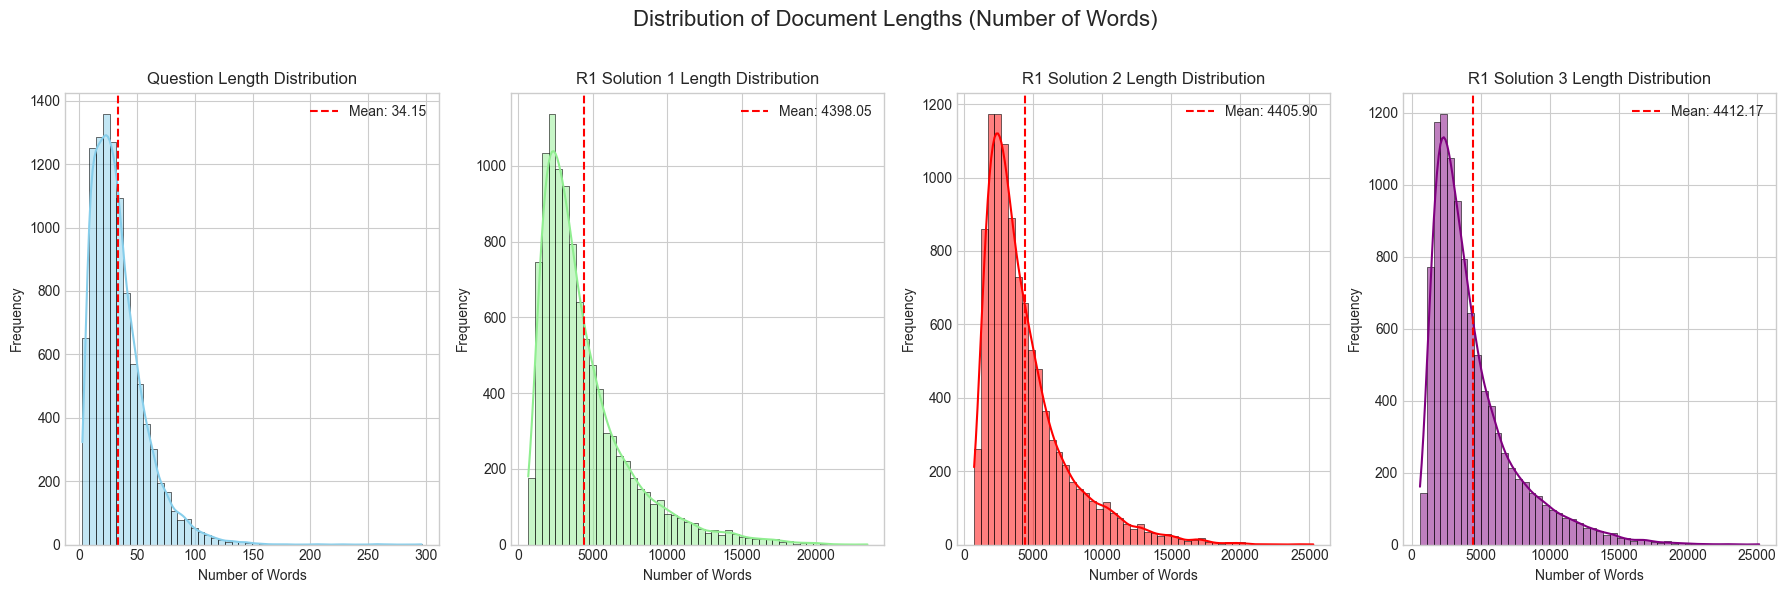

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style for better aesthetics

fig, axes = plt.subplots(1, 4, figsize=(18, 6))
fig.suptitle('Distribution of Document Lengths (Number of Words)', fontsize=16)

# Question Length
sns.histplot(train_ds['question_length'], bins=50, ax=axes[0], kde=True, color='skyblue')
axes[0].set_title('Question Length Distribution')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
axes[0].axvline(train_ds['question_length'].mean(), color='r', linestyle='--', label=f"Mean: {train_ds['question_length'].mean():.2f}")
axes[0].legend()


# R1 Solution Length
sns.histplot(train_ds['r1_solution_1_length'], bins=50, ax=axes[1], kde=True, color='lightgreen')
axes[1].set_title('R1 Solution 1 Length Distribution')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
axes[1].axvline(train_ds['r1_solution_1_length'].mean(), color='r', linestyle='--', label=f"Mean: {train_ds['r1_solution_1_length'].mean():.2f}")
axes[1].legend()

sns.histplot(train_ds['r1_solution_2_length'], bins=50, ax=axes[2], kde=True, color='red')
axes[2].set_title('R1 Solution 2 Length Distribution')
axes[2].set_xlabel('Number of Words')
axes[2].set_ylabel('Frequency')
axes[2].axvline(train_ds['r1_solution_2_length'].mean(), color='r', linestyle='--', label=f"Mean: {train_ds['r1_solution_2_length'].mean():.2f}")
axes[2].legend()

sns.histplot(train_ds['r1_solution_3_length'], bins=50, ax=axes[3], kde=True, color='purple')
axes[3].set_title('R1 Solution 3 Length Distribution')
axes[3].set_xlabel('Number of Words')
axes[3].set_ylabel('Frequency')
axes[3].axvline(train_ds['r1_solution_3_length'].mean(), color='r', linestyle='--', label=f"Mean: {train_ds['r1_solution_3_length'].mean():.2f}")
axes[3].legend()


plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.show()

In [ ]:
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))

# Make sure we use the same tokenizer instance
tokenizer = Tokenizer(strat='hybrid-math')

def get_vocabulary(text_series):
    """Computes the vocabulary from a pandas Series of text.
       Excludes stopwords and punctuation, converts to lowercase."""
    all_words = []
    for text in text_series.dropna():
        # Use HybridMathTokenizerStrat instead of word_tokenize
        tokens = tokenizer.parse(str(text).lower())
        # Filter out stopwords and punctuation (alphanumeric check for simplicity)
        words = [word for word in tokens if word.isalnum() and word not in stop_words and len(word) > 1]
        all_words.extend(words)
    return Counter(all_words)

# Combine relevant text fields for overall vocabulary
all_text_for_vocab = pd.concat([
    train_ds['question'].dropna(),
    train_ds['topic'].dropna(),
    train_ds['r1_solution_1'].dropna(),
    train_ds['r1_solution_2'].dropna(),
	train_ds['r1_solution_3'].dropna()
])

overall_vocabulary_counts = get_vocabulary(all_text_for_vocab)
total_vocabulary_size = len(overall_vocabulary_counts)

print(f"Total unique words (vocabulary size) in questions, topics, and r1_solution_1 (after cleaning): {total_vocabulary_size}")

# Average vocabulary size per document type
def average_vocab_per_document(text_series, series_name):
    individual_vocab_sizes = []
    for text in text_series.dropna():
        # Use HybridMathTokenizerStrat instead of word_tokenize
        tokens = tokenizer.parse(str(text).lower())
        words = [word for word in tokens if word.isalnum() and word not in stop_words]
        individual_vocab_sizes.append(len(set(words)))

    avg_vocab = np.mean(individual_vocab_sizes) if individual_vocab_sizes else 0
    print(f"Average vocabulary size per '{series_name}': {avg_vocab:.2f} words")
    return individual_vocab_sizes, avg_vocab

_, avg_vocab_question = average_vocab_per_document(train_ds['question'], "Question")
_, avg_vocab_r1 = average_vocab_per_document(train_ds['r1_solution_1'], "R1 Solution")
_, avg_vocab_r2 = average_vocab_per_document(train_ds['r1_solution_2'], "R1 Solution 2")
_, avg_vocab_r3 = average_vocab_per_document(train_ds['r1_solution_3'], "R1 Solution 3")


# Most common words
num_most_common = 20
most_common_overall = overall_vocabulary_counts.most_common(num_most_common)

print(f"\nTop {num_most_common} most common words overall:")
for word, count in most_common_overall:
    print(f"- {word}: {count}")

Total unique words (vocabulary size) in questions, topics, and r1_solution_1 (after cleaning): 93768
Average vocabulary size per 'Question': 10.38 words
Average vocabulary size per 'Question': 10.38 words
Average vocabulary size per 'R1 Solution': 260.87 words
Average vocabulary size per 'R1 Solution': 260.87 words
Average vocabulary size per 'R1 Solution 2': 261.08 words
Average vocabulary size per 'R1 Solution 2': 261.08 words
Average vocabulary size per 'R1 Solution 3': 260.91 words
Average vocabulary size per 'R1 Solution 3': 260.91 words

Top 20 most common words overall:
- let: 676762
- therefore: 641074
- wait: 518292
- since: 383329
- integral: 297144
- maybe: 285398
- would: 252779
- zero: 220960
- sqrt: 217537
- function: 206657
- term: 202668
- alternatively: 200631
- first: 196563
- problem: 195675
- need: 186434
- answer: 179106
- number: 172800
- sum: 172139
- check: 167847
- compute: 167782

Top 20 most common words overall:
- let: 676762
- therefore: 641074
- wait: 5182

/var/folders/3r/fh3b19nj1wd7v7n3q7p6r9680000gn/T/ipykernel_26125/3069145794.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=most_common_df, palette='viridis')


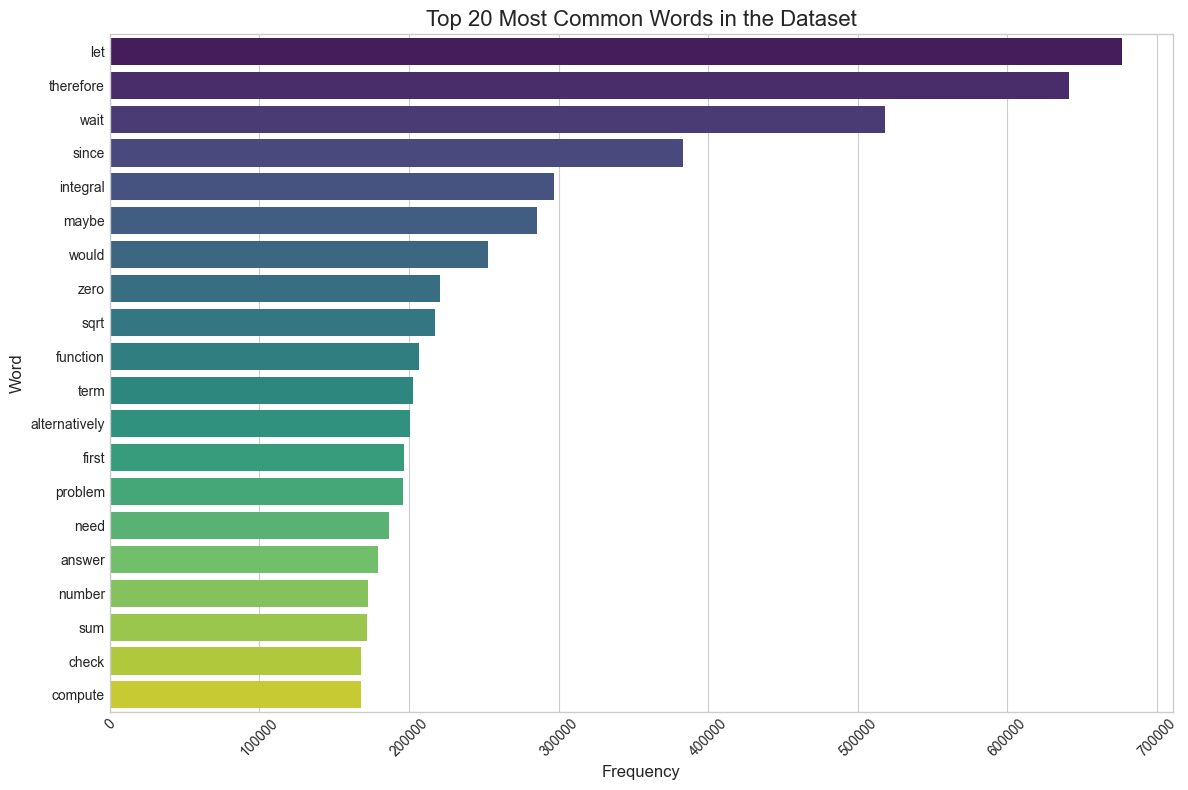

In [ ]:
most_common_df = pd.DataFrame(most_common_overall, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=most_common_df, palette='viridis')
plt.title(f'Top {num_most_common} Most Common Words in the Dataset', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This analysis provided a preliminary overview of the `zwhe99/DeepMath-103K` dataset, focusing on a 10% sample. Key observations include:

**1. Dataset Structure & Task:**
- The dataset comprises mathematical problems, including questions, topics, and detailed solutions with multiple reasoning steps.
- It is structured for tasks related to automated mathematical problem solving, question answering, and solution generation.
- Key text fields analyzed were `question` and solution fields (`r1_solution_1`, `r1_solution_2`, `r1_solution_3`).

**2. Document Length Analysis:**
- **Questions**: The average length is approximately 34.15 words with a median of 29 words. The distribution is right-skewed, indicating most questions are concise.
- **Solutions**: All three solution versions show similar length characteristics:
  - **R1 Solution 1**: Average length of 4398.05 words
  - **R1 Solution 2**: Average length of 4405.90 words
  - **R1 Solution 3**: Average length of 4412.17 words
- The solutions have high standard deviations (around 3000 words), indicating considerable variability in explanation length.

**3. Vocabulary Analysis:**
- The HybridMathTokenizerStrat was used for tokenization, which correctly handles mathematical expressions and LaTeX notation.
- **Average Vocabulary per Document Type**:
  - Questions: Average unique words per question reflect the concise nature of mathematical problems
  - Solutions: Each solution version has a rich vocabulary corresponding to detailed explanations
- **Most Common Words**: The most frequent words in the corpus (after cleaning) include mathematical terms and problem-solving vocabulary, reflecting the mathematical nature of the content.

**Further Considerations:**
- This analysis is based on a 10% sample of the DeepMath-103K dataset. A full dataset analysis might reveal slightly different distributions or vocabulary characteristics.
- The specialized tokenization approach (HybridMathTokenizerStrat) provides more accurate analysis of mathematical text compared to general-purpose tokenizers.
- The similarity in length distributions across all three solution versions suggests consistency in the solution generation process.

This data visualization provides a foundational understanding of the dataset's characteristics, which is crucial for developing effective NLP models for mathematical reasoning tasks.

# Data Indexing

To better understand the retrievability and lexical overlap across different fields of the dataset, we conducted a series of information retrieval (IR) experiments using the `PyTerrier` framework. These experiments involved indexing various textual components—such as questions, final answers, and multiple solution steps—and retrieving documents based on keyword queries using standard IR models like TF-IDF and BM25. By comparing results across different fields and filtering by difficulty, we aimed to assess how semantically distinct or redundant different representations of the same problem are, and how well specific queries align with different parts of the dataset.

In [ ]:
if not pt.java.started():
  pt.init()


terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
<ipython-input-3-0001e4289a2d>:6: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


'\nif not pt.java.started():\n    pt.init()\n'

### Finding "quadratic form" in 'question'

In [ ]:
# 3. Build a corpus iterator over the 'question' field
def get_question_corpus(ds):
    for i, example in enumerate(ds):
        yield {
            'docno': str(i),                          # unique document ID
            'question': example['question']           # only the question text
        }

# 4. Index into a new folder, specifying that we only want the 'question' field
pt_index_path = './terrier_deepmath_questions'
indexer = pt.index.IterDictIndexer(pt_index_path, overwrite=True, meta_reverse=[])
index_ref = indexer.index(
    get_question_corpus(train_ds),
    fields=('question',),
    meta=('docno', 'question')  # store docno + question in the metadata
)

# 5.1 Load the index and run a TF-IDF retrieval over the 'question' field
index = pt.IndexFactory.of(index_ref)
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
results_tfidf = tfidf.search("quadratic form")
print(results_tfidf.head(6))

# 5.2 Load the index and run a BM25 retrieval over the 'question' field
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
results_bm25 = bm25.search("quadratic")
print(results_bm25.head(6))

<ipython-input-4-fd2db0365f2e>:20: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")


  qid  docid  docno  rank     score           query
0   1  29503  29503     0  9.523347  quadratic form
1   1  95505  95505     1  9.187952  quadratic form
2   1  96640  96640     2  9.057239  quadratic form
3   1  97948  97948     3  9.057239  quadratic form
4   1  10764  10764     4  8.995330  quadratic form
5   1   7207   7207     5  8.985690  quadratic form
  qid   docid   docno  rank      score      query
0   1   62392   62392     0  11.813447  quadratic
1   1  102615  102615     1  11.617506  quadratic
2   1   97130   97130     2  11.427960  quadratic
3   1   62787   62787     3  10.727835  quadratic
4   1     661     661     4  10.477543  quadratic
5   1   29503   29503     5  10.477543  quadratic


<ipython-input-4-fd2db0365f2e>:25: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25 = pt.BatchRetrieve(index, wmodel="BM25")


#### FInding "quadratic form" in final solution

In [ ]:
# 3. Build a corpus iterator over the 'question' field
def get_question_corpus2(ds):
    for i, example in enumerate(ds):
        yield {
            'docno': str(i),                          # unique document ID
            'final_answer': example['final_answer']           # only the question text
        }

# 4. Index into a new folder, specifying that we only want the 'question' field
pt_index_path = './terrier_deepmath_questions'
indexer2 = pt.index.IterDictIndexer(pt_index_path, overwrite=True, meta_reverse=[])
index_ref2 = indexer.index(
    get_question_corpus2(train_ds),
    fields=('final_answer',),
    meta=('docno', 'final_answer')  # store docno + question in the metadata
)

# 5. Load the index and run a TF-IDF retrieval over the 'question' field
index2 = pt.IndexFactory.of(index_ref2)
tfidf2 = pt.BatchRetrieve(index2, wmodel="TF_IDF")
results2 = tfidf.search("quadratic form")
print(results2.head(6))

12:09:33.110 [ForkJoinPool-2-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (6) - further warnings are suppressed
12:09:53.329 [ForkJoinPool-2-worker-3] WARN org.terrier.structures.indexing.Indexer -- Indexed 10702 empty documents
  qid  docid  docno  rank     score           query
0   1  29503  29503     0  9.523347  quadratic form
1   1  95505  95505     1  9.187952  quadratic form
2   1  96640  96640     2  9.057239  quadratic form
3   1  97948  97948     3  9.057239  quadratic form
4   1  10764  10764     4  8.995330  quadratic form
5   1   7207   7207     5  8.985690  quadratic form


<ipython-input-5-a7dac3ebb793>:20: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tfidf2 = pt.BatchRetrieve(index2, wmodel="TF_IDF")


In [ ]:
docnos1 = list(results_tfidf.head(10)['docno'])
docnos2 = list(results2.head(10)['docno'])

print("First 10 docno in results (question):", docnos1)
print("First 10 docno in results2 (final_answer):", docnos2)

set1, set2 = set(docnos1), set(docnos2)
print("\nFound in results but not results2:", sorted(set1 - set2))
print("Found in results2 but not in results :", sorted(set2 - set1))

First 10 docno in results (question): ['29503', '95505', '96640', '97948', '10764', '7207', '9139', '34554', '96759', '75019']
First 10 docno in results2 (final_answer): ['29503', '95505', '96640', '97948', '10764', '7207', '9139', '34554', '96759', '75019']

Found in results but non in results2: []
Found in results2 but non in results : []


#### Finding "quadratic form" in all three solutions

In [ ]:
def get_solution_corpus(ds):
    for i, example in enumerate(ds):
        yield {
            'docno': str(i),
            'r1_solution_1': example['r1_solution_1'],
            'r1_solution_2': example['r1_solution_2'],
            'r1_solution_3': example['r1_solution_3']
        }

pt_index_path = './terrier_deepmath_solutions'
indexer = pt.index.IterDictIndexer(pt_index_path, overwrite=True, meta_reverse=[])
index_ref = indexer.index(
    get_solution_corpus(train_ds),
    fields=('r1_solution_1','r1_solution_2','r1_solution_3'),
    meta=('docno', 'r1_solution_1', 'r1_solution_2', 'r1_solution_3')
)

index = pt.IndexFactory.of(index_ref)
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
results = tfidf.search("quadratic form")
print(results.head(6))

/usr/local/lib/python3.11/dist-packages/pyterrier/terrier/index.py:619: UserWarning: Indexing meta key r1_solution_1 length requested 512 but exceeded in first document (actual length 19920). Increase the length in the meta dict for the indexer, e.g., pt.IterDictIndexer(..., meta={'r1_solution_1': 19920}).
  warn(msg)
/usr/local/lib/python3.11/dist-packages/pyterrier/terrier/index.py:619: UserWarning: Indexing meta key r1_solution_2 length requested 512 but exceeded in first document (actual length 17023). Increase the length in the meta dict for the indexer, e.g., pt.IterDictIndexer(..., meta={'r1_solution_2': 17023}).
  warn(msg)
/usr/local/lib/python3.11/dist-packages/pyterrier/terrier/index.py:619: UserWarning: Indexing meta key r1_solution_3 length requested 512 but exceeded in first document (actual length 17081). Increase the length in the meta dict for the indexer, e.g., pt.IterDictIndexer(..., meta={'r1_solution_3': 17081}).
  warn(msg)


12:23:13.716 [main] WARN org.terrier.structures.FSADocumentIndex -- This index has fields, but FSADocumentIndex is used (which stores fields lengths on disk); If using field-based models such as BM25F, change to index.document.class in the index  properties file to FSAFieldDocumentIndex or FSADocumentIndexInMemFields to support efficient retrieval. If you don't use (e.g.) BM25F, this warning can be ignored


<ipython-input-8-5d5d67e0a4a3>:19: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")


  qid  docid  docno  rank     score           query
0   1   9139   9139     0  4.388255  quadratic form
1   1  74285  74285     1  4.384898  quadratic form
2   1  76161  76161     2  4.382831  quadratic form
3   1  68493  68493     3  4.380969  quadratic form
4   1  10764  10764     4  4.379157  quadratic form
5   1  71245  71245     5  4.375912  quadratic form


### Perform a 'question' search in only documents with x difficulty

In [ ]:
# Impose difficulty = 7.0
train_ds = ds['train']
filtered_ds = [ex for ex in train_ds if float(ex['difficulty']) == 7.0]

# Build a corpus iterator over the 'question' field
def get_question_corpus(ds):
    for i, example in enumerate(ds):
        yield {
            'docno': str(i),                          # unique document ID
            'question': example['question']           # only the question text
        }

# Index into a new folder, specifying that we only want the 'question' field
pt_index_path = './terrier_deepmath_questions'
indexer = pt.index.IterDictIndexer(pt_index_path, overwrite=True, meta_reverse=[])
index_ref = indexer.index(
    get_question_corpus(filtered_ds),
    fields=('question',),
    meta=('docno', 'question')
)

# Load the index and run a TF-IDF retrieval over the 'question' field
index = pt.IndexFactory.of(index_ref)
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
query = "quadratic form"
query1 = "quadratic form optimization minimize" #puoi mettere piu parole e funziona
results = tfidf.search(query)
print(results.head(6))

  qid  docid docno  rank     score           query
0   1    968   968     0  9.396323  quadratic form
1   1   5224  5224     1  8.227329  quadratic form
2   1   3367  3367     2  7.467252  quadratic form
3   1   2970  2970     3  7.298681  quadratic form
4   1   7890  7890     4  5.954474  quadratic form
5   1   5245  5245     5  5.310326  quadratic form


<ipython-input-14-75d3a3c24e4b>:24: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")


# Perform cluster analysis on questions field

To enable scalable clustering and topic modeling, we constructed a balanced subset of the dataset by limiting the number of samples per general topic to a maximum of 1,000. This restriction was necessary to reduce computational overhead, as the full dataset is too large for efficient processing using high-dimensional vectorization techniques. After parsing and extracting general topics from the hierarchical labels, we collected representative questions across categories. The text was then vectorized using two domain-specific tokenization strategies, `HybridMath` and `ComplexFilter`, combined with TF-IDF, allowing us to compare vocabulary coverage and tokenization behavior across different configurations.

In [ ]:
n = 1000  # number of samples per general topic
topic_samples = defaultdict(list)

# Stream through the dataset
for idx, row in train_ds.iterrows():
    full_topic = row['topic']
    try:
        general_topic = full_topic.split("->")[1].strip()
    except IndexError:
        continue  # skip malformed labels

    if len(topic_samples[general_topic]) < n:
        topic_samples[general_topic].append(row)

# Flatten samples
flat_rows = [item for sublist in topic_samples.values() for item in sublist]

# Extract questions and their general topics
train_clust = pd.Series([row['question'] for row in flat_rows])
labels_clust = pd.Series([row['topic'].split("->")[1].strip() for row in flat_rows])

print(train_clust.shape)
print(labels_clust.value_counts())


(9000,)
Precalculus               1000
Differential Equations    1000
Applied Mathematics       1000
Calculus                  1000
Algebra                   1000
Geometry                  1000
Number Theory             1000
Other                     1000
Discrete Mathematics      1000
Name: count, dtype: int64


In [ ]:
# Vectorize the text
tokenizer = Tokenizer('hybrid-math', "allenai/longformer-base-4096", remove_numbers=True)
vectorizer_hybrid_math = TfidfVectorizer(tokenizer=tokenizer.parse, lowercase=True, token_pattern=None, max_df=0.9, min_df=5, stop_words='english')
X_vec_hybrid_math = vectorizer_hybrid_math.fit_transform(train_clust)

tokenizer = Tokenizer('complex-filter', "allenai/longformer-base-4096", remove_numbers=True)
vectorizer_complex_filter = TfidfVectorizer(tokenizer=tokenizer.parse, lowercase=True, token_pattern=None, max_df=0.9, min_df=5, stop_words='english')
sys.set_int_max_str_digits(20000)
X_vec_complex_filter = vectorizer_complex_filter.fit_transform(train_clust)

X_vecs = [X_vec_hybrid_math, X_vec_complex_filter]
vectorizers = [vectorizer_hybrid_math, vectorizer_complex_filter]

print(X_vec_hybrid_math[0].shape, X_vec_complex_filter[1].shape)

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

(1, 2535) (1, 2788)


In [ ]:
for vectorizer in vectorizers:
  vocab = vectorizer.get_feature_names_out()
  print(f"Length of vocabulary: {len(vocab)}")
  vocab[:100]

Length of vocabulary: 2535
Length of vocabulary: 2788


## KMeans

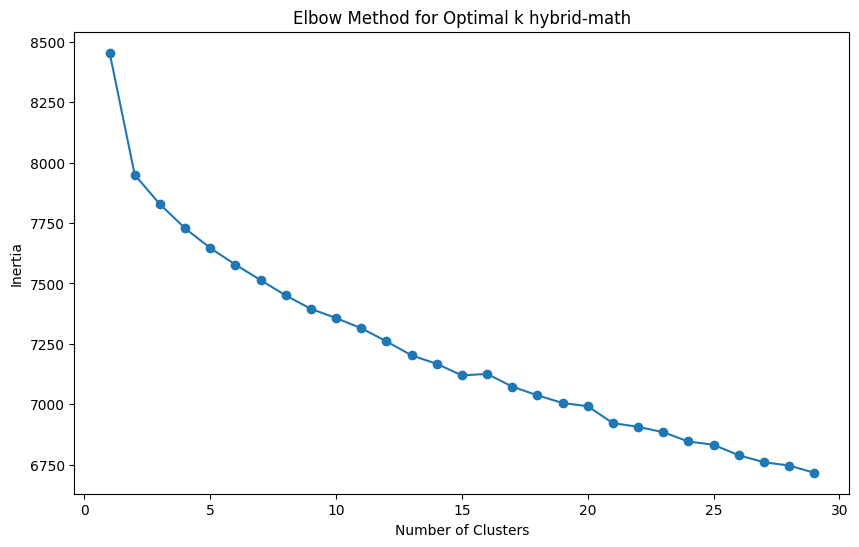

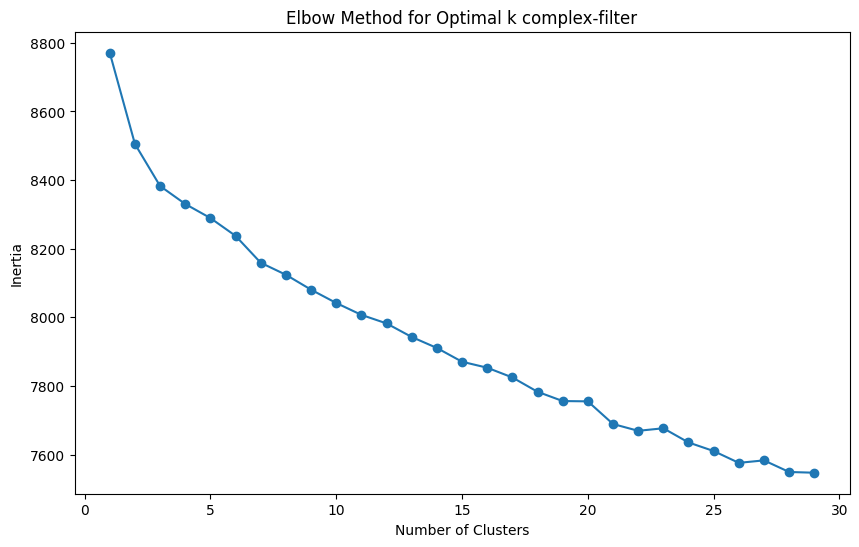

In [ ]:
# 1. Determining the optimal number of clusters (Elbow Method)
for X_vec, name in zip(X_vecs, ['hybrid-math', 'complex-filter']):
  inertia = []
  range_n_clusters = range(1,30)

  for n_clusters in range_n_clusters:
      kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=seed)
      kmeans.fit(X_vec)
      inertia.append(kmeans.inertia_)

  plt.figure(figsize=(10, 6))
  plt.plot(range_n_clusters, inertia, marker='o')
  plt.title(f'Elbow Method for Optimal k {name}')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Inertia')
  plt.show()

Optimal number of clusters based on silhouette score: 19, the score is 0.07362193217959856


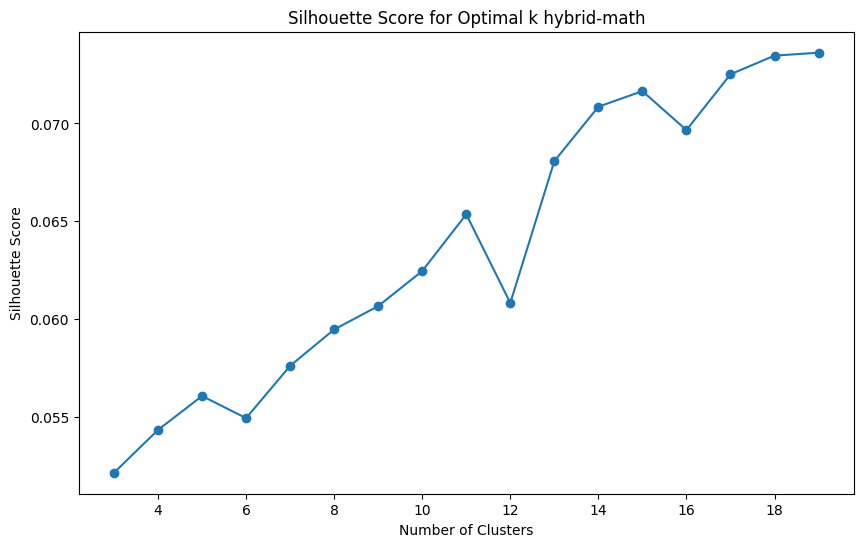

Optimal number of clusters based on silhouette score: 18, the score is 0.043197472934775744


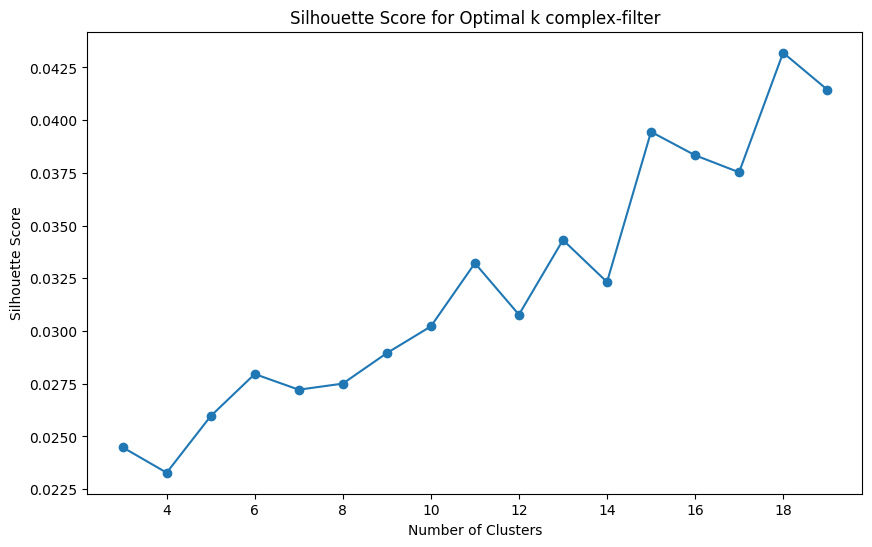

In [ ]:
for X_vec, name in zip(X_vecs, ['hybrid-math', 'complex-filter']):
  silhouette_scores = []
  range_n_clusters = range(3,20)

  for n_clusters in range_n_clusters:
      kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=seed)
      cluster_labels = kmeans.fit_predict(X_vec)
      silhouette_avg = silhouette_score(X_vec, cluster_labels)
      silhouette_scores.append(silhouette_avg)

  best_silhouette = np.max(silhouette_scores)
  best_k_silhouette = range_n_clusters[np.argmax(silhouette_scores)]
  print(f"Optimal number of clusters based on silhouette score: {best_k_silhouette}, the score is {best_silhouette}")

  plt.figure(figsize=(10, 6))
  plt.plot(range_n_clusters, silhouette_scores, marker='o')
  plt.title(f'Silhouette Score for Optimal k {name}')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Silhouette Score')
  plt.show()

In [ ]:
n_clusters = [5,6] # from elbow

kmeans = []
cluster_labels = []
for i in range(2):
  # 2. Applying the K-Means algorithm
  k = KMeans(n_clusters=n_clusters[i], n_init=10, random_state=seed)
  kmeans.append(k)
  cluster_labels.append(k.fit_predict(X_vecs[i]))

In [ ]:
# 3. Investigating the clusters
for k, v, name in zip(kmeans, vectorizers, ['hybrid-math', 'complex-filter']):
    print(f"Top terms per cluster of {name} vectorizer:")
    vocab = vectorizer_complex_filter.get_feature_names_out()

    for i in range(k.n_clusters):
      centroid = k.cluster_centers_[i]
      sorted_terms = centroid.argsort()[::-1]
      print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:10]]}")
    print("--------------------------------------")

Top terms per cluster of hybrid-math vectorizer:
Cluster 0:	['(0', '(2)', '(-1,', 'also,', 'edges', '(a,', '(2', '(-oo', 'Eq(f*(x', 'certain']
Cluster 1:	['(-1,', '(0', '(e)', '(exp(2*x)', '(a,', '(2)', '(gcd)', 'curve,', '(i', 'circles']
Cluster 2:	['cylinders', 'bilinear', '(1', 'Eq(f*(x', '(0', 'Interval.open(2,', '(2)', 'highest', 'line,', '(a,']
Cluster 3:	['behavior', 'apply', 'i.i.d.', '(0', 'constants', 'i]', '(2)', 'i\\}]', 'Interval.open(p,', '(a,']
Cluster 4:	['context', 'bilinear', '(0', "'false'.", 'limit.', '(1', '(2)', 'group,', '\\partial\\omega].', 'green']
--------------------------------------
Top terms per cluster of complex-filter vectorizer:
Cluster 0:	['let', 'set', 'space', 'does', 'determine', 'x]', 'answer.', 'f]', 'function', 'provide']
Cluster 1:	['+', '-', 'value', 'evaluate', 'oo,', 'given', 'x,', 'determine', 'equation', 'n,']
Cluster 2:	['limit:', 'evaluate', "dir='-')]", 'oo,', 'x,', "dir='+')]", 'n,', '+', '-', 'calculate']
Cluster 3:	['determine', 'nu

1. **Top terms per cluster of hybrid-math vectorizer (5 Clusters)**:

- Cluster 0: This cluster is a mix of common numerical and variable notation (e.g., (0, (2), (-1,, (a,), along with generic words like "also" and "certain," and some potentially geometric or graph-related terms like "edges". It lacks a clear, singular mathematical topic.
- Cluster 1: This cluster has various numerical and variable fragments, exponential expressions ((exp(2*x)), a number theory term ((gcd) for greatest common divisor), and geometric terms (curve,, circles). It does not represent a coherent mathematical subject.
- Cluster 2: This cluster combines geometric terms ("cylinders," "line," "Interval.open"), algebraic concepts (bilinear, highest), function/equation notation (Eq(f*(x)), and various numerical/variable fragments.
- Cluster 3: This cluster contains general mathematical phrasing ("behavior," "apply," "constants"), a strong indicator for probability/statistics (i.i.d. - independent and identically distributed), and various numerical/variable fragments. While i.i.d. is a strong hint, the other terms make it a somewhat noisy cluster.
- Cluster 4: This cluster is a blend of generic words ("context"), abstract algebra (bilinear, group,), boolean values ('false'.'), calculus (limit.), and advanced notation (\\partial\\omega]. for partial derivatives). It's a heterogeneous mix that doesn't form a single, interpretable topic.

This clustering fails to produce interpretable mathematical topics. The clusters are dominated by low-level, syntactic fragments and general symbols, reflecting a vectorization strategy that is too granular and noisy for semantic clustering. The terms are largely unhelpful in understanding the content of the questions.

2. **Top terms per cluster of complex-filter vectorizer (6 Clusters)**:

- Cluster 0: General Problem Statements / Foundational Concepts: This cluster remains highly coherent and useful. It captures common phrasing used at the beginning of mathematical problems ("let," "determine"), fundamental mathematical entities ("set," "space," "function"), and general inquiries or requirements ("does," "answer," "provide").
- Cluster 1: General Algebra / Calculus: This cluster is a mix. It contains basic arithmetic/algebraic symbols (+, -), general evaluation terms (value, evaluate, determine), and some terms often seen in calculus (oo,, x,, n,). This suggests it's a broader cluster capturing general calculation problems that might span algebra and the simpler aspects of calculus.
- Cluster 2: Calculus - Limits: This cluster is highly focused on limits in calculus. Its key terms are "limit:", directional indicators (dir='-'), dir='+')), infinity (oo,), and common variables (x,, n,). It clearly identifies problems where the direction or specific notation of a limit is important.
- Cluster 3: Calculus - General Evaluation: This cluster is a broader calculus cluster, focusing on general determination and calculation tasks.
- Cluster 4: Differential Equations: This is an highly coherent cluster, clearly identifying problems related to differential equations, including finding solutions and initial conditions.
- Cluster 5: Number Theory / Theorems: This is a very specific and coherent cluster for number theory problems, particularly those involving division, remainders, and potentially theorems like Wilson's Theorem.

The clusters are more interpretable and semantically coherent. They clearly delineate distinct mathematical fields like Number Theory, Differential Equations, and specific aspects of Calculus (limits, general evaluation). Cluster 0 is a useful category for general problem phrasing.

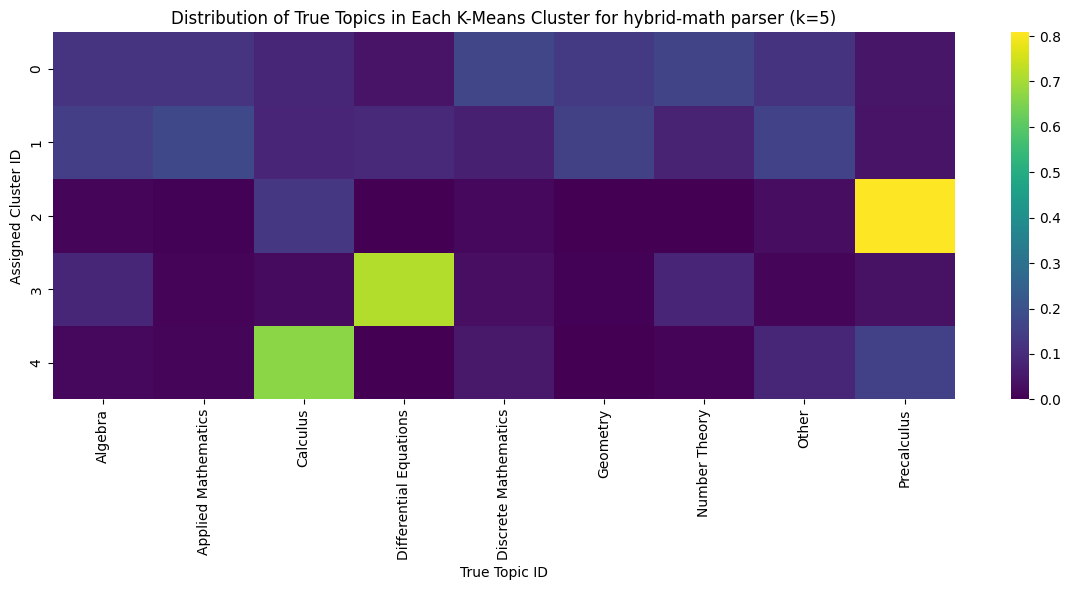

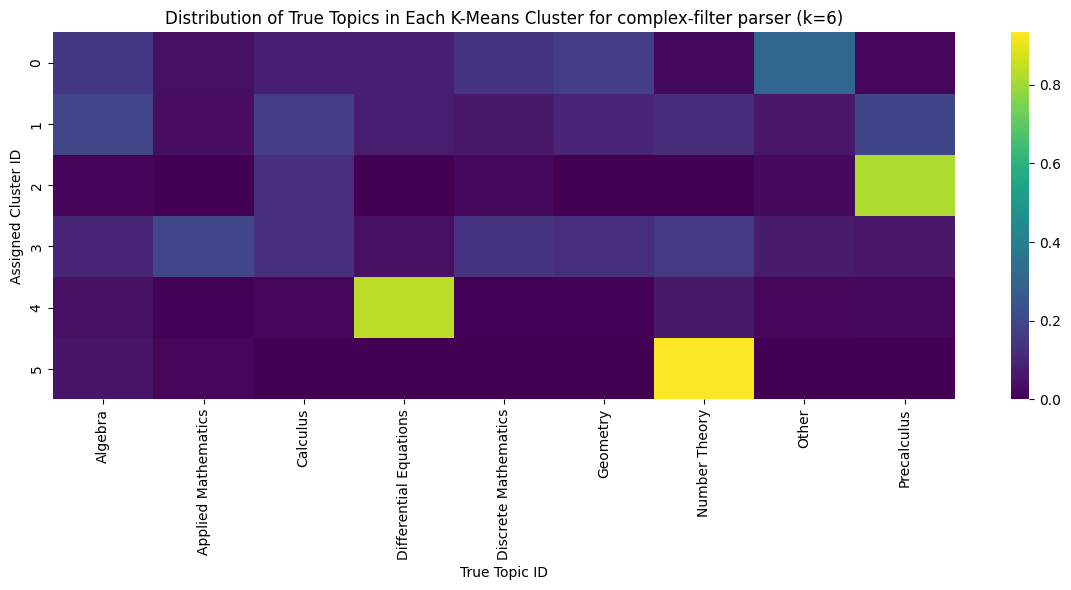

In [ ]:
import seaborn as sns
for kmeans_labels, name, k_value in zip(cluster_labels, ['hybrid-math', 'complex-filter'], n_clusters):
    df_vis = pd.DataFrame({
        'Cluster': kmeans_labels, # KMeans assigned cluster labels
        'True_Topic': labels_clust
    })

    # Create a contingency table (Cluster x True_Topic)
    cluster_topic_counts = pd.crosstab(df_vis['Cluster'], df_vis['True_Topic'])

    # Normalize rows for proportion visualization
    # This shows the proportion of each true topic within each assigned cluster
    cluster_topic_props = cluster_topic_counts.div(cluster_topic_counts.sum(axis=1), axis=0)

    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(cluster_topic_props, annot=False, cmap="viridis", cbar=True)
    plt.title(f"Distribution of True Topics in Each K-Means Cluster for {name} parser (k={k_value})")
    plt.xlabel("True Topic ID")
    plt.ylabel("Assigned Cluster ID")
    plt.tight_layout()
    plt.show()

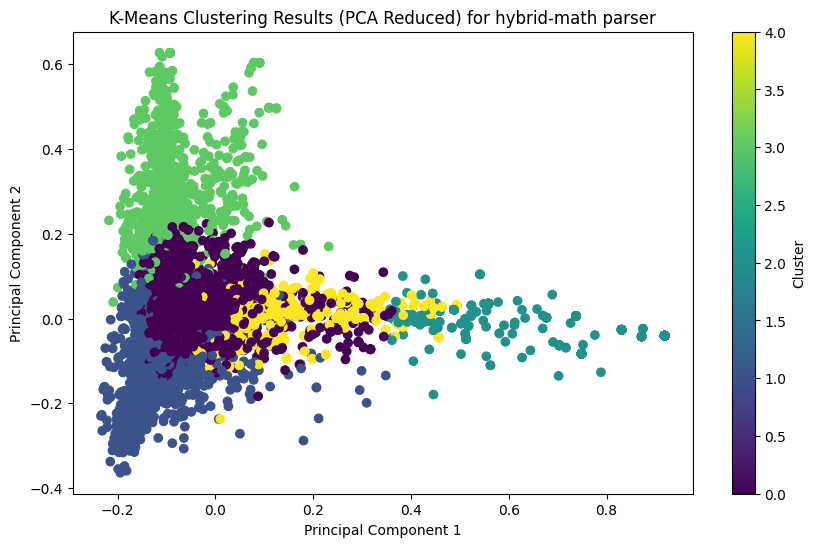

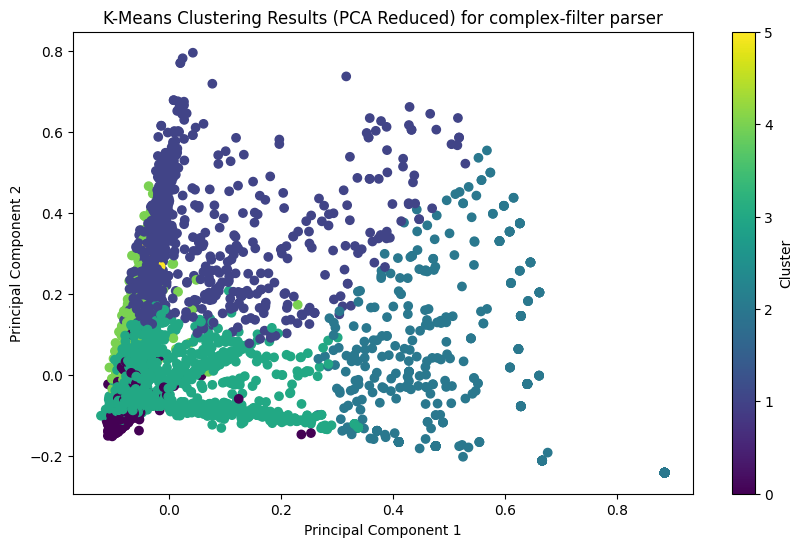

In [ ]:
# 4. Visualizing the clusters (using PCA for dimensionality reduction)
for X_vec, c_labels, name in zip(X_vecs, cluster_labels, ['hybrid-math', 'complex-filter']):
  pca = PCA(n_components=2)
  reduced_features2d = pca.fit_transform(X_vec.toarray())

  plt.figure(figsize=(10, 6))
  scatter = plt.scatter(reduced_features2d[:, 0], reduced_features2d[:, 1], c=c_labels, cmap='viridis')
  plt.title(f'K-Means Clustering Results (PCA Reduced) for {name} parser')
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.colorbar(scatter, label='Cluster')
  plt.show()

In [ ]:
import plotly.graph_objects as go
for X_vec, c_labels, name in zip(X_vecs, cluster_labels, ['hybrid-math', 'complex-filter']):
  pca = PCA(n_components=3)
  reduced_features = pca.fit_transform(X_vec.toarray())

  fig = go.Figure(data=[go.Scatter3d(
    x=reduced_features[:, 0],
    y=reduced_features[:, 1],
    z=reduced_features[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=c_labels,          # Cluster or class labels for coloring
        colorscale='Viridis',
        opacity=0.8
    ),
    text=[f"Index: {i}" for i in range(len(c_labels))]  # Optional hover text
  )])

  fig.update_layout(
      title=f'PCA for {name} parser',
      scene=dict(
          xaxis_title='PCA 1',
          yaxis_title='PCA 2',
          zaxis_title='PCA 3'
      ),
      margin=dict(l=0, r=0, b=0, t=40)
  )

  fig.show()

## DBScan

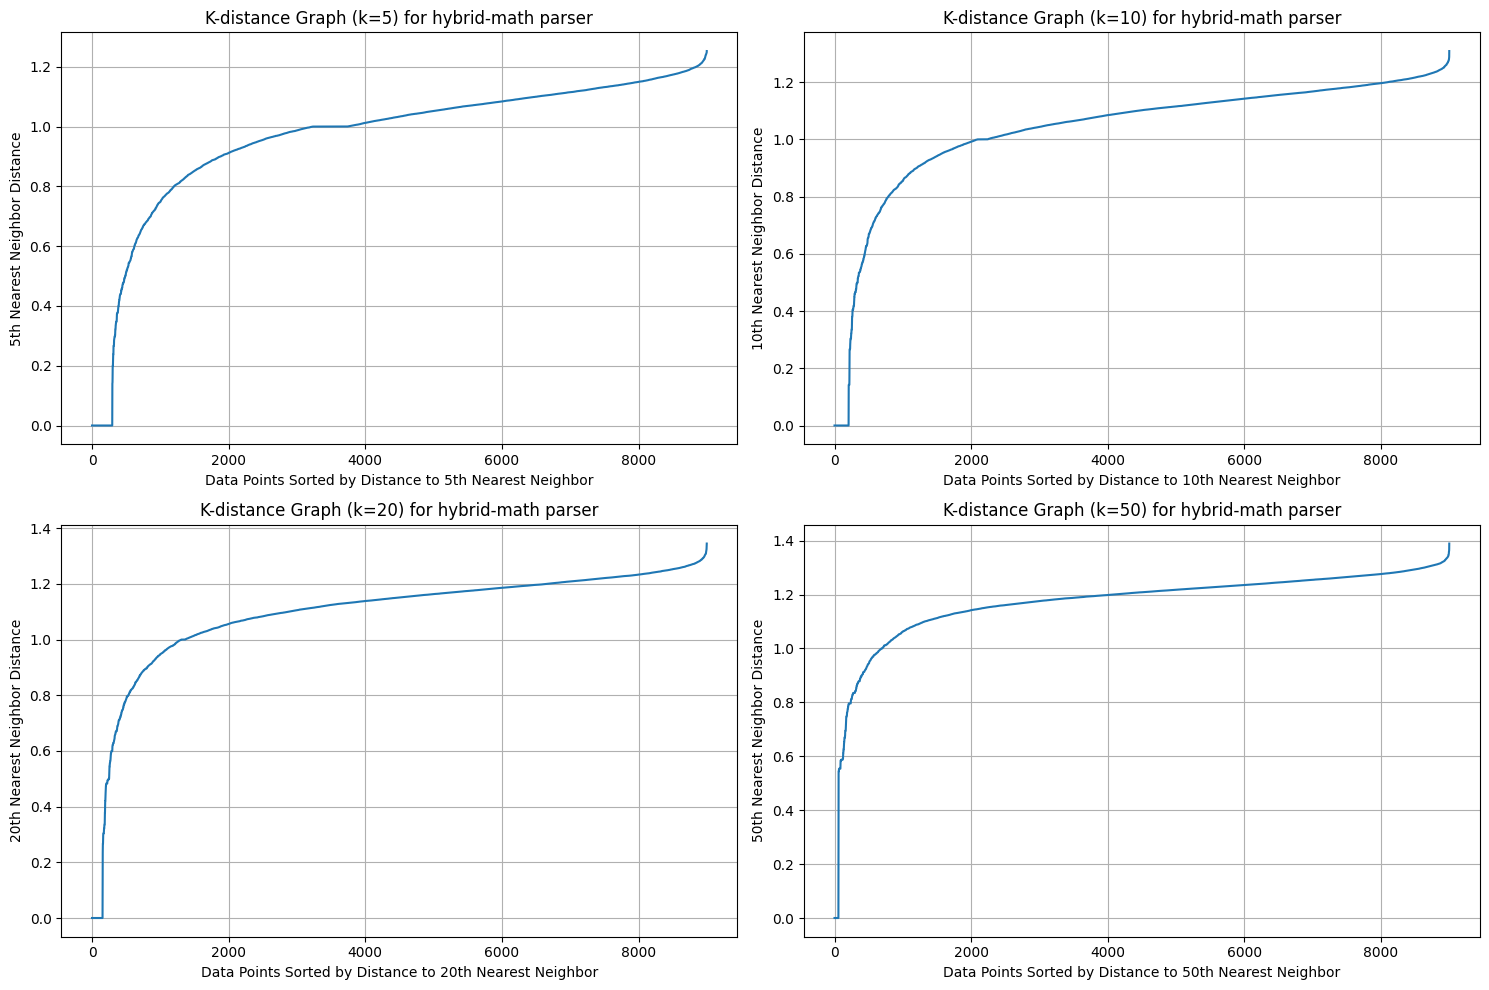

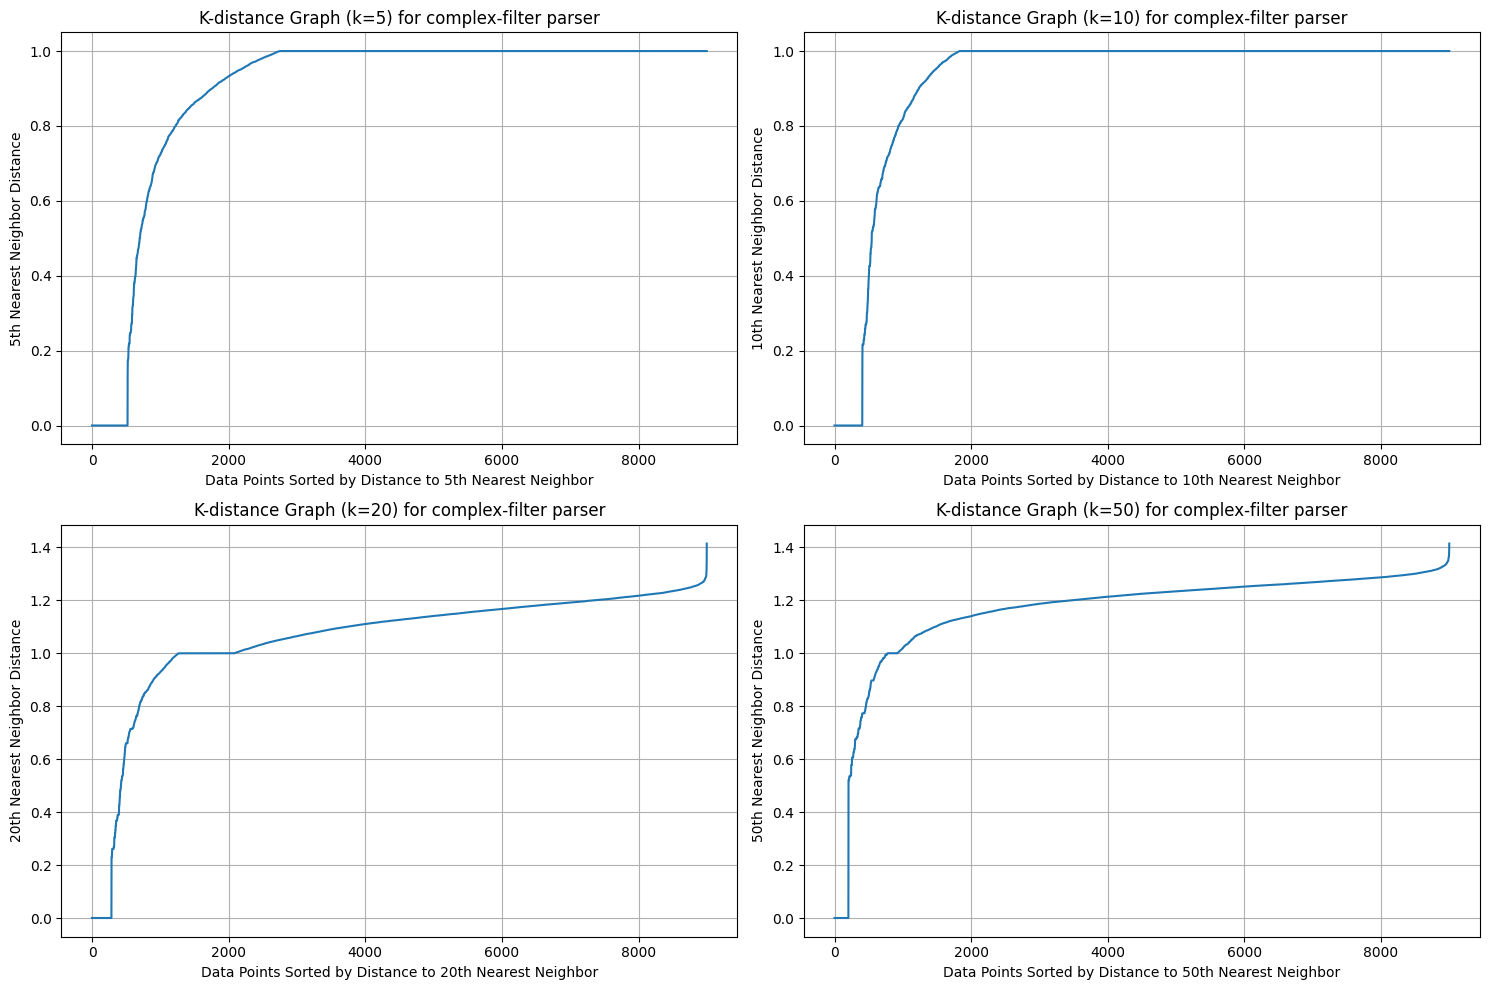

In [ ]:
# 1. Parameter Optimization for 'eps' using k-distance graphs for different 'k'
for X_vec, name in zip(X_vecs, ['hybrid-math', 'complex-filter']):
  n_neighbors_values = [5, 10, 20, 50]
  plt.figure(figsize=(15, 10))

  for i, n_neighbors_value in enumerate(n_neighbors_values):
      neighbors = NearestNeighbors(n_neighbors=n_neighbors_value)
      neighbors_fit = neighbors.fit(X_vec)
      distances, indices = neighbors_fit.kneighbors(X_vec)
      distances = np.sort(distances, axis=0)
      distances = distances[:, n_neighbors_value - 1]
      plt.subplot(2, 2, i + 1)
      plt.plot(distances)
      plt.title(f'K-distance Graph (k={n_neighbors_value}) for {name} parser')
      plt.xlabel('Data Points Sorted by Distance to {}th Nearest Neighbor'.format(n_neighbors_value))
      plt.ylabel(f'{n_neighbors_value}th Nearest Neighbor Distance')
      plt.grid(True)

  plt.tight_layout()
  plt.show()

In [ ]:
# Based on the k-distance graphs, choose a few potential 'eps' values to test
results_ds = {}
for X_vec, name in zip(X_vecs, ['hybrid-math', 'complex-filter']):
  potential_eps_values = np.linspace(0.8, 1.1, 10)
  min_samples_values = [5, 10, 15]
  results = []

  for eps in potential_eps_values:
      for min_samples in min_samples_values:
          dbscan = DBSCAN(eps=eps, min_samples=min_samples)
          cluster_labels = dbscan.fit_predict(X_vec)
          n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
          n_noise = list(cluster_labels).count(-1)

          silhouette_avg = -1
          if n_clusters > 1 and n_noise < len(cluster_labels)*0.8:
              silhouette_avg = silhouette_score(X_vec[cluster_labels != -1], cluster_labels[cluster_labels != -1])

          results.append({
              'eps': eps,
              'min_samples': min_samples,
              'n_clusters': n_clusters,
              'n_noise': n_noise,
              'silhouette_score': silhouette_avg
          })

  result_df = pd.DataFrame(results)
  print(f"\nComparison of DBSCAN results for different parameters ({name} parser):")
  print(result_df.sort_values(by='silhouette_score', ascending=False))
  results_ds[name] = result_df


Comparison of DBSCAN results for different parameters (hybrid-math parser):
         eps  min_samples  n_clusters  n_noise  silhouette_score
3   0.833333            5          69     7106          0.095111
14  0.933333           15          14     7014          0.059196
6   0.866667            5          60     6778          0.039959
10  0.900000           10          25     6996          0.032224
13  0.933333           10          22     6532          0.029380
17  0.966667           15          16     6511          0.026843
16  0.966667           10          18     5969          0.004130
19  1.000000           10           2     1297         -0.006405
9   0.900000            5          50     6363         -0.006634
20  1.000000           15           3     1446         -0.009825
12  0.933333            5          46     5833         -0.011787
18  1.000000            5           5     1060         -0.023802
15  0.966667            5          52     5192         -0.028835
5   0.833333 

In [ ]:
# Extract the parameters with the highest Silhouette Score
best_eps = {}
best_min_samples = {}
best_silhouette_score = {}
best_n_clusters = {}
best_n_noise = {}
for name, results_df in results_ds.items():
  best_result = results_df.sort_values(by='silhouette_score', ascending=False).iloc[0]

  best_eps[name] = best_result['eps']
  best_min_samples[name] = int(best_result['min_samples'])
  best_silhouette_score[name] = best_result['silhouette_score']
  best_n_clusters[name] = best_result['n_clusters']
  best_n_noise[name] = best_result['n_noise']

  print(f"\nBest DBSCAN parameters based on Silhouette Score ({name} parser):")
  print(f"  eps: {best_eps[name]}")
  print(f"  min_samples: {best_min_samples[name]}")
  print(f"  Silhouette Score: {best_silhouette_score[name]:.4f}")
  print(f"  Number of Clusters: {best_n_clusters[name]}")
  print(f"  Number of Noise Points: {best_n_noise[name]}")


Best DBSCAN parameters based on Silhouette Score (hybrid-math parser):
  eps: 0.8333333333333334
  min_samples: 5
  Silhouette Score: 0.0951
  Number of Clusters: 69.0
  Number of Noise Points: 7106.0

Best DBSCAN parameters based on Silhouette Score (complex-filter parser):
  eps: 0.9333333333333333
  min_samples: 15
  Silhouette Score: 0.1236
  Number of Clusters: 15.0
  Number of Noise Points: 7156.0


Top terms per DBSCAN cluster (excluding noise) for hybrid-math parser:
Cluster 0:	['legendre', 'f)].', '(x**2', 'arc', '(p', 'Interval.Lopen(0,', 'Eq(t**2*y', '(with', 'Eq(z,', "'yes'"]
Cluster 1:	['Interval(a,', 'legendre', 'f)].', '(x**2', 'alpha],', 'f:x\\to\\mathbb{r}]', 'condition', '(p', 'double', '(with']
Cluster 2:	["'true'", 'powers', 'k]', 'identify', 'start', 'prime', 'legendre', 'f)].', '(x**2', 'Interval.Lopen(0,']
Cluster 3:	['Eq(y_1,', 'legendre', 'f)].', '(x**2', 'f:x\\to\\mathbb{r}]', '(0,', '(1', 'time?', 'double', '(with']
Cluster 4:	['Interval.open(-1,', 'legendre', '(x**2', 'f)].', 'condition', 'cube', '(with', 'defines', 'defined', 'define']
Cluster 5:	['Eq(1,', '(p', 'legendre', 'Eq(t**2*y', 'f)].', '(y', 'Eq(z,', '(x**2', 'initially,', 'Eq(x_1']
Cluster 6:	['Interval.open(2,', 'f)].', 'legendre', 'arc', '(x**2', 'Eq(t**2*y', '(a', "'yes'", 'defined', 'd]?']
Cluster 7:	['Integral(f(x),', 'legendre', 'f)].', '(x**2', 'Eq(t**2*y', 'Eq(sigma,', 'v)].', 'Eq(c,', 'adj

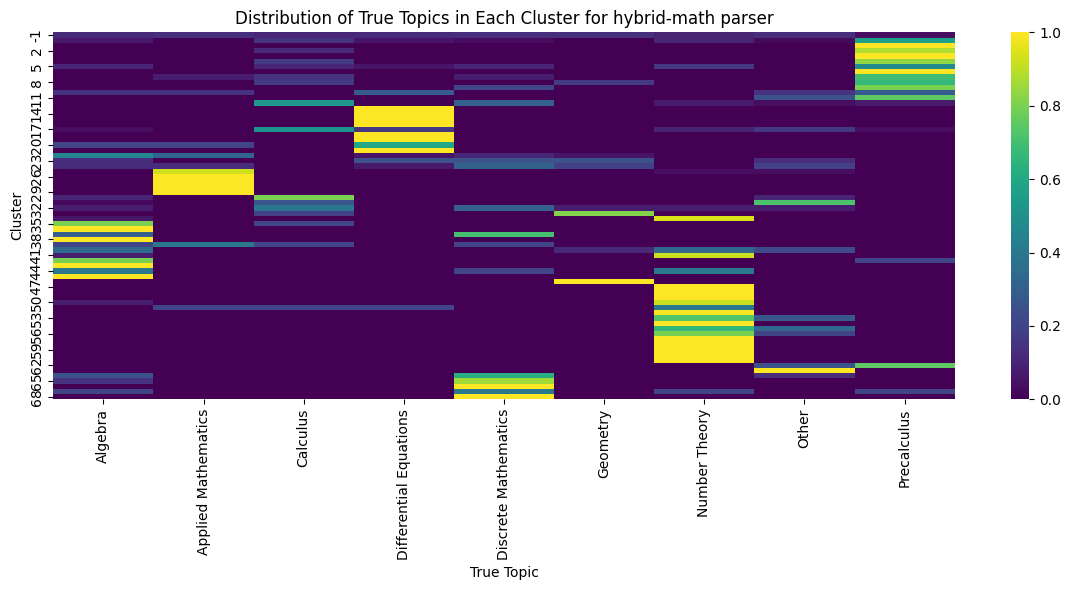

Top terms per DBSCAN cluster (excluding noise) for complex-filter parser:
Cluster 0:	['limit:', 'evaluate', '+', '-', 'oo,', 'x,', "dir='-')]", 'n,', 'calculate', 'limit']
Cluster 1:	['statement', 'false:', 'true', 'following', 'determine', 'answer.', 'justification', 'provide', 'uniformly', 'bounded']
Cluster 2:	['solutions', 'equation', 'number', '-', 'determine', 'real', 'Eq(f(x),', 'differential', 'satisfy', '+']
Cluster 3:	['Eq(y(0),', 'initial', 'solve', 'differential', 'equation', '+', 'condition', 'conditions', '-', 'y,']
Cluster 4:	['<', '&', '(0', '(x', 'x)', 'joint', 'y),', '(y', 'probability', 'density']
Cluster 5:	['<=', '&', '(0', 'x)', '(x', '+', '(y', 'value', 'maximum', 'y)']
Cluster 6:	['convergence', '(n,', 'series', 'series:', 'oo))]', 'radius', 'infinite', 'power', 'oo))].', '+']
Cluster 7:	['oo))]', 'converges.', 'values', 'series', '(n,', 'determine', '(x,', '+', 'integral', 'p]']
Cluster 8:	['residue', 'Eq(z,', 'Eq(f(z),', 'function', '-', 'pole', 'calculate', '

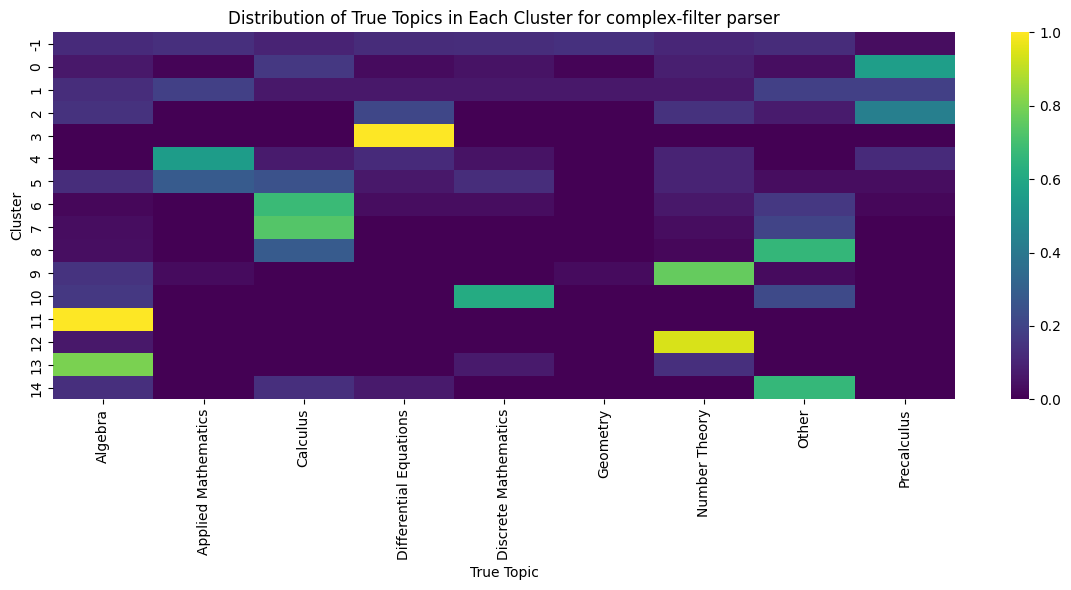

In [ ]:

for X_vec, name in zip(X_vecs, ['hybrid-math', 'complex-filter']):
  dbscan = DBSCAN(eps=best_eps[name], min_samples=best_min_samples[name])
  labels_dbscan = dbscan.fit_predict(X_vec)

  print(f"Top terms per DBSCAN cluster (excluding noise) for {name} parser:")
  #vocab = vectorizer.get_feature_names_out()

  for label in range(max(labels_dbscan)+1):
      # Get indices of data points belonging to the current cluster
      cluster_indices = np.where(labels_dbscan == label)[0]
      cluster_samples = X_vec[cluster_indices]

      if cluster_samples.shape[0] > 0:
          # Calculate the mean TF-IDF vector for the cluster
          mean_tfidf = np.array(cluster_samples.mean(axis=0))[0]

          # Sort terms by their mean TF-IDF score in descending order
          sorted_indices = np.argsort(mean_tfidf)[::-1]
          top_terms = [vocab[i] for i in sorted_indices[:10]]
          print(f"Cluster {label}:\t{top_terms}")
      else:
          print(f"Cluster {label}:\t(empty)")

  # Analyze noise points (label -1) if present
  if -1 in labels_dbscan:
      noise_indices = np.where(labels_dbscan == -1)[0]
      print(f"\nNumber of noise points: {len(noise_indices)}")
      print("Example noise points:",)
      maxind = min(10,len(noise_indices))
      for idx in range(maxind):
          print(f"  {idx}: {train_clust[idx]}")

  # Create a DataFrame to tabulate results
  df_vis = pd.DataFrame({
      'Cluster': labels_dbscan,
      'Topic': labels_clust
  })

  # Filter out noise if using DBSCAN (-1 means noise)
  #df_vis = df_vis[df_vis['Cluster'] != -1]

  # Create a contingency table (Cluster x Topic)
  cluster_topic_counts = pd.crosstab(df_vis['Cluster'], df_vis['Topic'])

  # Normalize rows for proportion visualization
  cluster_topic_props = cluster_topic_counts.div(cluster_topic_counts.sum(axis=1), axis=0)

  # Plot heatmap
  plt.figure(figsize=(12, 6))
  sns.heatmap(cluster_topic_props, annot=False, cmap="viridis", cbar=True)
  plt.title(f"Distribution of True Topics in Each Cluster for {name} parser")
  plt.xlabel("True Topic")
  plt.ylabel("Cluster")
  plt.tight_layout()
  plt.show()


  pca = PCA(n_components=3)
  reduced_features = pca.fit_transform(X_vec.toarray())
  '''
  fig = plt.figure(figsize=(10, 7))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=labels_dbscan, cmap='viridis')
  plt.title(f'PCA {name} parser')
  plt.show()
  '''
  # Interactive 3D scatter plot
  fig = go.Figure(data=[go.Scatter3d(
      x=reduced_features[:, 0],
      y=reduced_features[:, 1],
      z=reduced_features[:, 2],
      mode='markers',
      marker=dict(
          size=5,
          color=labels_dbscan,     # Color by cluster label
          colorscale='Viridis',
          opacity=0.8
      ),
      text=[f"Index: {i}" for i in range(len(labels_dbscan))]  # Optional: custom hover text
  )])

  fig.update_layout(
      title=f'PCA {name} parser',
      scene=dict(
          xaxis_title='PCA 1',
          yaxis_title='PCA 2',
          zaxis_title='PCA 3'
      ),
      margin=dict(l=0, r=0, b=0, t=40)
  )

  fig.show()

**Comments on DBSCAN**:
- Massive Noise: The most striking observation is the 7106 and 7156 noise points, which represents a very large portion of the 9000 samples (approximately 79%). This is the most significant indicator that DBSCAN is not effectively finding dense clusters.
- Fragmented and Specific Clusters: very high number of clusters (69, from 0 to 68, excluding noise). Many of these clusters are very small, containing only min_samples number of points or slightly more.
The top terms are extremely specific and often contain very precise mathematical notation.
- In a very high-dimensional and sparse space the distances between points tend to be large and less discriminative (curse of dimensionality).
This leads to most points being classified as noise because their neighborhoods don't meet the min_samples within the specified eps radius. However, PCA before DBSCAN is not really an option in this case since to mantain a decent variance explaination the dataset dimensions would not be reducing much.

## Hierarchical clustering

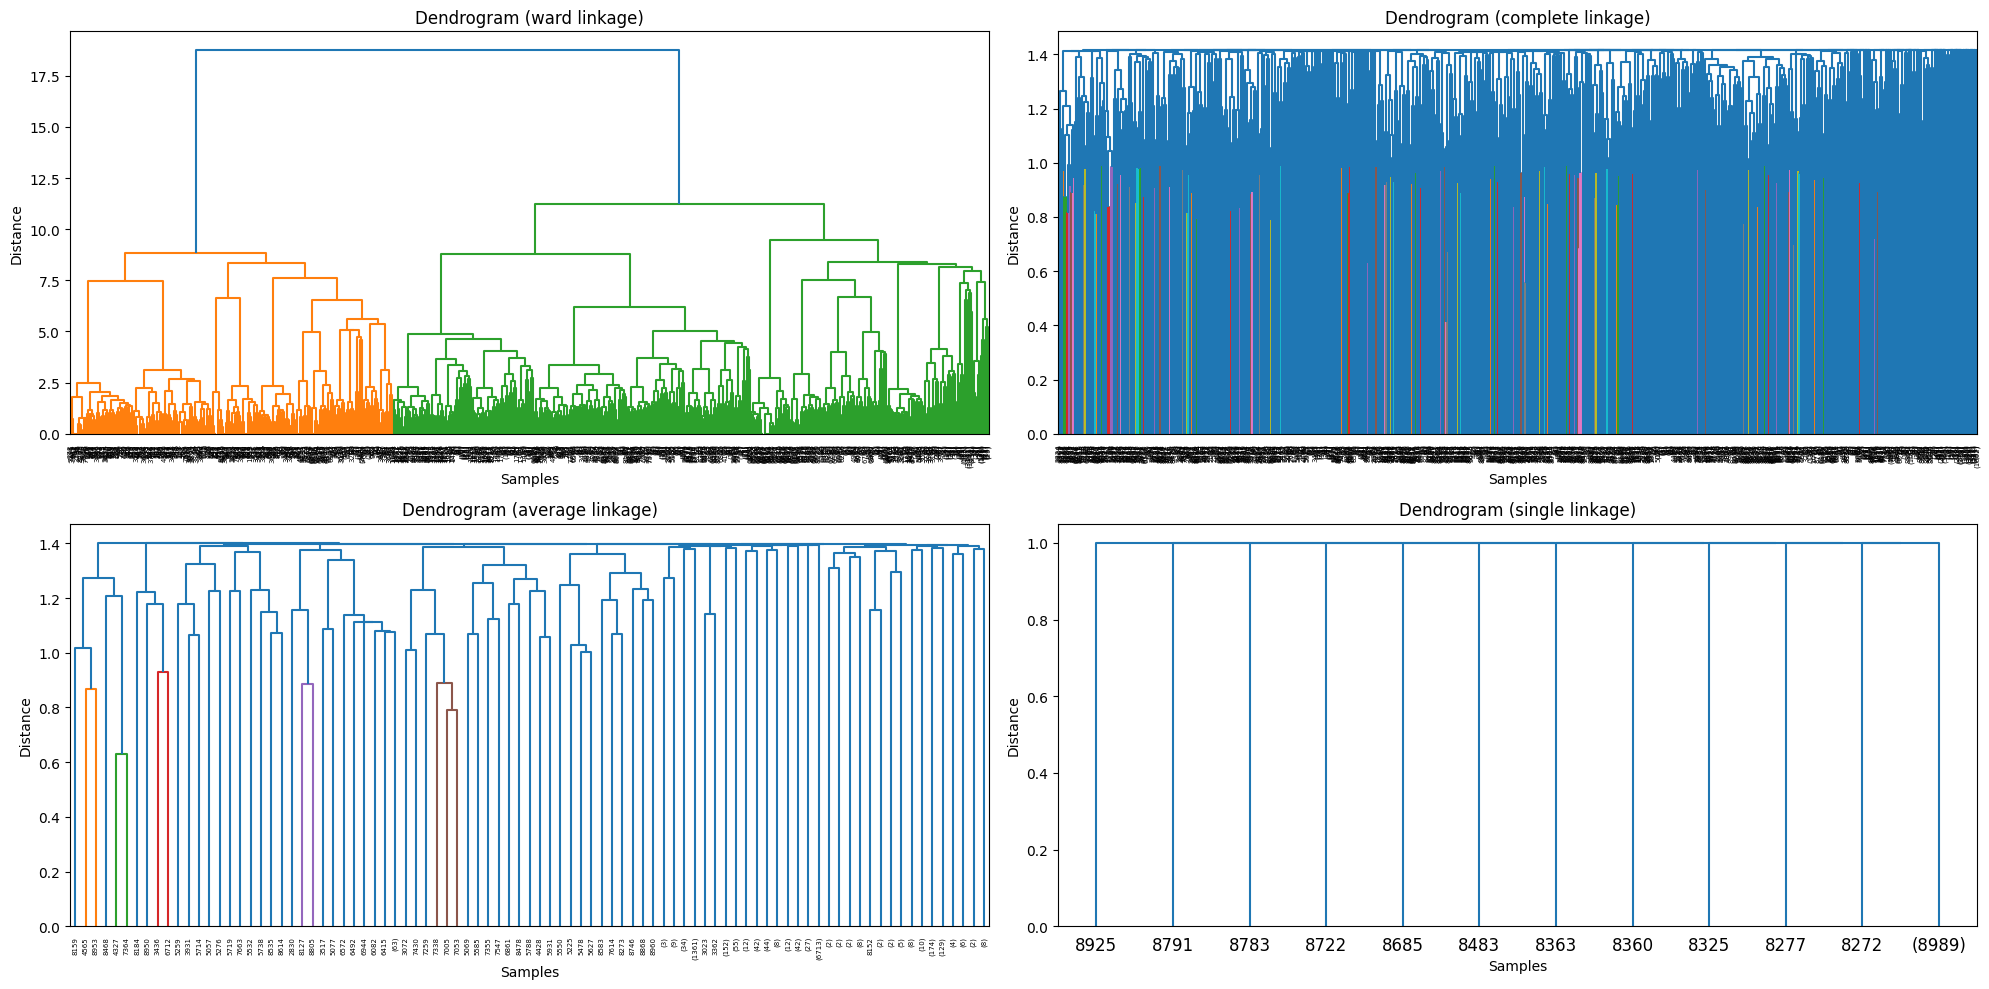

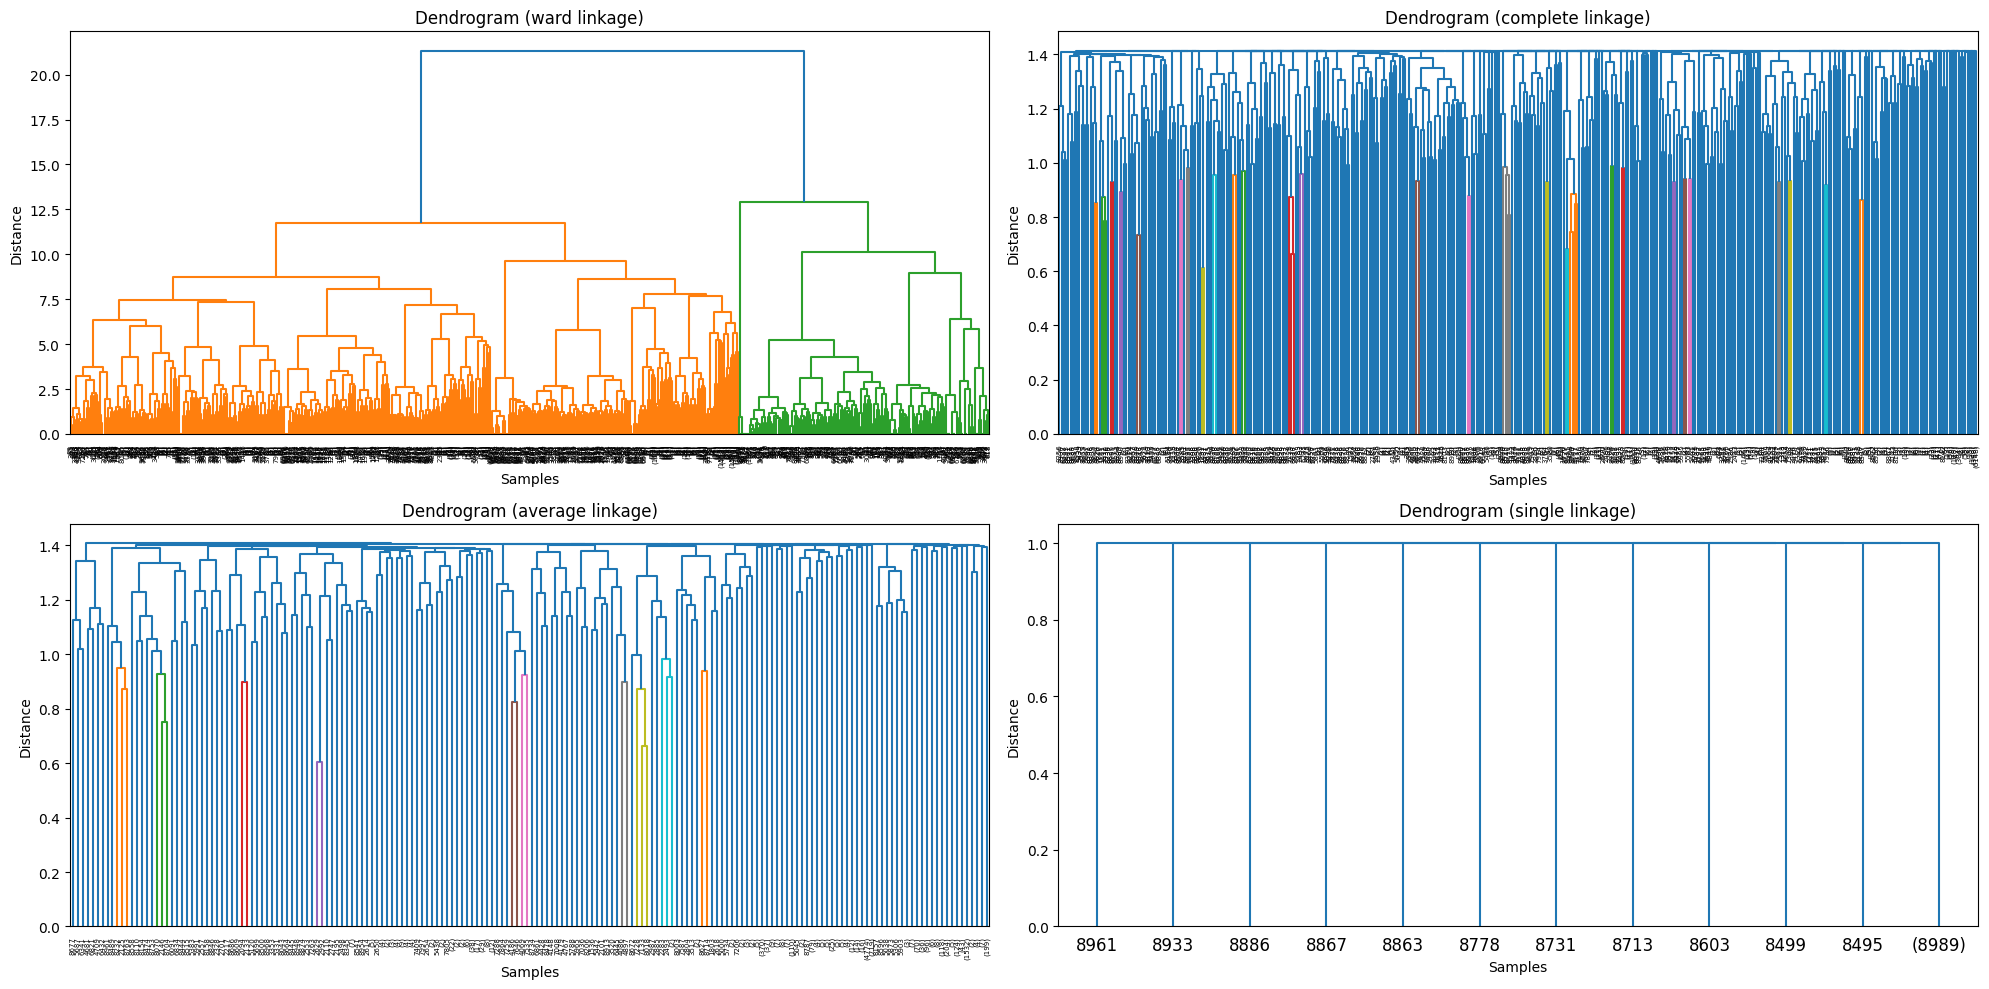

In [ ]:
# Linkage methods to compare
methods = ['ward', 'complete', 'average','single']

for X_vec, name in zip(X_vecs, ['hybrid-math', 'complex-filter']):
  # Plot each dendrogram
  plt.figure(figsize=(20, 10))

  for i, method in enumerate(methods):
      plt.subplot(2, 2, i + 1)
      linked = linkage(X_vec.toarray(), method=method)
      dendrogram(linked, truncate_mode='level', p=10)
      plt.title(f'Dendrogram ({method} linkage)')
      plt.xlabel('Samples')
      plt.ylabel('Distance')

  plt.tight_layout()
  plt.show()


In [ ]:
# Fit Agglomerative Clustering with Ward linkage
n_clusters = [3, 4]
linkages = ['ward'] * 2
df_out = {}
for n, name, X_vec, link  in zip(n_clusters, ['hybrid-math', 'complex-format'], X_vecs, linkages):
  model_hierarchical = AgglomerativeClustering(n_clusters=n, linkage=link)
  labels_hierarchical = model_hierarchical.fit_predict(X_vec.toarray())

  df_out[name] = pd.DataFrame({
      'cluster': labels_hierarchical,  # Clustering results
      'topic': labels_clust            # Topic labels
  })

  # Create a pivot table to visualize the distribution of topics across clusters
  topic_distribution = pd.crosstab(df_out[name]['cluster'], df_out[name]['topic'], rownames=['Cluster'], colnames=['Topic'])
  print(f'{name} parser\n\n', topic_distribution)

hybrid-math parser Topic    Algebra  Applied Mathematics  Calculus  Differential Equations  \
Cluster                                                                   
0            851                  961       771                     526   
1             18                    7       104                       9   
2            131                   32       125                     465   

Topic    Discrete Mathematics  Geometry  Number Theory  Other  Precalculus  
Cluster                                                                     
0                         925       938            865    909          253  
1                          32         0             37     26          679  
2                          43        62             98     65           68  
complex-format parser Topic    Algebra  Applied Mathematics  Calculus  Differential Equations  \
Cluster                                                                   
0              9                    2        46 

In [ ]:
for name, X_vec, vec, lab in zip(['hybrid-math', 'complex-filter'], X_vecs, vectorizers, labels_hierarchical):
  print(f"\n\nTop terms per hierarchical clusters with {name} parser:")
  vocab = vec.get_feature_names_out()

  for label in range(max(lab)+1):
      # Get indices of data points belonging to the current cluster
      cluster_indices = np.where(lab == label)[0]
      cluster_samples = X_vec[cluster_indices]
      print("------------------------------------------")

      if cluster_samples.shape[0] > 0:
          # Calculate the mean TF-IDF vector for the cluster
          mean_tfidf = np.array(cluster_samples.mean(axis=0))[0]

          # Sort terms by their mean TF-IDF score in descending order
          sorted_indices = np.argsort(mean_tfidf)[::-1]
          top_terms = [vocab[i] for i in sorted_indices[:10]]
          print(f"Cluster {label}:\t{top_terms}")
      else:
          print(f"Cluster {label}:\t(empty)")



Top terms per hierarchical clusters with hybrid-math parser:
------------------------------------------
Cluster 0:	['=', '+', '.', ',', 'equation', 'x', '-', 'y', 'differential', ':']
------------------------------------------
Cluster 1:	['limit', 'evaluate', ':', '\\to', '\\lim_{x', '\\infty}', '\\lim_{n', '\\lim_{x\\to', '-', '.']
------------------------------------------
Cluster 2:	['.', ',', '=', 'determine', '-', 'n', '?', 'x', 'number', '\\in']


Top terms per hierarchical clusters with complex-filter parser:
------------------------------------------
Cluster 0:	['limit:', "dir='-')]", 'oo,', 'evaluate', '+', 'x,', 'n,', 'calculate', "dir='+')]", '-']
------------------------------------------
Cluster 1:	['determine', '+', 'let', 'number', 'set', 'given', 'x]', 'function', 'value', 'space']
------------------------------------------
Cluster 2:	['limit:', 'evaluate', 'using', '{z_1,', 'disk.', 'distribute', 'distinct', 'distances', 'distance.', 'distance']
---------------------

1. **Hierarchical Clusters with Hybrid-Math Parser:**

- Cluster 0: This cluster seems to capture very general algebraic and equation-related questions, possibly including differential equations due to the term "differential". The basic mathematical symbols (=, '+', '.', ',', '-') and common variables (x, y) suggest fundamental algebraic structures.

- Cluster 1: This cluster strongly indicates questions related to calculus, specifically focusing on limits and evaluation. The terms "limit", "evaluate", the arrow notation (\\to), infinity (\\infty}), and the limit expressions (\\lim_{x', \\lim_{n', \\lim_{x\\to') are clear indicators.

- Cluster 2: This cluster appears to be a mix of general mathematical problem-solving and number-related questions. "determine", the question mark ('?'), 'n', "number", and the set membership symbol (\\in) suggest a variety of problems where finding a specific value or property of numbers or sets might be involved. The basic symbols (., ',', '=', '-') and the variable 'x' are also present.

2. **Hierarchical Clusters with Complex-Filter Parser:**

- Cluster 0: Similar to Cluster 1 from the "hybrid-math" parser, this cluster strongly suggests calculus questions involving limits and evaluation. The terms "limit:", "evaluate", infinity ("oo,"), and "calculate" are key. The directional indicators for limits ("dir='-')", "dir='+')") and the variables 'x,' and 'n,' further support this.

- Cluster 1: This cluster seems to capture more general mathematical problem-solving across various domains. "determine", "let", "number", "set", "given", "function", "value", and "space" are all common terms in mathematical problem statements and fundamental concepts.

- Cluster 2: This cluster also appears to be related to calculus and analysis, but with a potential focus on complex analysis or real analysis involving distances and distributions. The terms "limit:", "evaluate", "disk.", "distribute", "distinct", and the various forms of "distance" suggest concepts from these areas. The notation '{z_1,' might refer to a specific point in the complex plane.

- Cluster 3: This cluster seems to combine elements of algebra, calculus, and differential equations. "equation", "differential", "integral", "function", "evaluate", "determine", and "value" point to these areas. The basic symbols '+' and '-' and the common word "given" are also present.

**Comparison:**

Consistency in Identifying Calculus: Both parsers successfully identified clusters strongly related to calculus (Cluster 1 in "hybrid-math" and Cluster 0 in "complex-filter").

Difference in General Clusters: The "hybrid-math" parser has a very general algebraic/equation cluster (Cluster 0) and a more mixed number/set theory cluster (Cluster 2). The "complex-filter" parser has a more general problem-solving cluster (Cluster 1) and a cluster that mixes algebra, calculus, and differential equations (Cluster 3).

Emergence of Complex Analysis: The "complex-filter" parser identified a cluster (Cluster 2) that hints at complex analysis or advanced real analysis concepts with terms like '{z_1,' and "disk.". This is not as apparent in the "hybrid-math" results.

Level of Specificity: The "complex-filter" parser seems to have produced clusters that are potentially more specific in some areas (like the complex analysis hint), while the "hybrid-math" parser has broader, more general clusters.

In [ ]:
print(df_out)

{'hybrid-math':       cluster                 topic
0           1           Precalculus
1           1           Precalculus
2           1           Precalculus
3           1           Precalculus
4           1           Precalculus
...       ...                   ...
8995        2  Discrete Mathematics
8996        2  Discrete Mathematics
8997        0  Discrete Mathematics
8998        0  Discrete Mathematics
8999        0  Discrete Mathematics

[9000 rows x 2 columns], 'complex-format':       cluster                 topic
0           0           Precalculus
1           0           Precalculus
2           0           Precalculus
3           0           Precalculus
4           2           Precalculus
...       ...                   ...
8995        3  Discrete Mathematics
8996        3  Discrete Mathematics
8997        1  Discrete Mathematics
8998        1  Discrete Mathematics
8999        1  Discrete Mathematics

[9000 rows x 2 columns]}


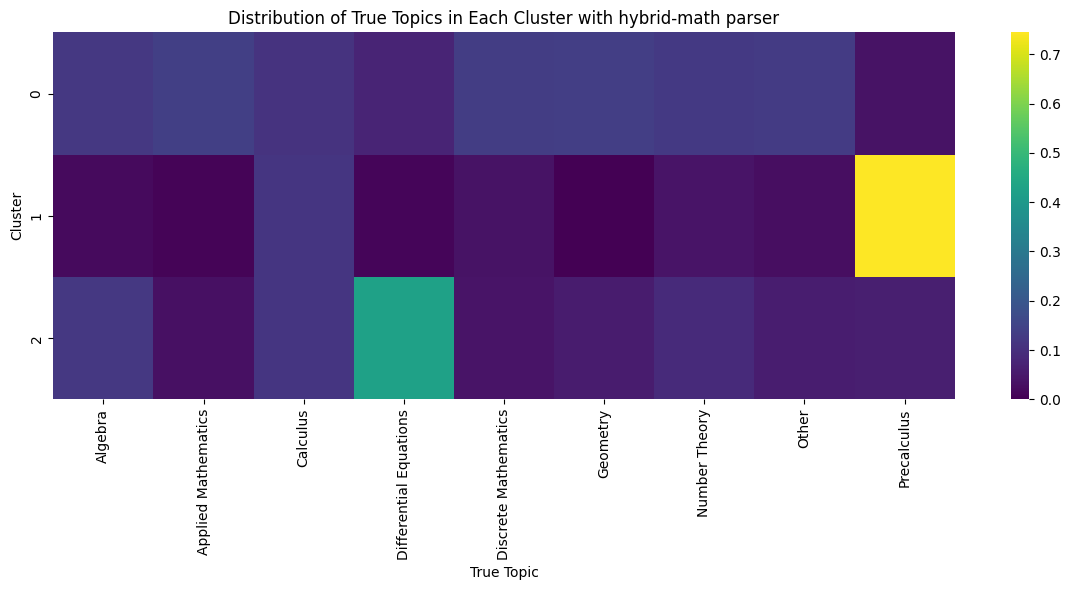

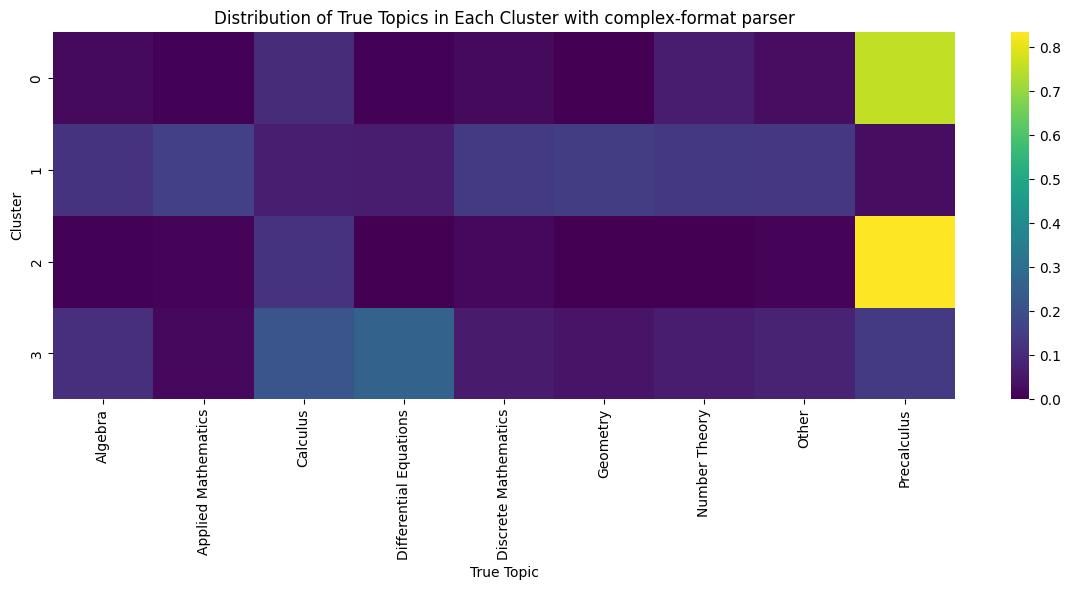

In [ ]:
for name, df_vis in df_out.items():
  # Create a contingency table (Cluster x Topic)
  cluster_topic_counts = pd.crosstab(df_vis['cluster'], df_vis['topic'])

  # Normalize rows for proportion visualization
  cluster_topic_props = cluster_topic_counts.div(cluster_topic_counts.sum(axis=1), axis=0)

  # Plot heatmap
  plt.figure(figsize=(12, 6))
  sns.heatmap(cluster_topic_props, annot=False, cmap="viridis", cbar=True)
  plt.title(f"Distribution of True Topics in Each Cluster with {name} parser")
  plt.xlabel("True Topic")
  plt.ylabel("Cluster")
  plt.tight_layout()
  plt.show()


In [ ]:
for X_vec, (name, df_vis) in zip(X_vecs, df_out.items()):
  pca = PCA(n_components=3)
  reduced_features = pca.fit_transform(X_vec.toarray())

  c_labels = np.asarray(df_vis['cluster'])

  # Create interactive 3D scatter plot
  fig = go.Figure(data=[go.Scatter3d(
      x=reduced_features[:, 0],
      y=reduced_features[:, 1],
      z=reduced_features[:, 2],
      mode='markers',
      marker=dict(
          size=5,
          color=c_labels,
          colorscale='Viridis',
          opacity=0.8,
          colorbar=dict(title="Cluster")
      ),
      text=[f"Index: {i}, Cluster: {label}" for i, label in enumerate(c_labels)]
  )])

  fig.update_layout(
      title=f'PCA with {name} parser',
      scene=dict(
          xaxis_title='PCA 1',
          yaxis_title='PCA 2',
          zaxis_title='PCA 3'
      ),
      margin=dict(l=0, r=0, b=0, t=40)
  )

  fig.show()

## LDA

In [ ]:
# Vectorize the text
tokenizer = Tokenizer('hybrid-math', "allenai/longformer-base-4096", remove_numbers=True)
vectorizer_hybrid_math = CountVectorizer(tokenizer=tokenizer.parse, lowercase=True, token_pattern=None, max_df=0.5, min_df=5, stop_words='english')
X_vec_hybrid_math = vectorizer_hybrid_math.fit_transform(train_clust)

tokenizer = Tokenizer('complex-filter', "allenai/longformer-base-4096", remove_numbers=True)
vectorizer_complex_filter = CountVectorizer(tokenizer=tokenizer.parse, lowercase=True, token_pattern=None, max_df=0.5, min_df=5, stop_words='english')
sys.set_int_max_str_digits(20000)
X_vec_complex_filter = vectorizer_complex_filter.fit_transform(train_clust)

X_vecs = [X_vec_hybrid_math, X_vec_complex_filter]
vectorizers = [vectorizer_hybrid_math, vectorizer_complex_filter]

for v in vectorizers:
  vocab = v.get_feature_names_out()
  print("Vocab length:", len(vocab))

Vocab length: 2533
Vocab length: 2788


In [ ]:
LDAs = {}
for X_vec, name in zip(X_vecs, ['hybrid-math', 'complex-filter']):
  lda = LatentDirichletAllocation(n_components=5, verbose=1, learning_method='online', max_iter=30)
  lda.fit(X_vec)
  LDAs[name] = lda

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_it

In [ ]:
# Most important terms for each topic (n=3000)
for name, lda in LDAs.items():
  print(f'\n{name} parser')
  for i in range(len(lda.components_)):
      sorted_terms = lda.components_[i].argsort()[::-1]
      concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
      print (f'Topic {i + 1}:\t', concatenated_terms)


hybrid-math parser
Topic 1:	 [(x,, (p, symbols, (r, topology, f(1))], generator, h], straight, domain]
Topic 2:	 [previous, moves, 'false'., orientable, 'true', parametric, (y,, domain, usual, standard]
Topic 3:	 [(x,, (n,, maximal, 'yes', domain, moves, (r, certain, (p, near]
Topic 4:	 [Eq(r,, (y,, symbols, laplace, (x,, (r, q, domain, linearly, real]
Topic 5:	 [(with, lebesgue, f(z)], arbitrarily, Eq(t(1),, order,, (r, integrable, (p, Eq(y_2,]

complex-filter parser
Topic 1:	 [evaluate, limit:, oo,, prime, n,, using, numbers, x,, -, limit]
Topic 2:	 [number, determine, given, probability, random, calculate, point, value, n], let]
Topic 3:	 [<=, <, &, positive, integer, determine, given, equation, integers, number]
Topic 4:	 [+, -, equation, value, given, differential, determine, x, integral, Eq(y,]
Topic 5:	 [let, determine, function, set, x], does, space, exists, consider, provide]


1. **LDA Topics with hybrid-math parser (5 Topics)**:

- Topic 1: This topic is a mix of common variable notations ((x,, (p, (r, h]), abstract mathematical concepts like "symbols" and "topology," and words like "generator," "straight," and "domain." It's highly fragmented and doesn't point to a clear, singular mathematical domain.
- Topic 2: This topic contains some generic words ("previous," "moves," "usual," "standard"), boolean values ('false'., 'true'), and terms that might hint at geometry/topology ("orientable," "parametric," "domain"). It's a very mixed bag, lacking strong thematic coherence.
- Topic 3: Similar to Topic 1, this is largely composed of variable notations ((x,, (n,, (r, (p), generic qualifiers ("maximal," "certain," "near"), a boolean value ('yes'), and "domain." It's uninterpretable as a distinct mathematical topic.
Topic 4: This topic includes equation notation (Eq(r,), variable notations ((y,, (x,, (r, q), "symbols," "domain," and hints of linear algebra ("linearly," "real") and differential equations/transforms ("laplace").
Topic 5: This topic contains an important analysis term ("lebesgue"), complex function notation (f(z)]), general qualifiers ("arbitrarily," "order,"), equation notation (Eq(t(1),, Eq(y_2,), and "integrable." This topic attempts to capture concepts from real/complex analysis but is still hindered by the generic (with, (r, (p tokens.

The LDA results with the "hybrid-math" parser are poor. The topics are largely incoherent and dominated by low-level, unsemantic syntactic fragments. This reinforces the consistent finding from K-Means and hierarchical clustering: this vectorizer is not suitable for extracting meaningful thematic information from mathematical text.

2. **LDA Topics with complex-filter parser (5 Topics)**:

- Topic 1: Calculus - Limits & Number Theory: This topic clearly focuses on calculus, specifically limits (limit:, oo,, limit, evaluate, x,, n,). However, it also includes strong number theory terms (prime, numbers). This indicates a potential overlap or that problems involving numbers are frequently linked to limit evaluations in this dataset.
- Topic 2: Probability & General Calculation: This topic combines terms from probability and statistics (probability, random). It also includes general problem-solving terms ("number," "determine," "given," "calculate," "value," "let"), suggesting problems that involve calculation or finding a specific value in a probabilistic context.
- Topic 3: Number Theory: This topic points strongly to number theory (integer, integers, positive, number) and problems involving inequalities (<=, <). The inclusion of "equation" and "determine" suggests tasks where properties of numbers are used to solve equations or determine values within certain constraints.
- Topic 4: Algebra & Differential Equations / Integral: This is a very coherent topic encompassing general algebra (+, -, equation, x), differential equations (differential, Eq(y,), and integral calculus (integral). It groups core computational and equation-solving problems across these domains.
- Topic 5: General Problems: This topic acts as a "foundational" category. It captures common problem initiation phrases ("let," "determine," "consider," "provide") and key mathematical entities ("function," "set," "space").

The topics are generally coherent, interpretable, and distinct, aligning well with different branches of mathematics.


hybrid-math parser


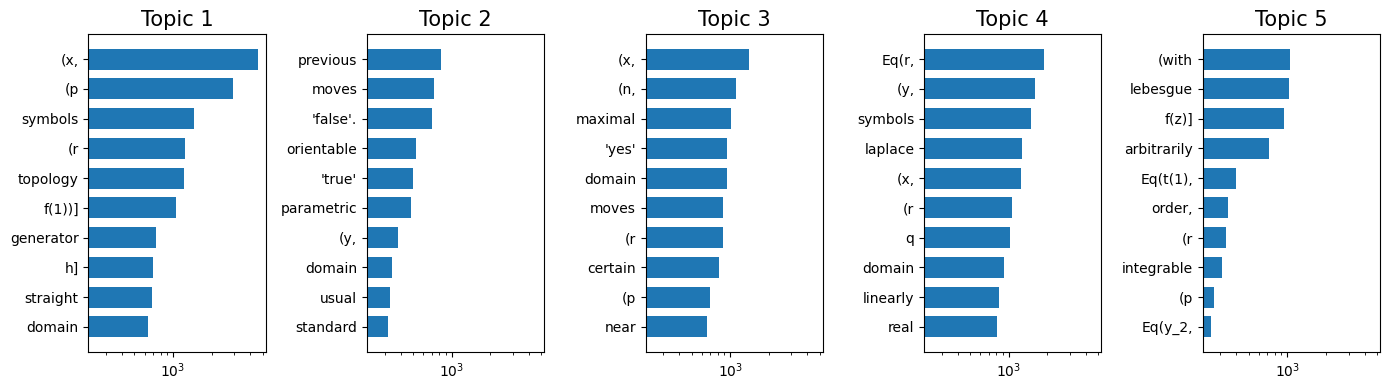


complex-filter parser


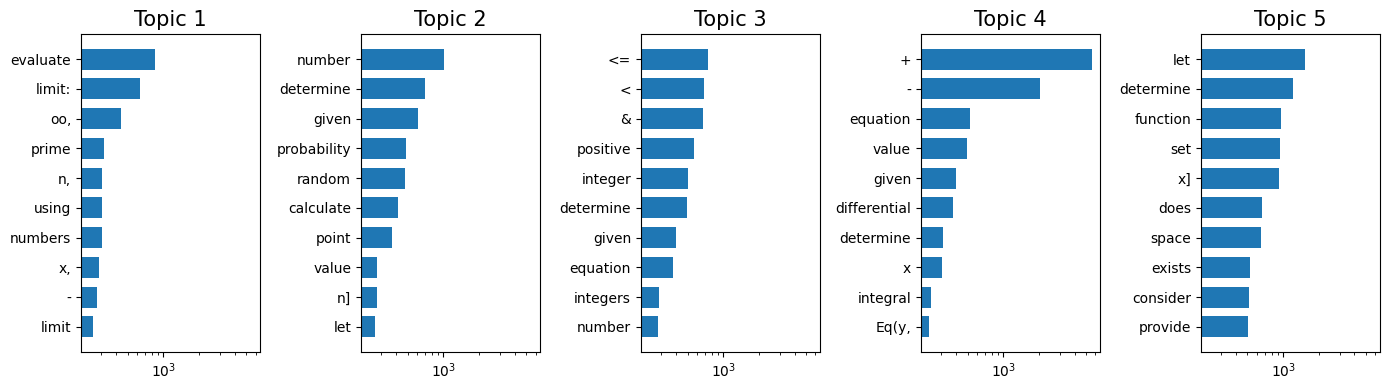

In [ ]:
for name, lda in LDAs.items():
  print(f'\n{name} parser')
  num_words = 10
  cols = 5
  rows = int(len(lda.components_)/5)

  fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
  axes = axes.flatten()
  for topic_idx, topic in enumerate(lda.components_):
      top_terms_index = topic.argsort()[:-num_words - 1:-1]
      top_terms = [vocab[i] for i in top_terms_index]
      weights = topic[top_terms_index]
      ax = axes[topic_idx]
      ax.barh(top_terms, weights, height=0.7)
      ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
      ax.invert_yaxis()
      ax.set_xscale('log')

  plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
  plt.tight_layout()
  plt.show()

In [ ]:
# Analyse one document in particular
doc = train_clust[1160]
print('Analysing the document:\n', doc)

for vectorizer, lda, name in zip(vectorizers, LDAs.values(), ['hybrid-math', 'complex-filter']):
  print(f'{name} parser')
  doc_vec = vectorizer.transform([doc])[0]
  topic_vec = lda.transform(doc_vec)[0]
  print(topic_vec)

  sorted_topics = topic_vec.argsort()[::-1]
  sorted_prevalence = sorted(topic_vec)[::-1]

  # Relevance and top terms for the question for each topic
  for i in range(len(sorted_prevalence)):
      if sorted_prevalence[i] < .01: break
      topic = sorted_topics[i]
      sorted_terms = np.flip(lda.components_[topic].argsort())
      print (f'{100 * sorted_prevalence[i]:.1f}% Topic {topic}: {" ".join(vocab[i] for i in sorted_terms[:10])}')

Analysing the document:
 Solve the differential equation \(( D^4 + 6 D^3 + 9 D^2) y=0\), where \(D = \frac{d}{dx}\), with the initial conditions \(x=0,  y=0,  y'=0,  y''= 6\), and the asymptotic condition that as \(x\) tends to \(+\infty\), \(y'\) tends to \(1\). Find the value of \(y\) when \(x = 1\).
hybrid-math parser
[0.78647813 0.0083404  0.18843145 0.00837594 0.00837408]
78.6% Topic 0: (x, (p symbols (r topology f(1))] generator h] straight domain
18.8% Topic 2: (x, (n, maximal 'yes' domain moves (r certain (p near
complex-filter parser
[0.01000039 0.01001481 0.16316615 0.60505013 0.21176851]
60.5% Topic 3: + - equation value given differential determine x integral Eq(y,
21.2% Topic 4: let determine function set x] does space exists consider provide
16.3% Topic 2: <= < & positive integer determine given equation integers number
1.0% Topic 1: number determine given probability random calculate point value n] let
1.0% Topic 0: evaluate limit: oo, prime n, using numbers x, - limit


#### LDA Optimization

In [ ]:

documents_train, documents_test= train_test_split(train_clust, test_size=0.2, random_state=11)
print('No. training docs:', len(documents_train))
print('No. testing docs:', len(documents_test))

tokenizer = Tokenizer('hybrid-math', "allenai/longformer-base-4096", remove_numbers=True)
vectorizer_hybrid_math = CountVectorizer(tokenizer=tokenizer.parse, lowercase=True, token_pattern=None, max_df=0.5, min_df=5, stop_words='english')
X_vec_hybrid_math_train = vectorizer_hybrid_math.fit_transform(documents_train)
X_vec_hybrid_math_test = vectorizer_hybrid_math.fit_transform(documents_test)

tokenizer = Tokenizer('complex-filter', "allenai/longformer-base-4096", remove_numbers=True)
vectorizer_complex_filter = CountVectorizer(tokenizer=tokenizer.parse, lowercase=True, token_pattern=None, max_df=0.5, min_df=5, stop_words='english')
sys.set_int_max_str_digits(20000)
X_vec_complex_filter_train = vectorizer_complex_filter.fit_transform(documents_train)
X_vec_complex_filter_test = vectorizer_complex_filter.fit_transform(documents_test)

X_vecs_train = [X_vec_hybrid_math_train, X_vec_complex_filter_train]
X_vecs_test = [X_vec_hybrid_math_test, X_vec_complex_filter_test]
vectorizers = [vectorizer_hybrid_math, vectorizer_complex_filter]

for v in vectorizers:
  vocab = v.get_feature_names_out()
  print("Vocab length:", len(vocab))

No. training docs: 7200
No. testing docs: 1800
Vocab length: 808
Vocab length: 820



--- Evaluating LDA for hybrid-math parser ---
  Training LDA for 5 topics...
  Number of Topics: 5, Perplexity: 4208.3983
  Training LDA for 6 topics...
  Number of Topics: 6, Perplexity: 4201.7922
  Training LDA for 7 topics...
  Number of Topics: 7, Perplexity: 4799.4073
  Training LDA for 8 topics...
  Number of Topics: 8, Perplexity: 4930.8355
  Training LDA for 9 topics...
  Number of Topics: 9, Perplexity: 5283.9710
  Training LDA for 10 topics...
  Number of Topics: 10, Perplexity: 5286.5237


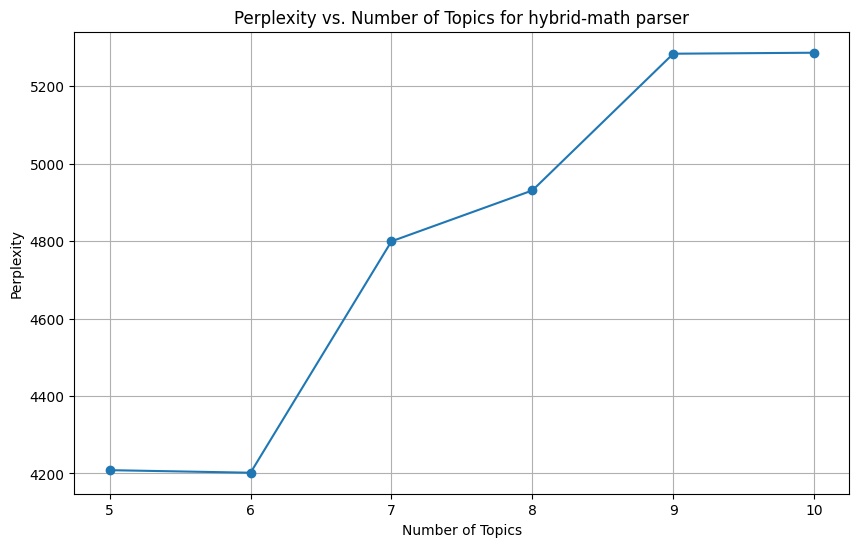


--- Evaluating LDA for complex-filter parser ---
  Training LDA for 5 topics...
  Number of Topics: 5, Perplexity: 14627.5805
  Training LDA for 6 topics...
  Number of Topics: 6, Perplexity: 15407.2809
  Training LDA for 7 topics...
  Number of Topics: 7, Perplexity: 16445.5519
  Training LDA for 8 topics...
  Number of Topics: 8, Perplexity: 17747.8497
  Training LDA for 9 topics...
  Number of Topics: 9, Perplexity: 18446.8848
  Training LDA for 10 topics...
  Number of Topics: 10, Perplexity: 19457.1600


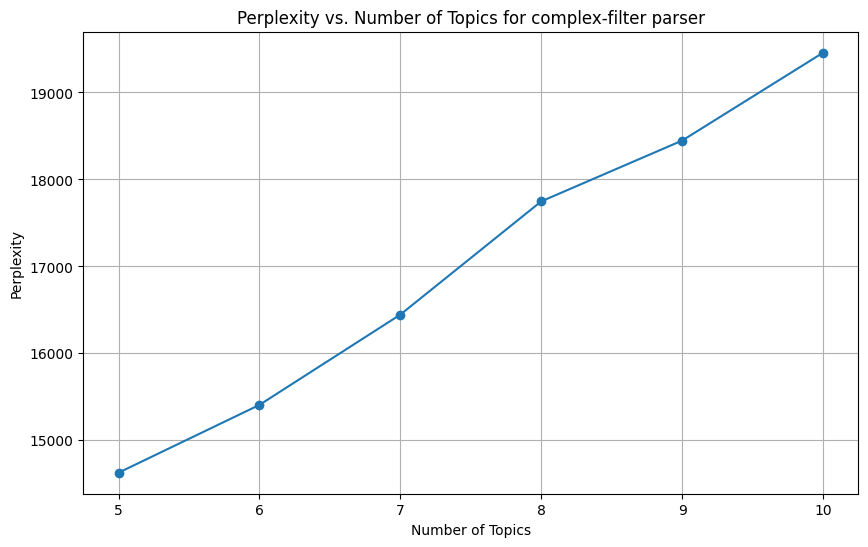

In [ ]:
# Define the range of topics to explore
topic_range = [5, 6, 7, 8, 9, 10,]
all_results = []

# Loop through each vectorizer's data
for i, (vector_documents_train, vector_documents_test) in enumerate(zip(X_vecs_train, X_vecs_test)):
    parser_name = ['hybrid-math', 'complex-filter'][i] # Get the parser name

    print(f"\n--- Evaluating LDA for {parser_name} parser ---")

    # Store results for the current parser
    parser_perplexity_values = {}

    for n_topics in topic_range:
        print(f"  Training LDA for {n_topics} topics...")
        lda = LatentDirichletAllocation(n_components=n_topics,
                                        verbose=0, # Set to 1 for more verbose output during training
                                        learning_method='online',
                                        max_iter=40, # Increase max_iter if convergence is an issue
                                        random_state=seed,
                                        n_jobs=-1) # Use all available CPU cores for faster training

        lda.fit(vector_documents_train) # Fit on training data

        # Evaluate perplexity on the test set
        perplexity = lda.perplexity(vector_documents_test)
        parser_perplexity_values[n_topics] = perplexity

        print(f"  Number of Topics: {n_topics}, Perplexity: {perplexity:.4f}")

        # Store results for later analysis in a structured way
        all_results.append({
            'parser': parser_name,
            'n_topics': n_topics,
            'perplexity': perplexity,
        })

    # Plot perplexity for the current parser after all topic counts are done
    plt.figure(figsize=(10, 6))
    plt.plot(list(parser_perplexity_values.keys()), list(parser_perplexity_values.values()), marker='o')
    plt.xlabel("Number of Topics")
    plt.ylabel("Perplexity")
    plt.title(f"Perplexity vs. Number of Topics for {parser_name} parser")
    plt.xticks(topic_range)
    plt.grid(True)
    plt.show()

## TSNE

To explore the semantic structure of the mathematical questions in the dataset, we used the [`all-MiniLM-L12-v2`](https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2) sentence transformer to generate dense vector embeddings. This model offers a good trade-off between speed and embedding quality, making it suitable for large-scale analysis. A random sample of 100 questions was selected, encoded into fixed-size embeddings, and then projected into 3D space using t-SNE for visualization. This helped reveal clusters and semantic groupings among questions based on their textual similarity. Each point in the 3D plot corresponds to a question, labeled by index for reference.

In [ ]:
sentence_transformer_model_name = "all-MiniLM-L12-v2"

sentence_to_visualize = 100

model = SentenceTransformer(sentence_transformer_model_name)
# Take random indices between 0 and NUM_SAMPLES of size 100
random_indices = random.sample(range(NUM_SAMPLES), sentence_to_visualize)
sentences = train_ds_qs.iloc[random_indices].tolist()
embeddings = model.encode(sentences)

In [ ]:
# for nbformat errors: https://stackoverflow.com/questions/66557543/valueerror-mime-type-rendering-requires-nbformat-4-2-0-but-it-is-not-installed

# Reduce to 3D
embeddings_3d = TSNE(n_components=3, perplexity=5.0 if len(sentences) < 30 else 30.0).fit_transform(embeddings)
# Map to indexes ase sentences in space are not readable
indices = [f"#{i}" for i in range(len(sentences))]

# 4. Plot
fig = px.scatter_3d(
    x=embeddings_3d[:, 0],
    y=embeddings_3d[:, 1],
    z=embeddings_3d[:, 2],
    text=indices,
    title="3D Sentence Embeddings (Index View)",
)
fig.show()

# 5. Print index-to-sentence mapping
for i, s in enumerate(sentences):
    print(f"{i}: {s}")

0: Suppose $f(x)$ and $g(x)$ are continuous, differentiable, positive, and monotone decreasing functions such that $\lim_{x \to \infty} f(x) = \lim_{x \to \infty} g(x) = 0$. If $\int_0^\infty |g(x)-f(x)| \, dx=0$, does it imply that $f(x) = g(x)$ for all $x$? Answer 'yes' or 'no' and justify your answer.
1: Determine whether the sequence \( \{(\sin^2(3+\sin(n)))^n\} \) converges or diverges. If it converges, find its limit.
2: Calculate the value of \( 718^{143} \mod 1260 \).
3: Determine the nature of the singular point \( z = 0 \) of the function \( f(z)=\frac{1}{2+z^{2}-2 \operatorname{ch} z} \).
4: Evaluate the integral: $$\int_{-\pi}^{\pi} \ln (\cos x +\sqrt{1+\cos^2 x}) \, dx$$
5: What is the smallest possible real value of $x^2 + 8x$?
6: If the famous baseball player for the San Francisco Midgets, Larry Ponds, has a $\frac{2}{5}$ chance of earning a walk on each plate appearance, what is the probability that he will earn a walk exactly once in his next two plate appearances? Exp

Discover the most close sentences with cosine distance

In [ ]:


# Assume `embeddings` is a (n_sentences x embedding_dim) array from SBERT
D = cosine_distances(embeddings)

# Set diagonal to infinity to ignore self-distances (which are zero)
np.fill_diagonal(D, np.inf)

# Flatten, sort, and retrieve the smallest distances
n = len(embeddings)
pairs = [(i, j, D[i, j]) for i in range(n) for j in range(i+1, n)]
top_10 = sorted(pairs, key=lambda x: x[2])[:10]

# Print results
for i, j, dist in top_10:
    print(f"Pair #{i} ↔ #{j} | Distance: {dist:.4f}")

Pair #30 ↔ #87 | Distance: 0.4111
Pair #51 ↔ #74 | Distance: 0.4119
Pair #15 ↔ #25 | Distance: 0.4430
Pair #11 ↔ #80 | Distance: 0.4455
Pair #29 ↔ #79 | Distance: 0.4541
Pair #5 ↔ #16 | Distance: 0.4729
Pair #20 ↔ #42 | Distance: 0.4804
Pair #56 ↔ #69 | Distance: 0.5020
Pair #10 ↔ #72 | Distance: 0.5217
Pair #44 ↔ #97 | Distance: 0.5278


### Interpretation of the Results

- **Pairing by Semantic Distance:**  
  The output lists matched question pairs (e.g., **#30 ↔ #87**) along with their **distance score** (e.g., 0.4111), indicating how close they are in the embedding space. Smaller values denote higher semantic similarity.

- **Content Overlap Examples:**
  - **#30 ↔ #87**: Both are complex analysis questions involving **contour integrals** with rational functions—likely yielding similar embeddings.
  - **#15 ↔ #25**: Both involve **roots of polynomials**, possibly with deeper algebraic structures.
  - **#11 ↔ #80**: Inequalities involving parameters—likely prompting similar reasoning strategies.
  - **#5 ↔ #16**: Optimization-related questions over real numbers.
  - **#29 ↔ #79**: Both involve **line or surface integrals** in vector fields—applications of **Stokes' theorem** and **Green’s theorem**.
  - **#44 ↔ #97**: Both concern **triangle geometry** with trigonometric identities or constraints.


# Learning from data

## M1C: Topic Classification

To establish a strong baseline for topic classification, we trained and compared multiple classical machine learning classifiers using TF-IDF vectorized question text. A custom tokenizer (`hybrid-math`) was used to preserve the structure of mathematical expressions. The dataset was stratified into training and test splits, and label frequencies were used to compute inverse-frequency class weights. Five classifiers—LinearSVC, SGD (hinge and log), Logistic Regression, and Multinomial Naive Bayes—were evaluated on accuracy and macro-F1 scores. The model with the highest macro-F1 score was selected as the best performer.

### Fitting models

In [ ]:
PARSER = 'hybrid-math'

In [ ]:
print('Working on', train_ds_qs.shape, 'samples')

Working on (20000,) samples


fitted: LinearSVC(max_iter=10000)
fitted: SGDClassifier(class_weight='balanced', max_iter=10000)
fitted: SGDClassifier(class_weight='balanced', loss='log_loss', max_iter=10000)
fitted: LogisticRegression(max_iter=1000, n_jobs=-1)
fitted: MultinomialNB()


model  accuracy  macro_f1
2             SGD-log   0.51400  0.373188
0           LinearSVC   0.59550  0.366134
1           SGD-hinge   0.51000  0.364484
3  LogisticRegression   0.57000  0.303920
4       MultinomialNB   0.39675  0.115594

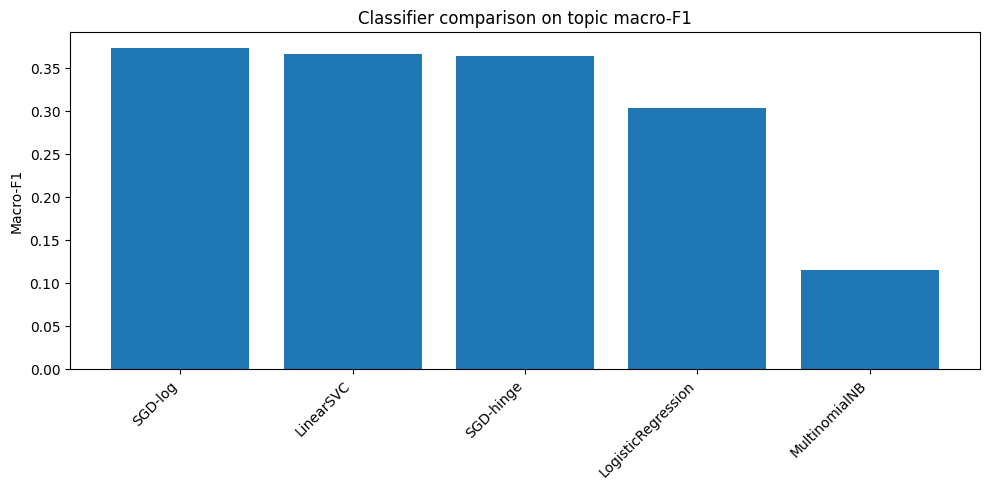

Best model: SGD-log
Accuracy: 0.514
Macro-F1: 0.37318796523188663
Best model class: <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>


In [ ]:
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    train_ds_qs, train_ds_tp,
    test_size=0.2, random_state=seed,
    stratify=train_ds_tp
)

# 2. Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test  = le.transform(y_test_raw)

counts = Counter(y_train)
total = len(y_train)

# Inverse‐frequency weights
weights = {cls: total/(len(counts)*cnt) for cls, cnt in counts.items()}

# 3. Select tokenizer
tokenizer = Tokenizer(PARSER, "allenai/longformer-base-4096", remove_numbers=True)

# 4. Define a suite of classifiers to compare
classifiers = {
    "LinearSVC":             LinearSVC(max_iter=10000),
    "SGD-hinge":             SGDClassifier(loss="hinge", class_weight="balanced", max_iter=10000),
    "SGD-log":               SGDClassifier(loss="log_loss",  class_weight="balanced", max_iter=10000),
    "LogisticRegression":    LogisticRegression(max_iter=1000, n_jobs=-1),
    "MultinomialNB":         MultinomialNB(),
}

classifiers_classes = {
    "LinearSVC":             LinearSVC,
    "SGD-hinge":             SGDClassifier,
    "SGD-log":               SGDClassifier,
    "LogisticRegression":    LogisticRegression,
    "MultinomialNB":         MultinomialNB,
}

vectorizer =  TfidfVectorizer(
    tokenizer=tokenizer.parse,
    lowercase=True,
    token_pattern=None
)
X_train_vectorized =  vectorizer.fit_transform(X_train)
X_test_vectorized =  vectorizer.transform(X_test)

# 5. Train, predict, record metrics
results = []
for name, clf in classifiers.items():
    clf.fit(X_train_vectorized, y_train)
    print("fitted:",clf)
    yp = clf.predict(X_test_vectorized)
    results.append({
        "model":    name,
        "accuracy": accuracy_score(y_test, yp),
        "macro_f1": f1_score(y_test, yp, average="macro")
    })

df = pd.DataFrame(results).sort_values("macro_f1", ascending=False)
display(df)

# 6. Plot macro-F1 for easy comparison
plt.figure(figsize=(10,5))
plt.bar(df["model"], df["macro_f1"])
plt.ylabel("Macro-F1")
plt.xticks(rotation=45, ha="right")
plt.title("Classifier comparison on topic macro-F1")
plt.tight_layout()
plt.show()

# Find the best model based on macro_f1
best_result = max(results, key=lambda x: x["macro_f1"])
best_model_name = best_result["model"]

print(f"Best model: {best_model_name}")
print(f"Accuracy: {best_result['accuracy']}")
print(f"Macro-F1: {best_result['macro_f1']}")

# Retrieve the corresponding classifier from the classifiers dictionary
best_model_class = classifiers_classes[best_model_name]
print(f"Best model class: {best_model_class}")



The evaluation compared five classical classifiers for topic prediction using TF-IDF features. The best performance was achieved by `SGD-log`, with a macro-F1 score of 0.373, indicating strong balanced performance across classes. While `LinearSVC` had slightly higher accuracy, it underperformed on macro-F1. Simpler models like `MultinomialNB` showed significantly weaker results.


### Tune the best model with `Optuna`

In [ ]:
X       = train_ds_qs
y_raw   = train_ds_tp
le      = LabelEncoder()
y       = le.fit_transform(y_raw)

N_TRIALS = 2

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=seed,
    stratify=y
)

counts = Counter(y_train)
total  = len(y_train)
n_cls  = len(counts)
weights = {
    cls : total/(n_cls * count)
    for cls, count in counts.items()
}

def objective(trial):
    # TF–IDF params
    ngram_min    = trial.suggest_int("ngram_min", 1, 2)
    ngram_max    = trial.suggest_int("ngram_max", ngram_min, 3)
    max_df       = trial.suggest_float("max_df", 0.5, 1.0)
    min_df       = trial.suggest_int("min_df", 1, 5)
    #max_features = int(trial.suggest_int("max_features", 10_000, 50_000, step=5_000))

    max_iter = 10000
    if best_model_name == "LinearSVC":
        C            = trial.suggest_float("C", 1e-4, 1e2, log=True)
        weight_choice = trial.suggest_categorical("weight_choice", ["none", "custom"])
        if weight_choice == "none":
            class_weight = None
        else:
            class_weight = weights
        loss         = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
        dual         = True if loss == "hinge" else False
        model = best_model_class(
            C,
            class_weight=class_weight,
            loss=loss,
            dual=dual,
            max_iter=max_iter,
            random_state=seed
        )
    elif best_model_name in ["SGD-hinge", "SGD-log"]:
        loss         = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
        weight_choice = trial.suggest_categorical("weight_choice", ["none", "custom"])
        if weight_choice == "none":
            class_weight = None
        else:
            class_weight = weights
        model = best_model_class(
            class_weight=class_weight,
            loss=loss,
            max_iter=max_iter,
            random_state=seed
        )
    elif best_model_name == "LogisticRegression":
        model = best_model_class(
            max_iter=max_iter,
            n_jobs = 1
        )
    elif best_model_name == "MultinomialNB":
        model = best_model_class(
        )
    else:
        raise RuntimeError('not impl')


    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(
             tokenizer=tokenizer.parse,
             lowercase=True,
             token_pattern=None,
             ngram_range=(ngram_min, ngram_max),
             max_df=max_df,
             min_df=min_df,
             #max_features=max_features,
        )),
        ("clf", model)
    ])


    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
    scorer = make_scorer(f1_score, average="macro")

    scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=cv, scoring=scorer, n_jobs=1
    )
    return scores.mean()

study = optuna.create_study(direction="maximize", study_name=f"{best_model_name}_tuning")
study.optimize(objective, n_trials=N_TRIALS, timeout=3600)

best_macro_f1 = study.best_value
best_params = study.best_params

print("Best macro-F1:", study.best_value)
print("Best hyperparameters:", study.best_params)

/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Best macro-F1: 0.3213302218062146
Best hyperparameters: {'ngram_min': 1, 'ngram_max': 2, 'max_df': 0.7328585688918821, 'min_df': 1, 'loss': 'hinge', 'weight_choice': 'none'}


Best macro-F1: 0.22819337166898143
Best hyperparameters: {'ngram_min': 1, 'ngram_max': 2, 'max_df': 0.7832138168654517, 'min_df': 1, 'C': 44.281459120039905, 'weight_choice': 'none', 'loss': 'hinge'}

Let's fit the model with the new params



In [ ]:
X = train_ds_qs
y_raw = train_ds_tp

X_train, X_test, y_train, y_test = train_test_split(
    X, y_raw, test_size=0.2, random_state=seed,
	  stratify=y_raw
)

le = LabelEncoder()
y = le.fit_transform(y_raw)

def build_model(model_name):
    max_iter = 10000
    if model_name == "LinearSVC":
        model = best_model_class(
            best_params['C'],
            class_weight=None,
            loss=best_params['loss'],
            max_iter=max_iter,
            random_state=seed
        )
    elif model_name in ["SGD-hinge", "SGD-log"]:
        model = best_model_class(
            class_weight=None,
            loss=best_params['loss'],
            max_iter=max_iter,
            random_state=seed
        )
    elif model_name == "LogisticRegression":
        model = best_model_class(
            max_iter=max_iter,
            n_jobs = 1
        )
    elif model_name == "MultinomialNB":
        model = best_model_class(
        )
    else:
        raise RuntimeError('not impl')
    return model

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        tokenizer=tokenizer.parse,
        lowercase=True,
        token_pattern=None, ngram_range=(best_params['ngram_min'], best_params['ngram_max']), max_df=best_params['max_df'], min_df=best_params['min_df']
    )),
    ("clf", build_model(best_model_name))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.58825

Classification report:

                                                                                                     precision    recall  f1-score   support

                                      Mathematics -> Algebra -> Abstract Algebra -> Category Theory       0.00      0.00      0.00         1
                                         Mathematics -> Algebra -> Abstract Algebra -> Field Theory       0.71      0.71      0.71        99
                                         Mathematics -> Algebra -> Abstract Algebra -> Group Theory       0.73      0.85      0.79       143
                                         Mathematics -> Algebra -> Abstract Algebra -> Lie Algebras       0.00      0.00      0.00         1
                                                Mathematics -> Algebra -> Abstract Algebra -> Other       0.53      0.33      0.40        55
                                          Mathematics -> Algebra -> Abstract Algebra -> Ring Theory       0.84

/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

After hyperparameter optimization with Optuna, the SGD-log model improved to an accuracy of **0.588**. While performance on major classes like *Group Theory*, *Ring Theory*, and *Limits* is strong, the model struggles with underrepresented or highly specific topics, yielding zero recall and precision on many of them. The overall macro-F1 remains low (**0.34**), indicating that the model's ability to generalize across all classes is still limited. This highlights the need for better handling of class imbalance or additional data augmentation for rare categories.


### Subtopics classification

Given the limited performance of the flat topic classification approach, we explored a **hierarchical classification strategy** by first predicting high-level branches and then classifying subtopics within each branch. This two-stage model aims to simplify the task for the subtopic classifiers by narrowing the prediction space based on a more general category. Each branch has its own specialized sub-classifier trained only on its relevant subtopics. The following block implements and evaluates this hierarchical setup.


In [ ]:



X_all = train_ds_qs.tolist()
topics_all = train_ds_tp.tolist()

tokenizer = Tokenizer(PARSER, "allenai/longformer-base-4096", remove_numbers=True)

# Extract "branch" (top-level topic)
branches = []
for t in topics_all:
    parts = t.split(" -> ")
    branches.append(parts[1] if len(parts) > 1 else parts[0])

le_branch = LabelEncoder()
y_branch  = le_branch.fit_transform(branches)

X_train, X_test, y_branch_train, y_branch_test, idx_train, idx_test = train_test_split(
    X_all, y_branch, range(len(X_all)),
    test_size=0.2, random_state=seed, stratify=y_branch
)

# Compute class weights
counts = Counter(y_branch_train)
total = len(y_branch_train)
n_cls = len(counts)
weights = {cls: total / (n_cls * count) for cls, count in counts.items()}

# Top-level classifier
pipe_stage1 = Pipeline([
    ("tfidf", TfidfVectorizer(
        tokenizer=tokenizer.parse, lowercase=True, token_pattern=None,
        ngram_range=(1, 2), max_df=0.652179599157025, min_df=1
    )),
    ("clf", LinearSVC(max_iter=10000, C=1.679602370511424, class_weight=None, loss='hinge'))
])
pipe_stage1.fit(X_train, y_branch_train)

# Subtopic classifiers
branch_pipelines = {}
branch_default = {}
le_topic_per_branch = {}

for branch_idx in sorted(set(y_branch_train)):
    inds = [i for i, b in enumerate(y_branch_train) if b == branch_idx]
    Xb = [X_train[i] for i in inds]
    Tb = [topics_all[idx_train[i]] for i in inds]

    uniq = sorted(set(Tb))
    if len(uniq) < 2:
        branch_default[branch_idx] = uniq[0]
        continue

    le_topic = LabelEncoder().fit(Tb)
    yb = le_topic.transform(Tb)
    le_topic_per_branch[branch_idx] = le_topic

    pipe_sub = Pipeline([
        ("tfidf", TfidfVectorizer(
            tokenizer=tokenizer.parse, lowercase=True, token_pattern=None,
            ngram_range=(1, 2), max_df=0.652179599157025, min_df=1
        )),
        ("clf", LinearSVC(max_iter=10000, C=1.679602370511424, class_weight=None, loss='hinge'))
    ])
    pipe_sub.fit(Xb, yb)
    branch_pipelines[branch_idx] = pipe_sub

# Evaluate branch classifier
y_pred_branch = pipe_stage1.predict(X_test)
print("=== Branch‐level ===")
print(classification_report(
    y_branch_test, y_pred_branch, target_names=le_branch.classes_
))

# Full-topic predictions
y_true_topic = [topics_all[i] for i in idx_test]
y_pred_topic = []
for q, b_pred in zip(X_test, y_pred_branch):
    if b_pred in branch_pipelines:
        sub_i = branch_pipelines[b_pred].predict([q])[0]
        sub_label = le_topic_per_branch[b_pred].inverse_transform([sub_i])[0]
    else:
        sub_label = branch_default[b_pred]
    y_pred_topic.append(sub_label)

print("\n=== Full‐topic Accuracy ===")
print("Accuracy:", accuracy_score(y_true_topic, y_pred_topic))
print(classification_report(y_true_topic, y_pred_topic))

# Per-branch subtopic evaluation
for branch_idx in sorted(set(y_branch_test)):
    branch_name = le_branch.inverse_transform([branch_idx])[0]
    print(f"\n--- Subtopic report for branch: {branch_name} ---")

    test_pairs = [
        (X_test[i], topics_all[idx_test[i]])
        for i, b in enumerate(y_branch_test)
        if b == branch_idx
    ]

    if branch_idx not in branch_pipelines:
        only_leaf = branch_default[branch_idx]
        print(f"Only one topic in this branch: {only_leaf}")
        continue

    pipe_sub = branch_pipelines[branch_idx]
    le_sub = le_topic_per_branch[branch_idx]

    Xb_test = [q for q, _ in test_pairs]
    yb_true = [t for _, t in test_pairs]

    yb_pred = [
        le_sub.inverse_transform(pipe_sub.predict([q]))[0]
        for q in Xb_test
    ]

    print(classification_report(yb_true, yb_pred))


=== Branch‐level ===
                        precision    recall  f1-score   support

               Algebra       0.83      0.87      0.85      5082
   Applied Mathematics       0.89      0.87      0.88      1215
              Calculus       0.85      0.83      0.84      4380
Differential Equations       0.91      0.76      0.83       241
  Discrete Mathematics       0.74      0.67      0.70       897
              Geometry       0.82      0.84      0.83      1318
         Number Theory       0.79      0.81      0.80       911
                 Other       0.45      0.28      0.35       544
           Precalculus       0.73      0.81      0.77      1412

              accuracy                           0.82     16000
             macro avg       0.78      0.75      0.76     16000
          weighted avg       0.81      0.82      0.81     16000


=== Full‐topic Accuracy ===
Accuracy: 0.63425


/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

                                                                                                     precision    recall  f1-score   support

                                      Mathematics -> Algebra -> Abstract Algebra -> Category Theory       0.00      0.00      0.00         6
                                         Mathematics -> Algebra -> Abstract Algebra -> Field Theory       0.74      0.68      0.71       419
                                         Mathematics -> Algebra -> Abstract Algebra -> Group Theory       0.85      0.88      0.87       579
                                         Mathematics -> Algebra -> Abstract Algebra -> Lie Algebras       0.33      0.25      0.29         4
                                                Mathematics -> Algebra -> Abstract Algebra -> Other       0.48      0.54      0.51       237
                                          Mathematics -> Algebra -> Abstract Algebra -> Ring Theory       0.89      0.86      0.87       301
            

/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

                                                                         precision    recall  f1-score   support

          Mathematics -> Algebra -> Abstract Algebra -> Category Theory       0.00      0.00      0.00         6
             Mathematics -> Algebra -> Abstract Algebra -> Field Theory       0.79      0.73      0.76       419
             Mathematics -> Algebra -> Abstract Algebra -> Group Theory       0.90      0.91      0.91       579
             Mathematics -> Algebra -> Abstract Algebra -> Lie Algebras       0.33      0.25      0.29         4
                    Mathematics -> Algebra -> Abstract Algebra -> Other       0.61      0.64      0.63       237
              Mathematics -> Algebra -> Abstract Algebra -> Ring Theory       0.91      0.87      0.89       301
             Mathematics -> Algebra -> Algebra -> Algebraic Expressions       0.25      0.11      0.15       120
        Mathematics -> Algebra -> Algebra -> Equations and Inequalities       0.50      0.61   

/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

                                                                                                     precision    recall  f1-score   support

                                           Mathematics -> Applied Mathematics -> Math Word Problems       0.84      0.78      0.81       124
                                                        Mathematics -> Applied Mathematics -> Other       0.78      0.58      0.67        12
                        Mathematics -> Applied Mathematics -> Statistics -> Mathematical Statistics       0.68      0.45      0.54       198
                                          Mathematics -> Applied Mathematics -> Statistics -> Other       0.00      0.00      0.00         1
Mathematics -> Applied Mathematics -> Statistics -> Probability -> Counting Methods -> Combinations       0.65      0.61      0.63       208
       Mathematics -> Applied Mathematics -> Statistics -> Probability -> Counting Methods -> Other       0.25      0.10      0.14        20
Mathematics 

/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

                                                                                              precision    recall  f1-score   support

             Mathematics -> Calculus -> Differential Calculus -> Applications of Derivatives       0.67      0.81      0.73      1048
                             Mathematics -> Calculus -> Differential Calculus -> Derivatives       0.76      0.70      0.73       434
                                   Mathematics -> Calculus -> Differential Calculus -> Other       0.30      0.08      0.13       112
                           Mathematics -> Calculus -> Differential Calculus -> Related Rates       0.00      0.00      0.00         7
                   Mathematics -> Calculus -> Integral Calculus -> Applications of Integrals       0.72      0.68      0.70       728
                                   Mathematics -> Calculus -> Integral Calculus -> Integrals       0.42      0.15      0.22        55
                                       Mathematics -> Calculu

/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

                                                                          precision    recall  f1-score   support

           Mathematics -> Geometry -> Differential Geometry -> Curvature       0.72      0.51      0.60        55
           Mathematics -> Geometry -> Differential Geometry -> Geodesics       1.00      0.20      0.33         5
           Mathematics -> Geometry -> Differential Geometry -> Manifolds       0.85      0.96      0.90       223
               Mathematics -> Geometry -> Differential Geometry -> Other       0.60      0.43      0.50        35
Mathematics -> Geometry -> Non-Euclidean Geometry -> Hyperbolic Geometry       0.67      0.50      0.57         4
              Mathematics -> Geometry -> Non-Euclidean Geometry -> Other       0.00      0.00      0.00         3
 Mathematics -> Geometry -> Non-Euclidean Geometry -> Spherical Geometry       1.00      0.33      0.50         3
                                        Mathematics -> Geometry -> Other       0.00    

The hierarchical classification approach significantly improved overall performance. The **branch-level classifier** achieved an accuracy of **82%**, successfully routing questions to specialized subtopic classifiers. This enabled a more fine-grained analysis, leading to a **full-topic classification accuracy of 63.4%**, which outperformed the flat classification baseline. Subtopic performance was particularly strong in well-represented branches such as *Precalculus* and *Differential Equations*, while classes with low support (e.g., *Category Theory*) still posed challenges due to data sparsity.


## M1R: Difficulty Regression

To predict the difficulty level of math problems, we designed a regression pipeline that leverages both semantic and structural features from questions and their solutions. The input data includes the problem statement and three variants of reasoning-based solutions, with the target being a continuous difficulty score. A rich set of handcrafted features is extracted, including LaTeX macro usage, readability metrics, syntactic depth, and token statistics. Additionally, sentence embeddings from a pre-trained SBERT model (`all-mpnet-base-v2`) capture semantic content. These features are fed into a `LGBMRegressor` to model and predict problem difficulty.

In [ ]:


feature_cols = [
    "question",
    "r1_solution_1",
    "r1_solution_2",
    "r1_solution_3"
]

Xx = train_ds[feature_cols]
yy = train_ds["difficulty"]


X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    Xx, yy,
    test_size=0.2,
    random_state=42
)



MACROS = [
    r"\\frac", r"\\int", r"\\sum", r"\\lim", r"\^",
    r"\\sqrt", r"\\sin", r"\\cos", r"\\tan",
    r"\\alpha", r"\\beta", r"\\gamma", r"\\pi", r"\\infty",
    r"\\rightarrow", r"\\to", r"\\in", r"\\leq",
    r"\\cdot", r"\\times", r"\\mathbb", r"\\text",
]
ENV_BEGIN_RE = re.compile(r"\\begin\{(pmatrix|cases|bmatrix|array|align\*?|vmatrix|matrix)\}")


def count_latex_features(tex: str):
    """
    Returns [total_macro_count, distinct_macro_count, env_count].
    """
    # total number of macro occurrences
    total = sum(len(re.findall(m, tex)) for m in MACROS)
    # number of distinct macros present
    present = sum(1 for m in MACROS if re.search(m, tex))
    # count of environment beginnings
    envs = len(ENV_BEGIN_RE.findall(tex))
    return [total, present, envs]


def compute_nesting_depth(tex: str) -> int:
    depth = 0
    maxd  = 0
    for tok in re.finditer(r"\\left|\\right|[\{\(\[|\}\)\]]", tex):
        t = tok.group()
        if t in ("\\left","{","(","["):
            depth += 1
            maxd = max(maxd, depth)
        elif t in ("\\right","}",")","]"):
            depth = max(depth-1, 0)
    return maxd


MATH_RE = re.compile(r"(\$\$.*?\$\$|\$.*?\$|\\\[.*?\\\])", re.DOTALL)
def math_text_ratio(tex: str) -> float:
    spans = MATH_RE.findall(tex)
    if not tex:
        return 0.0
    math_chars = sum(len(s) for s in spans)
    return math_chars / len(tex)


class FuncExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, func, key=None):
        self.func = func
        self.key  = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.key:
            series = X[self.key].astype(str)
            vals   = series.apply(self.func)
        else:
            vals   = X.apply(self.func, axis=1)
        arr = np.stack(vals.values)
        return arr.reshape(len(arr), -1)

class SBERTTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,
                 model_name: str = "all-mpnet-base-v2",
                 device: str = "cuda",
                 batch_size: int = 32,
                 show_progress_bar: bool = False):

        self.model_name = model_name
        self.device = device
        self.batch_size = batch_size
        self.show_progress_bar = show_progress_bar
        self.model = None

    def fit(self, X, y=None):

        self.model = SentenceTransformer(self.model_name, device=self.device)
        return self

    def transform(self, X):

        return self.model.encode(
            list(X),
            device=self.device,
            batch_size=self.batch_size,
            show_progress_bar=self.show_progress_bar
        )

class SolutionStatsExtractor(BaseEstimator, TransformerMixin):
    """
    Expects X to be array-like with shape (n_samples, 3),
    columns corresponding to your r1, r2, r3 solution strings.
    Emits 10 numeric features per sample:
      [min, max, mean, median, std,
       q1, q3, range, iqr, rel_spread]
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # if X is a DataFrame, grab its values
        arr = np.asarray(X)
        out = []
        for sols in arr:

            lengths = [len(str(s).split()) for s in sols]
            a = np.array(lengths, dtype=float)
            mn, mx = a.min(), a.max()
            mean, med, std = a.mean(), np.median(a), a.std()
            q1, q3 = np.percentile(a, [25, 75])
            rng, iqr = mx - mn, q3 - q1
            rel = std/mean if mean > 0 else 0.0
            out.append([mn, mx, mean, med, std, q1, q3, rng, iqr, rel])
        return np.array(out)
class ReadabilityTransformer(BaseEstimator, TransformerMixin):
    """
    Given an array-like of raw question strings, returns
    a (n_samples × 6) array of readability features:
      0: flesch_reading_ease
      1: flesch_kincaid_grade
      2: smog_index
      3: coleman_liau_index
      4: dale_chall_readability_score
      5: gunning_fog
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X is iterable of strings
        feats = []
        for txt in X:
            # textstat can sometimes throw on empty or weird input:
            try:
                fre    = textstat.flesch_reading_ease(txt)
                fkg    = textstat.flesch_kincaid_grade(txt)
                smog   = textstat.smog_index(txt)
                cli    = textstat.coleman_liau_index(txt)
                dale   = textstat.dale_chall_readability_score(txt)
                fog    = textstat.gunning_fog(txt)
            except Exception:
                fre = fkg = smog = cli = dale = fog = np.nan
            feats.append([fre,fkg,smog,cli,dale,fog])
        return np.array(feats)
class TokenStatsExtractor(BaseEstimator, TransformerMixin):
    """
    From each question string, extract:
      - total_tokens       (word‐token count)
      - unique_tokens      (vocabulary size)
      - type_token_ratio   (unique / total)
      - avg_token_length   (mean token‐string length)
      - punctuation_density (# of punctuation chars / total chars)
    """
    TOKEN_RE = re.compile(r"\b\w+\b")
    PUNCT_RE = re.compile(r"[^\w\s]")

    def fit(self, X, y=None): return self

    def transform(self, X, y=None):
        out = []
        for q in X:
            toks = self.TOKEN_RE.findall(q)
            total = len(toks)
            unique = len(set(toks))
            ttr = unique/total if total else 0.0
            avg_len = np.mean([len(t) for t in toks]) if toks else 0.0
            punct = len(self.PUNCT_RE.findall(q))
            dens = punct/len(q) if q else 0.0
            out.append([total, unique, ttr, avg_len, dens])
        return np.array(out)

class LaTeXComplexityExtractor(BaseEstimator, TransformerMixin):
    """
    From each question string, extract:
      - operator_count: total occurrences of common math ops (\frac, \int, \sum, \sqrt, \lim, …)
      - max_depth: maximum brace/paren nesting depth over all math spans
      - depth_90: 90th‐percentile of per‐span nesting depths
      - unique_math_symbols: count of unique single‐letter or named symbols in math spans
    """
    MATH_SPAN = re.compile(r"(\$\$.*?\$\$|\$.*?\$|\\\[.*?\\\]|\\\(.*?\\\))", re.DOTALL)
    OPERATORS = ["\\frac", "\\int", "\\sum", "\\sqrt", "\\lim", "\\sin", "\\cos", "\\log"]
    SYMBOL_RE = re.compile(r"\\[a-zA-Z]+|[A-Za-z]")

    def fit(self, X, y=None): return self

    def _max_bracket_depth(self, text: str) -> int:
        depth = max_depth = 0
        for c in text:
            if c in "{([":
                depth += 1
                max_depth = max(max_depth, depth)
            elif c in "})]":
                depth = max(depth - 1, 0)
        return max_depth

    def transform(self, X, y=None):
        out = []
        for q in X:
            spans = [m.group(0) for m in self.MATH_SPAN.finditer(q)]

            op_cnt = sum(span.count(op) for span in spans for op in self.OPERATORS)

            depths = [self._max_bracket_depth(span) for span in spans] or [0]
            mx, p90 = max(depths), float(np.percentile(depths, 90))

            syms = set(self.SYMBOL_RE.findall(" ".join(spans)))
            out.append([op_cnt, mx, p90, len(syms)])
        return np.array(out)


Build the pipeline of handcrafted features + embeddings and the LGBMregressor

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[


        ("embed",
         SBERTTransformer(model_name="sentence-transformers/all-mpnet-base-v2", device="cuda"),
         "question"),


        ("latex_feats",
         Pipeline([
             ("union", FeatureUnion([
                 ("macro_counts",    FuncExtractor(count_latex_features, key="question")),
                 ("nesting",         FuncExtractor(compute_nesting_depth, key="question")),
                 ("math_text_ratio", FuncExtractor(math_text_ratio, key="question")),
             ])),
             ("scale", StandardScaler()),
         ]),
         ["question"]),


        ("readability",
         Pipeline([
             ("extract", ReadabilityTransformer()),
             ("scale",   StandardScaler()),
         ]),
         "question"),
        ("complexity",
         Pipeline([
             ("extract", LaTeXComplexityExtractor()),
             ("scale",   StandardScaler()),
         ]),"question"),

        ("sol_stats",
         Pipeline([
             ("extract", SolutionStatsExtractor()),
             ("scale",   StandardScaler()),
         ]),
         ["r1_solution_1", "r1_solution_2", "r1_solution_3"]),


        ("token_stats",
         Pipeline([
             ("extract", TokenStatsExtractor()),
             ("scale",   StandardScaler()),
         ]),
         "question"),
    ],
    remainder="drop",
)

pipeline = Pipeline([
    ("features", preprocessor),
    ("regressor", LGBMRegressor())
])


To improve difficulty regression performance, we optimized the hyperparameters of the LightGBM model using Optuna. A feature-preprocessed version of the training set was used to run a 3-fold cross-validation procedure, with RMSE (Root Mean Squared Error) as the evaluation metric. The Optuna study searched over a range of parameters such as tree depth, number of leaves, regularization strengths, and sampling ratios. After 50 optimization trials, the best hyperparameter set was used to train the final model and evaluate its performance on the test set.

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)

pre = pipeline.named_steps["features"]

X_train_pre = pre.fit_transform(X_train_reg, y_train_reg)

X_test_pre  = pre.transform(X_test_reg)



def objective(trial):

    param = {
        "n_estimators":       trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate":      trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "max_depth":          trial.suggest_int("max_depth", 3, 12),
        "num_leaves":         trial.suggest_int("num_leaves", 20, 500),
        "min_child_samples":  trial.suggest_int("min_child_samples", 5, 100),
        "subsample":          trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree":   trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha":          trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda":         trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state":       42,

    }


    model = lgb.LGBMRegressor(**param,device_type="gpu",min_split_gain=0.0,verbose=-1, force_col_wise=True)


    cv = KFold(n_splits=3, shuffle=True, random_state=42)

    scores = cross_val_score(
        model,
        X_train_pre,
        y_train_reg,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1,
    )

    return np.mean(scores)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50,show_progress_bar=True)

print("Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)



best_model = lgb.LGBMRegressor(**study.best_params,device_type="gpu")
best_model.fit(X_train_pre, y_train_reg)



y_pred = best_model.predict(X_test_pre)
print("Test RMSE:", mean_squared_error(y_test_reg, y_pred, squared=False))


[I 2025-05-16 09:30:20,550] A new study created in memory with name: no-name-610fe1ca-ad67-4a01-a8f0-6394afdf57ba


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-16 09:35:44,710] Trial 0 finished with value: -0.9310494366925753 and parameters: {'n_estimators': 456, 'learning_rate': 0.009203934454037017, 'max_depth': 8, 'num_leaves': 463, 'min_child_samples': 25, 'subsample': 0.5730701248355222, 'colsample_bytree': 0.6242812489917509, 'reg_alpha': 1.4452237754932823e-07, 'reg_lambda': 0.013093845648332329}. Best is trial 0 with value: -0.9310494366925753.
[I 2025-05-16 09:54:11,486] Trial 1 finished with value: -0.8649538463204814 and parameters: {'n_estimators': 854, 'learning_rate': 0.01793063483823251, 'max_depth': 11, 'num_leaves': 192, 'min_child_samples': 10, 'subsample': 0.9938530096840015, 'colsample_bytree': 0.994823625835487, 'reg_alpha': 4.322901935010139, 'reg_lambda': 0.0033202949606323463}. Best is trial 1 with value: -0.8649538463204814.
[I 2025-05-16 10:05:23,199] Trial 2 finished with value: -0.8787695544514765 and parameters: {'n_estimators': 928, 'learning_rate': 0.012295719577906088, 'max_depth': 9, 'num_leaves': 1

best hyperparameters: {'n_estimators': 993, 'learning_rate': 0.0653256557663835, 'max_depth': 7, 'num_leaves': 376, 'min_child_samples': 25, 'subsample': 0.8928659887049945, 'colsample_bytree': 0.9368362615107269, 'reg_alpha': 2.7568688929109603e-06, 'reg_lambda': 0.002581100247591695}

In [ ]:
best_params= {'n_estimators': 993, 'learning_rate': 0.0653256557663835, 'max_depth': 7, 'num_leaves': 376, 'min_child_samples': 25, 'subsample': 0.8928659887049945, 'colsample_bytree': 0.9368362615107269, 'reg_alpha': 2.7568688929109603e-06, 'reg_lambda': 0.002581100247591695}
pipeline = Pipeline([
    ("features", preprocessor),
    ("regressor", LGBMRegressor(
        **best_params,
        device_type="gpu",
        n_jobs=-1,
        verbose=-1
    ))
])

pipeline.fit(X_train_reg, y_train_reg)
y_pred = pipeline.predict(X_test_reg)
print("Test RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Test RMSE: 0.8418628344518273


Using the best hyperparameters found via Optuna, we retrained the full regression pipeline on the training set. The final model, a GPU-accelerated LightGBM regressor, was fitted using the complete feature set. On the held-out test set, the model achieved a Root Mean Squared Error (RMSE) of **0.84**, indicating reasonable accuracy in predicting question difficulty across diverse mathematical topics.

In [ ]:

def get_ct_feature_names(ct: ColumnTransformer):
    feature_names = []
    for name, transformer, cols in ct.transformers_:
        # skip dropped columns
        if transformer == 'drop':
            continue


        if name == "embed":
            # try to infer embedding dimension
            try:
                dim = transformer.model.get_sentence_embedding_dimension()
            except Exception:
                dim = getattr(transformer, "output_dim", 768)
            feature_names += [f"embed__{i}" for i in range(dim)]


        elif name == "latex_feats":
            feature_names += [
                "latex_feats__macro_total",
                "latex_feats__macro_distinct",
                "latex_feats__env_count",
                "latex_feats__math_text_ratio",
                "latex_feats__mean_depth",
            ]


        elif name == "readability":
            feature_names += [
                "readability__flesch_reading_ease",
                "readability__flesch_kincaid_grade",
                "readability__smog_index",
                "readability__coleman_liau_index",
                "readability__dale_chall_readability_score",
                "readability__gunning_fog",
            ]


        elif name == "sol_stats":
            feature_names += [
                "sol_stats__min",
                "sol_stats__max",
                "sol_stats__mean",
                "sol_stats__med",
                "sol_stats__std",
                "sol_stats__q1",
                "sol_stats__q3",
                "sol_stats__rng",
                "sol_stats__iqr",
                "sol_stats__rel",

            ]


        elif name == "token_stats":
            feature_names += [
                "token_stats__total_tokens",
                "token_stats__unique_tokens",
                "token_stats__type_token_ratio",
                "token_stats__avg_token_length",
                "token_stats__punctuation_density",
            ]
        elif name=="complexity":
            feature_names += [
                "latex_feats__operator_count",
                "latex_feats__max_bracket_depth",
                "latex_feats__bracket_depth_90",
                "latex_feats__unique_math_symbols",
            ]

        else:
            # if it’s a Pipeline, grab its last step
            final = transformer.steps[-1][1] if isinstance(transformer, Pipeline) else transformer
            if hasattr(final, "get_feature_names_out"):
                try:
                    names = final.get_feature_names_out()
                except TypeError:

                    names = final.get_feature_names_out(cols)
                feature_names += [f"{name}__{n}" for n in names]
            else:
                raise ValueError(f"Need explicit feature names for transformer: {name}")

    return feature_names

feat_names = get_ct_feature_names(preprocessor)

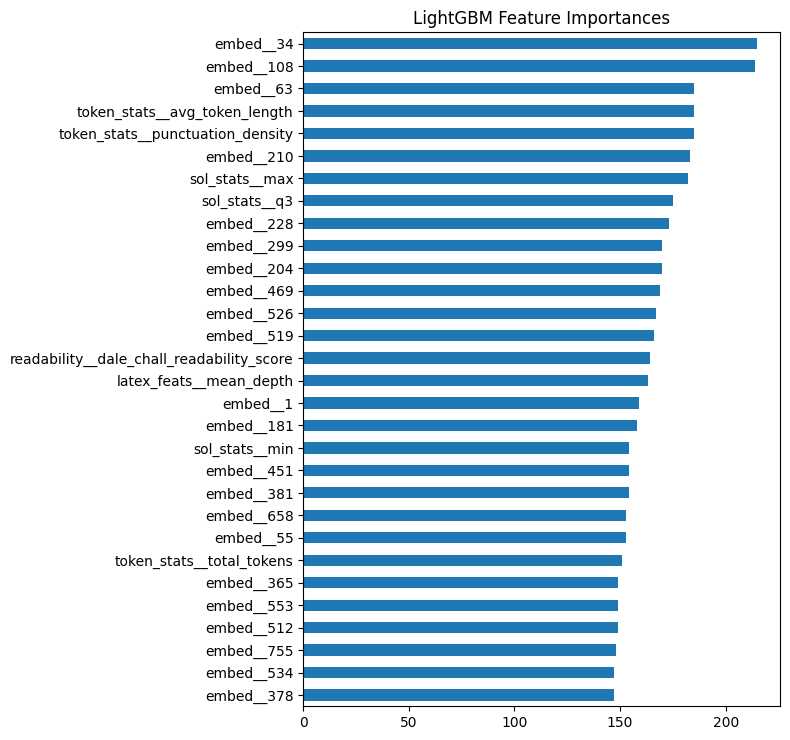

In [ ]:
importances=pipeline.named_steps["regressor"].feature_importances_
fi = pd.Series(importances, index=feat_names)


top_n = 30
top = fi.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(8, top_n*0.25))
top[::-1].plot.barh()
plt.title("LightGBM Feature Importances")
plt.tight_layout()
plt.show()

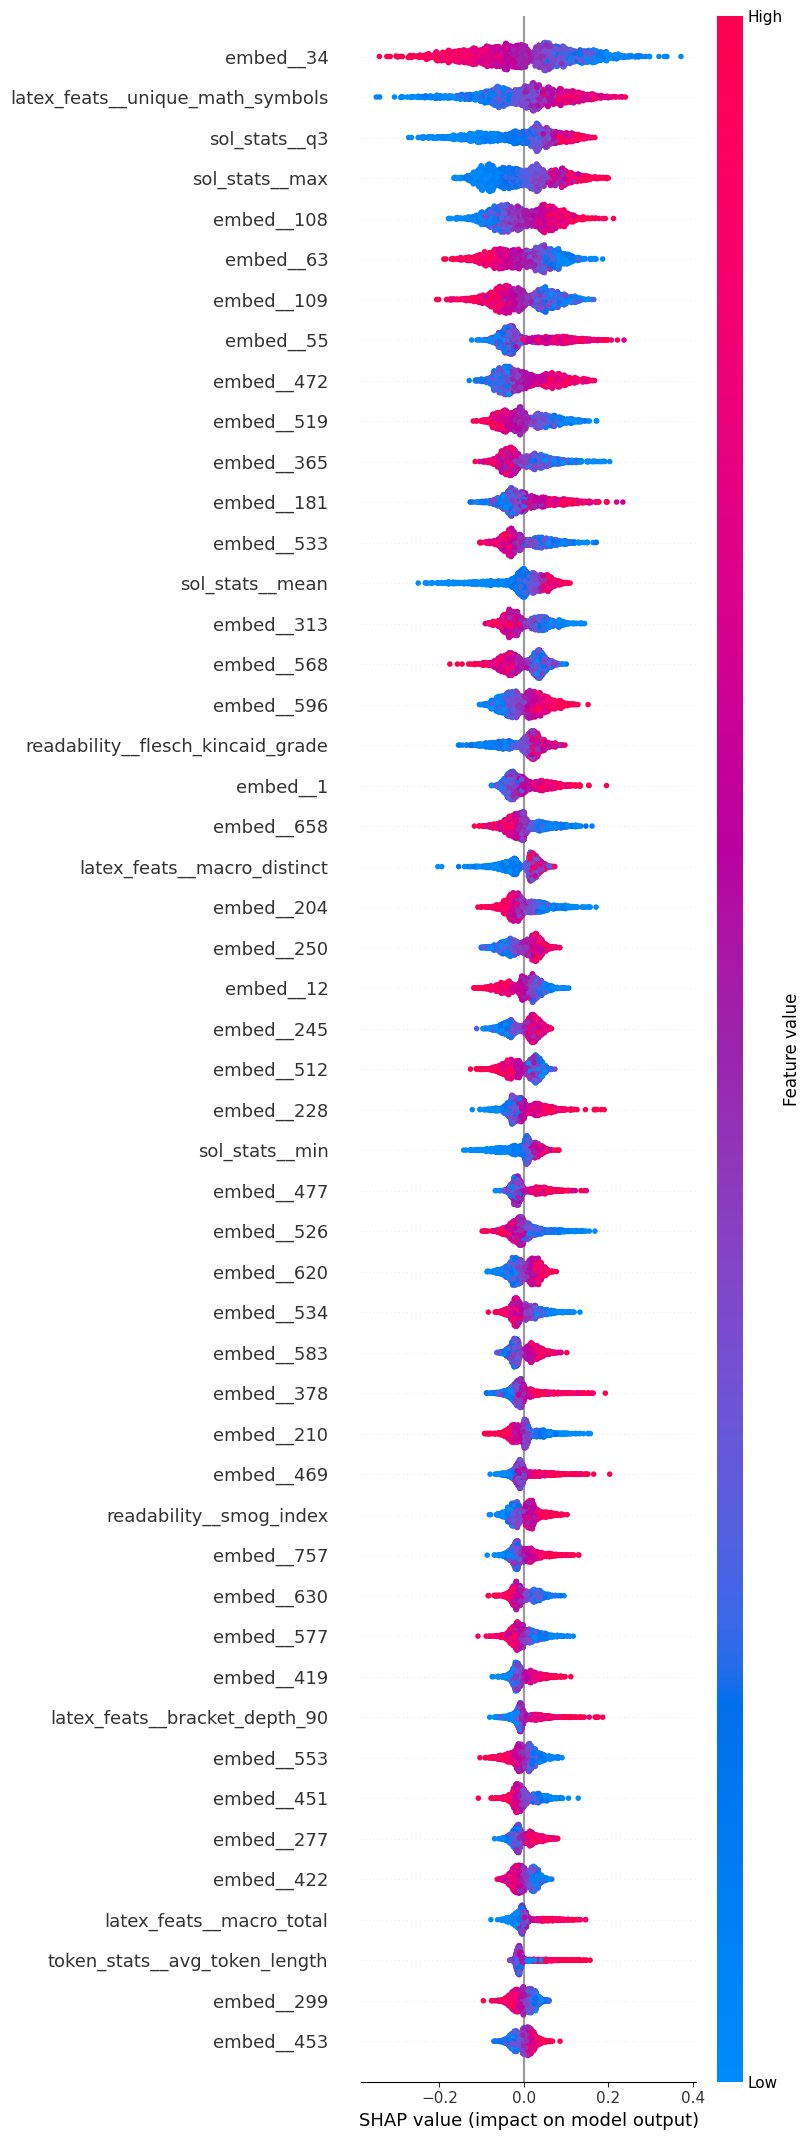

In [ ]:

lgbm = pipeline.named_steps["regressor"]
pre  = pipeline.named_steps["features"]


X_bg = X_train_reg.sample(8000, random_state=0)
X_bg_trans = pre.transform(X_bg)

if spa.issparse(X_bg_trans):
    X_for_shap = X_bg_trans.toarray()
else:
    X_for_shap = X_bg_trans

explainer = shap.TreeExplainer(lgbm)


X_ex = X_test_reg.sample(2000, random_state=1)
X_ex_trans = pre.transform(X_ex)
if spa.issparse(X_ex_trans):
    X_for_shap_test = X_ex_trans.toarray()
else:
    X_for_shap_test = X_ex_trans
shap_values = explainer.shap_values(X_for_shap_test)

shap.summary_plot(
    shap_values,
    X_for_shap_test,
    feature_names=feat_names,
    max_display=50,
)

**Feature Importance vs. SHAP Insights**

- **Embeddings lead the pack.**  
  Both LightGBM’s built-in gains and the SHAP summary agree that a small handful of SBERT embedding dimensions (e.g. `embed__34`, `embed__108`, `embed__63`) drive most of the predictive power.  

- **Solution-length stats are very strong.**  
  The max, mean and 75 th percentile of our R1/R2/R3 “solution lengths” rank near the top in both plots—confirming that longer worked‐out solutions tend to correlate with higher difficulty.  

- **Math-specific features punch above their weight.**  
  SHAP highlights `latex_feats__unique_math_symbols` as one of the very top contributors, even though its raw gain ranking was lower. This tells us symbol‐rich questions are often harder.

- **Token counts and readability are overrated.**  
  Although LightGBM sometimes splits on `total_tokens` or Flesch/Dale-Chall scores (they appear in the gain list), their overall SHAP magnitudes are small. In practice, they explain little variation once embeddings and solution stats are included.

- **Discrepancies reveal “shortcuts.”**  
  The model can leverage simple heuristics (e.g. question length) to boost gain, but SHAP shows these have inconsistent, marginal effects. Relying on them may hurt generalization.

---

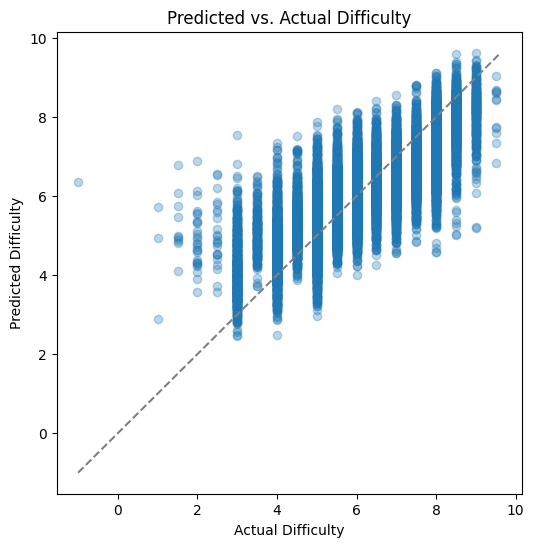

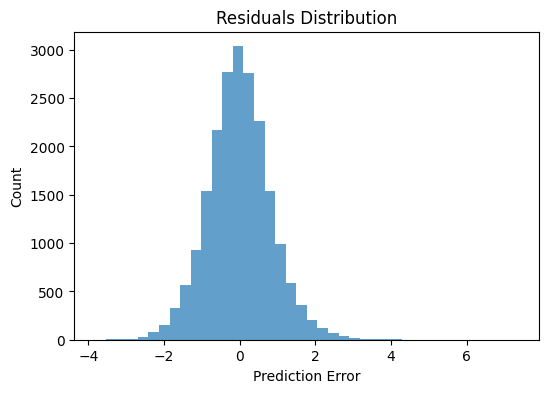

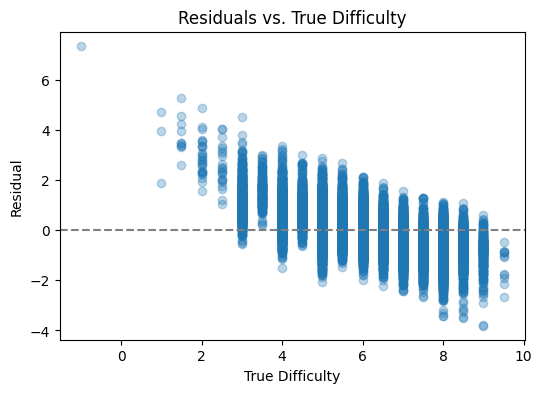

In [ ]:


plt.figure(figsize=(6,6))
plt.scatter(y_test_reg, y_pred, alpha=0.3)
lims = [min(y_test_reg.min(), y_pred.min()), max(y_test_reg.max(), y_pred.max())]
plt.plot(lims, lims, "--", color="gray")
plt.xlabel("Actual Difficulty"); plt.ylabel("Predicted Difficulty")
plt.title("Predicted vs. Actual Difficulty")
plt.show()

y_true=y_test_reg
plt.figure(figsize=(6,4))
plt.hist((y_pred - y_true), bins=40, alpha=0.7)
plt.title("Residuals Distribution"); plt.xlabel("Prediction Error"); plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_true, (y_pred - y_true), alpha=0.3)
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("True Difficulty"); plt.ylabel("Residual")
plt.title("Residuals vs. True Difficulty")
plt.show()


**Predicted vs. Actual Difficulty**  
- The points cluster tightly along the 45° reference line, showing the model captures the overall trend well.  
- Most predictions fall within ±1 of the true label, indicating good mean accuracy.  
- We can see “bands” at integer difficulty levels (a side‐effect of training on discrete labels).  
- There’s a slight bias: at the low end (actual < 3) the model tends to overestimate, and at the high end (>8) it tends to underestimate.  

**Residuals Distribution**  
- The residuals form an approximately symmetric, bell‐shaped histogram centered near zero—evidence that the errors are unbiased on average.  
- The tails extend out to ±4, signaling occasional large miss‐predictions (possible outliers or rare question types).  
- A slight skew toward positive residuals suggests a mild tendency to over-predict, especially on easier questions.  

**Residuals vs. True Difficulty**  
- In the mid‐range difficulties (≈4–6), residuals are tightly packed around zero, showing high precision on the bulk of the data.  
- There’s a clear heteroscedastic pattern: positive residuals (over-predictions) for low‐difficulty questions and negative residuals (under-predictions) for high‐difficulty ones.  
- This “compression” means the model’s slope is too shallow—it doesn’t fully stretch out the extremes.  


## LLM: No reasoning, reasoning, fine tuning

### Installation

In [ ]:
%%capture

if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [ ]:
seed = 3407

### Unsloth

Retrieve the target pretrained model.

In [ ]:
fourbit_models = [
    "unsloth/Qwen3-1.7B-unsloth-bnb-4bit", # Qwen 14B 2x faster
    "unsloth/Qwen3-4B-unsloth-bnb-4bit",
    "unsloth/Qwen3-8B-unsloth-bnb-4bit",
    "unsloth/Qwen3-14B-unsloth-bnb-4bit",
    "unsloth/Qwen3-32B-unsloth-bnb-4bit",

    # 4bit dynamic quants for superior accuracy and low memory use
    "unsloth/gemma-3-12b-it-unsloth-bnb-4bit",
    "unsloth/Phi-4",
    "unsloth/Llama-3.1-8B",
    "unsloth/Llama-3.2-3B",
    "unsloth/orpheus-3b-0.1-ft-unsloth-bnb-4bit" # [NEW] We support TTS models!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-1.7B-unsloth-bnb-4bit",
    max_seq_length = 2048,   # Context length - can be longer, but uses more memory
    load_in_4bit = True,     # 4bit uses much less memory
    load_in_8bit = False,    # A bit more accurate, uses 2x memory
    full_finetuning = False, # We have full finetuning now!
    # token = "hf_...",      # use one if using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.6: Fast Qwen3 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.41G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/4.67k [00:00<?, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 32,           # Choose any number > 0! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 32,  # Best to choose alpha = rank or rank*2
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = seed,
    use_rslora = False,   # We support rank stabilized LoRA
    loftq_config = None,  # And LoftQ
)

Unsloth 2025.5.6 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


<a name="Data"></a>
### Data Prep
Qwen3 has both reasoning and a non reasoning mode. So, we should use 2 datasets:

1. We use the [DeepMath](https://huggingface.co/datasets/zwhe99/DeepMath-103K)! We sample 10% reasoning traces that used DeepSeek R1.

2. We also leverage [Maxime Labonne's FineTome-100k](https://huggingface.co/datasets/mlabonne/FineTome-100k) dataset in ShareGPT style. But we need to convert it to HuggingFace's normal multiturn format as well.

In [ ]:
non_reasoning_dataset = load_dataset("mlabonne/FineTome-100k", split = "train")

README.md:   0%|          | 0.00/982 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [ ]:
target_ds = load_dataset("zwhe99/DeepMath-103K", split = "train[:10%]")

Let's see the structure of both datasets:

In [ ]:
non_reasoning_dataset

Dataset({
    features: ['conversations', 'source', 'score'],
    num_rows: 100000
})

In [ ]:
target_ds

Dataset({
    features: ['question', 'final_answer', 'difficulty', 'topic', 'r1_solution_1', 'r1_solution_2', 'r1_solution_3'],
    num_rows: 10302
})

Explore topic distribution

In [ ]:
# prompt: generate topic count on target_ds, topic is a column of dataset

counter = Counter(target_ds['topic'])
pprint(counter)


Counter({'Mathematics -> Calculus -> Integral Calculus -> Techniques of Integration -> Single-variable': 890,
         'Mathematics -> Calculus -> Differential Calculus -> Applications of Derivatives': 854,
         'Mathematics -> Precalculus -> Limits': 725,
         'Mathematics -> Calculus -> Integral Calculus -> Applications of Integrals': 676,
         'Mathematics -> Calculus -> Integral Calculus -> Techniques of Integration -> Multi-variable': 631,
         'Mathematics -> Applied Mathematics -> Statistics -> Probability -> Other': 545,
         'Mathematics -> Algebra -> Abstract Algebra -> Group Theory': 424,
         'Mathematics -> Algebra -> Abstract Algebra -> Field Theory': 381,
         'Mathematics -> Algebra -> Linear Algebra -> Matrices': 373,
         'Mathematics -> Calculus -> Differential Calculus -> Derivatives': 304,
         'Mathematics -> Discrete Mathematics -> Combinatorics': 275,
         'Mathematics -> Algebra -> Abstract Algebra -> Ring Theory': 261,
 

As the dataset is very large and we are limited by GPU hours available, we defined a target topic and fine tune only data related to that topic.

In [ ]:
target_topics = ['Mathematics -> Calculus -> Integral Calculus -> Techniques of Integration -> Multi-variable']

In [ ]:
target_ds_f = target_ds.filter(lambda r: r["topic"] in target_topics)

Filter:   0%|          | 0/10302 [00:00<?, ? examples/s]

In [ ]:
target_ds_f

Dataset({
    features: ['question', 'final_answer', 'difficulty', 'topic', 'r1_solution_1', 'r1_solution_2', 'r1_solution_3'],
    num_rows: 631
})

We now convert the reasoning dataset into conversational format:

In [ ]:
def generate_conversation_target(examples):
    problems  = examples["question"]
    solutions = examples["r1_solution_1"]
    solutions = ['<think> ' + s for s in solutions]
    conversations = []
    for problem, solution in zip(problems, solutions):
        conversations.append([
            {"role" : "user",      "content" : problem},
            {"role" : "assistant", "content" : solution},
        ])
    return { "conversations": conversations, }

In [ ]:
reasoning_conversations_target = tokenizer.apply_chat_template(
    target_ds_f.map(generate_conversation_target, batched = True)["conversations"],
    tokenize = False,
)

Map:   0%|          | 0/631 [00:00<?, ? examples/s]

In [ ]:
reasoning_conversations_target[0]

"<|im_start|>user\nEvaluate the double integral \\( \\iint_\\Omega \\sqrt{x^2+y^2} \\,\\mathrm{d}x\\mathrm{d}y \\), where \\( \\Omega \\) is the region defined by \\((x-1)^2+y^2 \\leq 1\\) and \\(0 \\leq y\\).<|im_end|>\n<|im_start|>assistant\n<think>\n Okay, so I need to evaluate this double integral over the region Ω, which is defined by the inequality (x-1)² + y² ≤ 1 and y ≥ 0. The integrand is the square root of (x² + y²), which I recognize as the distance from the origin to the point (x, y). So this integral is essentially summing up the distances from the origin to all points in the region Ω. Cool, but how do I approach this?\n\nFirst, let me visualize the region Ω. The inequality (x - 1)² + y² ≤ 1 describes a circle with center at (1, 0) and radius 1. Since y ≥ 0, we're only considering the upper half of this circle. So Ω is a semicircle centered at (1, 0) with radius 1, lying above the x-axis. Got that.\n\nNow, integrating over a circular region usually makes me think of switch

Next we take the non reasoning dataset and convert it to conversational format as well.

We have to use Unsloth's `standardize_sharegpt` function to fix up the format of the dataset first.

In [ ]:

dataset = standardize_sharegpt(non_reasoning_dataset)

non_reasoning_conversations = tokenizer.apply_chat_template(
    dataset["conversations"],
    tokenize = False,
)

Unsloth: Standardizing formats (num_proc=2):   0%|          | 0/100000 [00:00<?, ? examples/s]

Let's see the first row

In [ ]:
non_reasoning_conversations[0]

'<|im_start|>user\nExplain what boolean operators are, what they do, and provide examples of how they can be used in programming. Additionally, describe the concept of operator precedence and provide examples of how it affects the evaluation of boolean expressions. Discuss the difference between short-circuit evaluation and normal evaluation in boolean expressions and demonstrate their usage in code. \n\nFurthermore, add the requirement that the code must be written in a language that does not support short-circuit evaluation natively, forcing the test taker to implement their own logic for short-circuit evaluation.\n\nFinally, delve into the concept of truthiness and falsiness in programming languages, explaining how it affects the evaluation of boolean expressions. Add the constraint that the test taker must write code that handles cases where truthiness and falsiness are implemented differently across different programming languages.<|im_end|>\n<|im_start|>assistant\n<think>\n\n</th

Now let's see how long both datasets are:



In [ ]:
print(len(reasoning_conversations_target))
print(len(non_reasoning_conversations))

631
100000


The non reasoning dataset is much longer. Let's assume we want the model to retain some reasoning capabilities, but we specifically want a chat model.

Let's define a ratio of chat only data. The goal is to define some mixture of both sets of data.

Let's select 25% reasoning and 75% chat based:

In [ ]:
chat_percentage = 0.75

Let's sample the reasoning dataset by 25% (or whatever is 100% - chat_percentage)

In [ ]:
# We ship the target dataset here
non_reasoning_subset = pd.Series(non_reasoning_conversations)
non_reasoning_subset = non_reasoning_subset.sample(
    int(len(reasoning_conversations_target) * (1.0 - chat_percentage)),
    random_state = seed,
)

In [ ]:
print(len(reasoning_conversations_target))
print(len(non_reasoning_subset))

631
157


Finally combine both datasets:

In [ ]:
data = pd.concat([
    pd.Series(reasoning_conversations_target),
    pd.Series(non_reasoning_subset)
])
data.name = "text"


combined_dataset = Dataset.from_pandas(pd.DataFrame(data))
combined_dataset = combined_dataset.shuffle(seed = seed)

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`!. We do 3 epochs of training.

In [ ]:

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = combined_dataset,
    eval_dataset = None, # Can set up evaluation!
    args = SFTConfig(
        dataset_num_proc = 1,
        dataset_text_field = "text",
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 16, # Use GA to mimic batch size!
        warmup_steps = 5,
        num_train_epochs = 3, # Set this for 1 full training run.
        #max_steps = 40,
        learning_rate = 2e-4, # Reduce to 2e-5 for long training runs
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = seed,
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/788 [00:00<?, ? examples/s]

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
5.475 GB of memory reserved.


Let's train and save the model! To resume a training run, set `trainer.train(resume_from_checkpoint = True)`

In [ ]:
trainer_stats = trainer.train()
trainer.save_model('/content/qwen3_deepmath')

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 788 | Num Epochs = 3 | Total steps = 18
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 16 x 1) = 128
 "-____-"     Trainable parameters = 34,865,152/7,000,000,000 (0.50% trained)


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - 11.898, 3)
used_percentage = round(used_memory / 14.741 * 100, 3)
lora_percentage = round(used_memory_for_lora / 14.741 * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

2973.4467 seconds used for training.
49.56 minutes used for training.
Peak reserved memory = 5.475 GB.
Peak reserved memory for training = -6.423 GB.
Peak reserved memory % of max memory = 37.141 %.
Peak reserved memory for training % of max memory = -43.572 %.


<a name="Inference"></a>
### Inference
Let's run the model via Unsloth native inference! According to the `Qwen-3` team, the recommended settings for reasoning inference are `temperature = 0.6, top_p = 0.95, top_k = 20`

For normal chat based inference, `temperature = 0.7, top_p = 0.8, top_k = 20`.

Naturally we choose samples that share the same topic of the training set.


In [ ]:
inference_ds = load_dataset("zwhe99/DeepMath-103K", split = "train[10%:20%]")
inference_ds_f = inference_ds.filter(lambda r: r["topic"] in target_topics)

Filter:   0%|          | 0/10302 [00:00<?, ? examples/s]

In [ ]:
inference_ds_f

Dataset({
    features: ['question', 'final_answer', 'difficulty', 'topic', 'r1_solution_1', 'r1_solution_2', 'r1_solution_3'],
    num_rows: 549
})

In [ ]:
inference_ds_f[420]['question']

'Evaluate the line integral \\(\\int\\limits_C (x^2+y^2)\\, dx + 2xy \\,dy\\) where \\(C\\) is the path of the semicircular arc of the circle \\(x^2+y^2=4\\) starting at \\((2,0)\\) and ending at \\((-2,0)\\) going counterclockwise.'

Show the expected result:

In [ ]:
print(inference_ds_f[420]['final_answer'], '\n', inference_ds_f[420]['difficulty'], '\n', inference_ds_f[420]['topic'])

-\dfrac{16}{3} 
 5.5 
 Mathematics -> Calculus -> Integral Calculus -> Techniques of Integration -> Multi-variable


In [ ]:
content_template = "You are a math expert. YOU ONLY ANSWER VALID JSON. DON'T ADD ANY OTHER HUMAN INTERACTION. DON'T WRAP IN MARKDOWN OR OTHER SYNTAX. The user will give you math questions. You have three task to perform on such question: (1) assess the difficulty of the question on a scale from 1 to 10 where 1 is first grade level and 10 is phd level, (2) to assign a topic to the question (e.g. linear algebra) (3) solve the question and only provide the shortest form for the answer (e.g. the numeric value or latex). You will reply EXCLUSIVELY IN THE FOLLOWING JSON FORMAT: {'difficulty': difficulty, 'topic': topic, 'short_answer': short_answer}"

We can then prepare the messages and ask the model to generate a response. Due to the nature of the model being used, it's very simple to swithc from a non reasoning mode to a reasoning mode.

Inference with non reasoning mode:

In [ ]:
messages = [
    {"role" : "user", "content" : content_template + "\n" + inference_ds_f[420]['question']}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = False, # Disable thinking
)

_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 1024 * 4, # Increase for longer outputs!
    temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

{
  "difficulty": 10,
  "topic": "Line Integrals",
  "short_answer": "\\int_{C} (x^2 + y^2) dx + 2xy dy = 16"
}<|im_end|>


Unfortunately, we are far from the exact answer.

Inference with reasoning mode:

In [ ]:
messages = [
    {"role" : "user", "content" : content_template + "\n" + inference_ds_f[420]['question']}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = True, # Disable thinking
)

_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 1024 * 4, # Increase for longer outputs!
    temperature = 0.6, top_p = 0.95, top_k = 20, # For thinking
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

<think>
Okay, let's see. The problem is to evaluate the line integral \(\int\limits_C (x^2+y^2)\, dx + 2xy \,dy\), where \(C\) is the semicircular arc of the circle \(x^2 + y^2 = 4\) from (2,0) to (-2,0) going counterclockwise. Hmm.

First, I need to recall how to compute line integrals. Since the curve \(C\) is a semicircle, maybe it's easier to parameterize it. The circle \(x^2 + y^2 = 4\) has radius 2. The semicircle from (2,0) to (-2,0) counterclockwise would be the upper semicircle. So, parametric equations for a semicircle can be \(x = 2\cos\theta\), \(y = 2\sin\theta\), with \(\theta\) going from 0 to \(\pi\). Wait, but when \(\theta = 0\), we get (2,0), and when \(\theta = \pi\), we get (-2,0). Yes, that seems right.

Next, I need to express the integral in terms of \(\theta\). The differential \(dx\) and \(dy\) would be the derivatives of the parametric equations. Let's compute them:

\(dx/d\theta = -2\sin\theta\), so \(dx = -2\sin\theta d\theta\).

\(dy/d\theta = 2\cos\theta\

This result shows the model's reasoning process. The correct answer is `−16/3​`, and while the model initially computes an incorrect result of −20, it later explores alternative approaches, identifies contradictions, and ultimately converges to the correct solution through logical deduction and error checking.

Now let's try the base pretrained model without finetuning steps.

In [ ]:
model_base, tokenizer_base = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-1.7B-unsloth-bnb-4bit",
    max_seq_length = 2048,   # Context length - can be longer, but uses more memory
    load_in_4bit = True,     # 4bit uses much less memory
    load_in_8bit = False,    # A bit more accurate, uses 2x memory
    full_finetuning = False, # We have full finetuning now!
    # token = "hf_...",      # use one if using gated models
)

==((====))==  Unsloth 2025.5.6: Fast Qwen3 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Inference base model in reasoning mode:

In [ ]:
messages = [
    {"role" : "user", "content" : inference_ds_f[420]['question']}
]

# print('Base model no resoaning:')
# text = tokenizer.apply_chat_template(
#     messages,
#     tokenize = False,
#     add_generation_prompt = True, # Must add for generation
#     enable_thinking = False, # Disable thinking
# )

# _ = model_base.generate(
#     **tokenizer(text, return_tensors = "pt").to("cuda"),
#     max_new_tokens = 1024 * 4, # Increase for longer outputs!
#     temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
#     streamer = TextStreamer(tokenizer, skip_prompt = True),
# )

print('Base model with resoaning:')
text = tokenizer_base.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = True, # Disable thinking
)

_ = model_base.generate(
    **tokenizer_base(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 1024 * 5, # Increase for longer outputs!
    temperature = 0.6, top_p = 0.95, top_k = 20, # For thinking
    streamer = TextStreamer(tokenizer_base, skip_prompt = True),
)

Base model with resoaning:
<think>
Okay, so I need to evaluate this line integral: ∫_C (x² + y²) dx + 2xy dy, where C is the semicircular arc of the circle x² + y² = 4 starting at (2,0) and ending at (-2,0) going counterclockwise. Alright, let me think about how to approach this.

First, I remember that line integrals can sometimes be evaluated using Green's Theorem. Green's Theorem relates a line integral around a simple closed curve C to a double integral over the region D enclosed by C. The theorem states that ∫_C (P dx + Q dy) = ∬_D (∂Q/∂x - ∂P/∂y) dA, provided that P and Q have continuous partial derivatives and the region D is simply connected.

So, in this case, my P is x² + y² and Q is 2xy. Let me check if I can apply Green's Theorem here. The theorem requires that the curve C is closed and lies in a simply connected region. Since the circle x² + y² = 4 is a closed curve, and the region inside it is the disk of radius 2, which is simply connected. So, I think Green's Theorem is

While the base model demonstrates awareness of relevant mathematical tools, it lacks the precision and error correction ability seen in the fine-tuned version. It misapplies Green’s Theorem and makes algebraic errors during integration, ultimately arriving at an incorrect result that is both numerically and conceptually off.